In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from scipy.stats import bootstrap
from Classifier import ClassifierCV
from functions import *
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification

sns.set_style("darkgrid")
sns.set_context("talk",  font_scale=0.6)

# Suppress warnings
warnings.filterwarnings('ignore')

/Users/dvoulgari/Desktop/MLCB/Ass2/Ass2_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data Loading
data_path = os.path.join("..", "data", "breast_cancer.csv")
data = pd.read_csv(data_path)

In [3]:
# Data Inspection
print("Data shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

Data shape: (512, 32)

First 5 rows:
   id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0   1         M        14.68         20.13           94.74      684.5   
1   2         B        11.50         18.45           73.28      407.4   
2   3         M        15.85         23.95          103.70      782.7   
3   4         M        18.82         21.97          123.70     1110.0   
4   5         B        12.95         16.02           83.14      513.7   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.09867           0.07200         0.07395              0.05259   
1          0.09345           0.05991         0.02638              0.02069   
2          0.08401           0.10020         0.09938              0.05364   
3          0.10180           0.13890         0.15940              0.08744   
4          0.10050           0.07943         0.06155              0.03370   

   ...  radius_worst  texture_worst  perimeter_worst  area_wo

In [4]:
# Initial Preprocessing for concistency

# Replace spaces with underscores in column names
data.columns = data.columns.str.replace(' ', '_')

# Encode diagnosis column (M:1, B:0)
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

# Drop ID column - does not provide predictive power
if 'id' in data.columns:
    data = data.drop(columns=['id'])

In [5]:
# Train-test split - 10% of the data for testing in the final evaluation with the best model

# Use only X_raw and y_raw until the final evalutaion
X_raw, X_keptout, y_raw, y_keptout = train_test_split(
    data.drop(columns=['diagnosis']), 
    data['diagnosis'],
    test_size=0.1,
    stratify=data['diagnosis'],
    random_state=42
)

In [6]:
# Convert to numpy arrays for proper indexing in CV
X_raw_np = X_raw.values
y_raw_np = y_raw.values

In [7]:
# Define Classifiers to Evaluate
classifiers = [
    "LogisticRegression-elastic",
    "GaussianNB",
    "LDA",
    "SVM",
    "RandomForest",
    "LightGBM"
]

In [8]:
from joblib import Parallel, delayed
import warnings
from tqdm import tqdm  # For progress bars

# Configuration
R = 10  # Repetitions
N = 5   # Outer folds
K = 3   # Inner folds
TRIALS = 75  # Optuna trials per optimization

# Store results for ALL classifiers
all_results = {
    'metrics': [],
    'params': []
}

def run_repetition(clf_name, rep, X_raw_np, y_raw_np):
    """Run one repetition with proper warning suppression"""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # Suppress all warnings for this repetition
        
        print(f"\n{'='*100}")
        print(f"\nRepetition {rep+1}/{R} - {clf_name}")
        print(f"{'='*100}")
        
        clf = ClassifierCV(
            classifier_name=clf_name,
            outer_folds=N,
            inner_folds=K,
            optimization_trials=TRIALS,
            trial_num=1,
            seed=42 + rep
        )
        
        results_df, best_params = clf.fit_transform(X_raw_np, y_raw_np)
        results_df['Classifier'] = clf_name
        results_df['Repetition'] = rep + 1
        
        print(f"Completed {clf_name} Rep {rep+1} - {len(results_df)} folds")
        return results_df, best_params

for clf_name in classifiers:
    print(f"\n{'='*100}")
    print(f"=== Starting Evaluation: {clf_name} ===")
    print(f"{'='*100}")
    
    # Run repetitions in parallel with progress bar
    repetition_results = Parallel(n_jobs=-1, prefer="processes")(
        delayed(run_repetition)(clf_name, rep, X_raw_np, y_raw_np)
        for rep in tqdm(range(R), desc=f"{clf_name} Repetitions")
    )
    
    # Store results
    for rep_df, params in repetition_results:
        all_results['metrics'].append(rep_df)
        all_results['params'].extend(params)

print("\nCompleted all classifiers!")


=== Starting Evaluation: LogisticRegression-elastic ===


LogisticRegression-elastic Repetitions: 100%|██████████| 10/10 [00:00<00:00, 29.25it/s]




Repetition 1/10 - LogisticRegression-elastic


Repetition 2/10 - LogisticRegression-elastic


Repetition 3/10 - LogisticRegression-elastic


Repetition 4/10 - LogisticRegression-elastic


Repetition 7/10 - LogisticRegression-elastic


Repetition 5/10 - LogisticRegression-elastic


Repetition 6/10 - LogisticRegression-elastic


Repetition 8/10 - LogisticRegression-elastic


Repetition 9/10 - LogisticRegression-elastic


[I 2025-05-09 22:58:18,465] A new study created in memory with name: no-name-7c592f93-e653-4a8d-b9d2-ddc4cb7596e8
[I 2025-05-09 22:58:18,507] Trial 0 finished with value: 0.9557019470062947 and parameters: {'C': 0.3855578142955452, 'l1_ratio': 0.675986904372284}. Best is trial 0 with value: 0.9557019470062947.
[I 2025-05-09 22:58:18,518] Trial 1 finished with value: 0.0 and parameters: {'C': 0.006247272445232053, 'l1_ratio': 0.7307402679090343}. Best is trial 0 with value: 0.9557019470062947.
[I 2025-05-09 22:58:18,525] A new study created in memory with name: no-name-feda2e83-fcc7-43d1-867c-80eecc94bfbc
[I 2025-05-09 22:58:18,531] A new study created in memory with name: no-name-516ef3e2-3536-4377-b470-26a92fc26263
[I 2025-05-09 22:58:18,543] Trial 0 finished with value: 0.0 and parameters: {'C': 0.0011271625982787708, 'l1_ratio': 0.9889120021710232}. Best is trial 0 with value: 0.0.
[I 2025-05-09 22:58:18,553] A new study created in memory with name: no-name-17485eab-5c44-401c-998d-a



Repetition 10/10 - LogisticRegression-elastic


[I 2025-05-09 22:58:18,670] Trial 7 finished with value: 0.9636010345687765 and parameters: {'C': 7.303798145567925, 'l1_ratio': 0.33344682960956373}. Best is trial 7 with value: 0.9636010345687765.
[I 2025-05-09 22:58:18,671] Trial 4 finished with value: 0.9632026498172076 and parameters: {'C': 2.072863949066877, 'l1_ratio': 0.2319580879160773}. Best is trial 1 with value: 0.9632026498172076.
[I 2025-05-09 22:58:18,674] Trial 3 finished with value: 0.9460809646856158 and parameters: {'C': 0.06602076561077563, 'l1_ratio': 0.5593755742651244}. Best is trial 3 with value: 0.9460809646856158.
[I 2025-05-09 22:58:18,676] Trial 1 finished with value: 0.0 and parameters: {'C': 0.0014872673832322279, 'l1_ratio': 0.8629823133889012}. Best is trial 0 with value: 0.959044659044659.
[I 2025-05-09 22:58:18,679] Trial 5 finished with value: 0.8345854687318103 and parameters: {'C': 0.013435584894895441, 'l1_ratio': 0.41089993807516456}. Best is trial 0 with value: 0.9436366724239642.
[I 2025-05-09 2

Fold 0 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'C': 7.303798145567925, 'l1_ratio': 0.33344682960956373}
Fold 0 - F1: 0.941, ROC AUC: 0.953, MCC: 0.907, F2: 0.941, Best Params: {'C': 8.554882346987112, 'l1_ratio': 0.6204098156727161}
Fold 0 - F1: 0.938, ROC AUC: 0.941, MCC: 0.909, F2: 0.938, Best Params: {'C': 11.899298759294448, 'l1_ratio': 0.6776492902575817}
Fold 0 - F1: 0.985, ROC AUC: 0.985, MCC: 0.977, F2: 0.985, Best Params: {'C': 1.057635839031738, 'l1_ratio': 0.4418842689654364}
Fold 0 - F1: 0.986, ROC AUC: 0.991, MCC: 0.977, F2: 0.986, Best Params: {'C': 5.7347159967270285, 'l1_ratio': 0.7334822118217803}
Fold 0 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'C': 0.916704674344696, 'l1_ratio': 0.23219570738775494}
Fold 0 - F1: 0.923, ROC AUC: 0.933, MCC: 0.883, F2: 0.923, Best Params: {'C': 16.997837114910503, 'l1_ratio': 0.41349142035619046}
Fold 0 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'C': 36.6207613263

[I 2025-05-09 22:58:21,976] Trial 74 finished with value: 0.9626262626262627 and parameters: {'C': 0.20815673640432353, 'l1_ratio': 0.1642009638238614}. Best is trial 17 with value: 0.9702862264660018.
[I 2025-05-09 22:58:21,978] Trial 0 finished with value: 0.9631257631257631 and parameters: {'C': 16.997837114910503, 'l1_ratio': 0.41349142035619046}. Best is trial 0 with value: 0.9631257631257631.
[I 2025-05-09 22:58:21,980] Trial 6 finished with value: 0.0 and parameters: {'C': 0.0012429771707501108, 'l1_ratio': 0.3611620851279358}. Best is trial 0 with value: 0.9588648898993727.
[I 2025-05-09 22:58:21,981] Trial 1 finished with value: 0.9422524170368435 and parameters: {'C': 0.029266205907980538, 'l1_ratio': 0.310782698560087}. Best is trial 1 with value: 0.9422524170368435.
[I 2025-05-09 22:58:21,991] Trial 3 finished with value: 0.9465343086032741 and parameters: {'C': 0.06602076561077563, 'l1_ratio': 0.5593755742651244}. Best is trial 3 with value: 0.9465343086032741.
[I 2025-05-

Fold 0 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'C': 1.484908270545265, 'l1_ratio': 0.6869609259294879}
Fold 0 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'C': 0.89432441418737, 'l1_ratio': 0.46081577219630254}


[I 2025-05-09 22:58:22,187] Trial 11 finished with value: 0.9515578054903898 and parameters: {'C': 11.63160521881954, 'l1_ratio': 0.9573854765568237}. Best is trial 5 with value: 0.9515578054903898.
[I 2025-05-09 22:58:22,188] Trial 8 finished with value: 0.9504498686986095 and parameters: {'C': 0.06414795654194326, 'l1_ratio': 0.10063715693697994}. Best is trial 3 with value: 0.9669497973845801.
[I 2025-05-09 22:58:22,190] Trial 6 finished with value: 0.946520337949656 and parameters: {'C': 0.1153997545812123, 'l1_ratio': 0.23502913191185482}. Best is trial 0 with value: 0.9631257631257631.
[I 2025-05-09 22:58:22,196] Trial 4 finished with value: 0.7270899470899471 and parameters: {'C': 0.01522658814371801, 'l1_ratio': 0.8787812165569526}. Best is trial 1 with value: 0.9557165861513689.
[I 2025-05-09 22:58:22,250] Trial 8 finished with value: 0.9559546785353237 and parameters: {'C': 5.01112845166397, 'l1_ratio': 0.594203049207394}. Best is trial 0 with value: 0.9596176821983273.
[I 20

Fold 1 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'C': 0.2926340991704794, 'l1_ratio': 0.7641672524382682}
Fold 1 - F1: 0.885, ROC AUC: 0.897, MCC: 0.842, F2: 0.885, Best Params: {'C': 0.05822123620414749, 'l1_ratio': 0.047409100488298925}
Fold 1 - F1: 0.971, ROC AUC: 0.977, MCC: 0.953, F2: 0.971, Best Params: {'C': 0.27745922214922103, 'l1_ratio': 0.3791775909898275}
Fold 1 - F1: 0.939, ROC AUC: 0.947, MCC: 0.907, F2: 0.939, Best Params: {'C': 0.37322331710888834, 'l1_ratio': 0.2598450772539389}


[I 2025-05-09 22:58:25,075] Trial 71 finished with value: 0.955552811732587 and parameters: {'C': 2.84304011644031, 'l1_ratio': 0.8213776394188982}. Best is trial 19 with value: 0.955552811732587.
[I 2025-05-09 22:58:25,085] Trial 74 finished with value: 0.9586206896551724 and parameters: {'C': 0.26548385424004195, 'l1_ratio': 0.30519074296236526}. Best is trial 28 with value: 0.9623650933995762.
[I 2025-05-09 22:58:25,090] Trial 72 finished with value: 0.0 and parameters: {'C': 0.00010280194543781898, 'l1_ratio': 0.22436046673712728}. Best is trial 19 with value: 0.955552811732587.
[I 2025-05-09 22:58:25,097] Trial 71 finished with value: 0.9670035980948816 and parameters: {'C': 7.931150139818655, 'l1_ratio': 0.8228789360355294}. Best is trial 1 with value: 0.9670035980948816.
[I 2025-05-09 22:58:25,097] Trial 69 finished with value: 0.9666213935876858 and parameters: {'C': 3.802710335617193, 'l1_ratio': 0.04489342939281815}. Best is trial 0 with value: 0.9666213935876858.
[I 2025-05-

Fold 1 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'C': 6.959798353817508, 'l1_ratio': 0.9181551072835975}
Fold 1 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'C': 1.6517661256419358, 'l1_ratio': 0.7967851949686233}
Fold 1 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'C': 8.554882346987112, 'l1_ratio': 0.6204098156727161}
Fold 1 - F1: 0.928, ROC AUC: 0.945, MCC: 0.884, F2: 0.928, Best Params: {'C': 1.2993260957329902, 'l1_ratio': 0.2591395145303327}
Fold 1 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'C': 12.777440844108375, 'l1_ratio': 0.4984350791527815}


[I 2025-05-09 22:58:25,288] Trial 10 finished with value: 0.9588755162765911 and parameters: {'C': 77.98050690736174, 'l1_ratio': 0.4554911779746196}. Best is trial 10 with value: 0.9588755162765911.
[I 2025-05-09 22:58:25,289] Trial 73 finished with value: 0.9666213935876858 and parameters: {'C': 22.145260536686624, 'l1_ratio': 0.8850911099319938}. Best is trial 0 with value: 0.9666213935876858.
[I 2025-05-09 22:58:25,295] Trial 73 finished with value: 0.9557165861513689 and parameters: {'C': 43.10817168878214, 'l1_ratio': 0.9795200018463485}. Best is trial 1 with value: 0.9557165861513689.
[I 2025-05-09 22:58:25,302] Trial 5 finished with value: 0.9521478833276587 and parameters: {'C': 0.5095218752438099, 'l1_ratio': 0.9017218959946383}. Best is trial 5 with value: 0.9521478833276587.
[I 2025-05-09 22:58:25,304] Trial 5 finished with value: 0.9305775810846805 and parameters: {'C': 0.08733522380798606, 'l1_ratio': 0.8944098875868252}. Best is trial 0 with value: 0.9553004396678065.
[I

Fold 1 - F1: 0.971, ROC AUC: 0.983, MCC: 0.955, F2: 0.971, Best Params: {'C': 0.8839979649611485, 'l1_ratio': 0.32551550310418337}


[I 2025-05-09 22:58:25,493] Trial 11 finished with value: 0.9777777777777779 and parameters: {'C': 1.717698932739679, 'l1_ratio': 0.16590966623464448}. Best is trial 6 with value: 0.9816035816035816.
[I 2025-05-09 22:58:25,494] Trial 11 finished with value: 0.9667028533174112 and parameters: {'C': 80.7469740133465, 'l1_ratio': 0.0005136152128424332}. Best is trial 7 with value: 0.9667028533174112.
[I 2025-05-09 22:58:25,499] Trial 9 finished with value: 0.0 and parameters: {'C': 0.00017641558443106807, 'l1_ratio': 0.7686550235015709}. Best is trial 0 with value: 0.9592122166132914.
[I 2025-05-09 22:58:25,505] Trial 5 finished with value: 0.9586293648091401 and parameters: {'C': 0.14301578573877322, 'l1_ratio': 0.8507872544882783}. Best is trial 4 with value: 0.9741935483870968.
[I 2025-05-09 22:58:25,512] Trial 3 finished with value: 0.9521268703975103 and parameters: {'C': 39.168844860724775, 'l1_ratio': 0.9857062764458482}. Best is trial 0 with value: 0.9552975114772867.
[I 2025-05-0

Fold 2 - F1: 0.985, ROC AUC: 0.985, MCC: 0.977, F2: 0.985, Best Params: {'C': 1.3464894804804521, 'l1_ratio': 9.570897196742312e-05}
Fold 2 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'C': 7.303798145567925, 'l1_ratio': 0.33344682960956373}
Fold 2 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'C': 0.4487408851600676, 'l1_ratio': 0.31406166855129497}
Fold 2 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'C': 0.6996320383149279, 'l1_ratio': 0.14864082631466388}


[I 2025-05-09 22:58:28,211] Trial 66 finished with value: 0.9521268703975103 and parameters: {'C': 11.583944499117305, 'l1_ratio': 0.024249177998496366}. Best is trial 37 with value: 0.9591260591260591.
[I 2025-05-09 22:58:28,214] Trial 74 finished with value: 0.9667028533174112 and parameters: {'C': 3.758031946885919, 'l1_ratio': 0.25142387824186374}. Best is trial 7 with value: 0.9667028533174112.
[I 2025-05-09 22:58:28,223] Trial 71 finished with value: 0.96311331266025 and parameters: {'C': 1.293741389325551, 'l1_ratio': 0.5328396362108269}. Best is trial 7 with value: 0.96311331266025.
[I 2025-05-09 22:58:28,229] Trial 69 finished with value: 0.9741935483870968 and parameters: {'C': 1.2325694726276668, 'l1_ratio': 0.6313670134889666}. Best is trial 4 with value: 0.9741935483870968.
[I 2025-05-09 22:58:28,232] Trial 70 finished with value: 0.9626235188032942 and parameters: {'C': 0.2811603180513569, 'l1_ratio': 0.36207987554139587}. Best is trial 16 with value: 0.9667887667887668.


Fold 2 - F1: 0.971, ROC AUC: 0.977, MCC: 0.953, F2: 0.971, Best Params: {'C': 1.057635839031738, 'l1_ratio': 0.4418842689654364}
Fold 2 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'C': 0.9805766136683519, 'l1_ratio': 0.6314118731919915}
Fold 2 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'C': 2.072863949066877, 'l1_ratio': 0.2319580879160773}
Fold 2 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'C': 0.17896919955488808, 'l1_ratio': 0.327211096580744}
Fold 2 - F1: 1.000, ROC AUC: 1.000, MCC: 1.000, F2: 1.000, Best Params: {'C': 1.767173198190131, 'l1_ratio': 0.22163984414320054}


[I 2025-05-09 22:58:28,419] Trial 73 finished with value: 0.9706855791962176 and parameters: {'C': 7.531464172278453, 'l1_ratio': 0.4333905324412657}. Best is trial 4 with value: 0.9741935483870968.
[I 2025-05-09 22:58:28,420] Trial 72 finished with value: 0.9438996708659629 and parameters: {'C': 0.4633390470529632, 'l1_ratio': 0.796838239747928}. Best is trial 11 with value: 0.9513070782733705.
[I 2025-05-09 22:58:28,427] Trial 0 finished with value: 0.9741102607248187 and parameters: {'C': 16.245249943485476, 'l1_ratio': 0.16353512791480684}. Best is trial 0 with value: 0.9741102607248187.
[I 2025-05-09 22:58:28,430] A new study created in memory with name: no-name-46decf6f-4b9f-4b91-b86e-f44db7963f1c
[I 2025-05-09 22:58:28,435] Trial 1 finished with value: 0.0 and parameters: {'C': 0.0017486525434328905, 'l1_ratio': 0.9729332118238696}. Best is trial 0 with value: 0.9741102607248187.
[I 2025-05-09 22:58:28,438] Trial 0 finished with value: 0.0 and parameters: {'C': 0.000440326835463

Fold 2 - F1: 0.985, ROC AUC: 0.985, MCC: 0.977, F2: 0.985, Best Params: {'C': 12.777440844108375, 'l1_ratio': 0.4984350791527815}


[I 2025-05-09 22:58:28,621] A new study created in memory with name: no-name-1ed09120-78f5-4246-8491-a50c49b2a6a0
[I 2025-05-09 22:58:28,627] Trial 3 finished with value: 0.9338783509859988 and parameters: {'C': 9.39633177686306, 'l1_ratio': 0.03463779638503439}. Best is trial 1 with value: 0.9338783509859988.
[I 2025-05-09 22:58:28,628] Trial 5 finished with value: 0.0 and parameters: {'C': 0.0002696644688334535, 'l1_ratio': 0.8985288501792178}. Best is trial 3 with value: 0.9668701668701668.
[I 2025-05-09 22:58:28,631] Trial 13 finished with value: 0.9586206896551724 and parameters: {'C': 0.537961101858118, 'l1_ratio': 0.5703589326646958}. Best is trial 10 with value: 0.9587817202509856.
[I 2025-05-09 22:58:28,639] Trial 7 finished with value: 0.9588014981273408 and parameters: {'C': 1.057635839031738, 'l1_ratio': 0.4418842689654364}. Best is trial 6 with value: 0.9703703703703704.
[I 2025-05-09 22:58:28,639] Trial 11 finished with value: 0.9627132750728257 and parameters: {'C': 80.7

Fold 3 - F1: 0.971, ROC AUC: 0.971, MCC: 0.954, F2: 0.971, Best Params: {'C': 96.27467582982742, 'l1_ratio': 0.7280976358043252}
Fold 3 - F1: 0.971, ROC AUC: 0.977, MCC: 0.954, F2: 0.971, Best Params: {'C': 1.180690927482263, 'l1_ratio': 0.5791124002824923}
Fold 3 - F1: 0.971, ROC AUC: 0.971, MCC: 0.954, F2: 0.971, Best Params: {'C': 7.303798145567925, 'l1_ratio': 0.33344682960956373}


[I 2025-05-09 22:58:31,545] Trial 66 finished with value: 0.9334802210957996 and parameters: {'C': 0.06066613632940319, 'l1_ratio': 0.7289253869321093}. Best is trial 2 with value: 0.9506772297469972.
[I 2025-05-09 22:58:31,562] Trial 73 finished with value: 0.9627132750728257 and parameters: {'C': 36.11657721423311, 'l1_ratio': 0.03276558722179492}. Best is trial 7 with value: 0.9627132750728257.
[I 2025-05-09 22:58:31,596] Trial 69 finished with value: 0.9664585934248855 and parameters: {'C': 2.8238641200801737, 'l1_ratio': 0.23091462436078555}. Best is trial 6 with value: 0.9703703703703704.
[I 2025-05-09 22:58:31,598] Trial 71 finished with value: 0.9741102607248187 and parameters: {'C': 15.188845008007782, 'l1_ratio': 0.1722255684803372}. Best is trial 0 with value: 0.9741102607248187.
[I 2025-05-09 22:58:31,601] Trial 66 finished with value: 0.9511273091280841 and parameters: {'C': 2.001628240215621, 'l1_ratio': 0.2608960038336269}. Best is trial 21 with value: 0.9658597468942297

Fold 3 - F1: 0.930, ROC AUC: 0.945, MCC: 0.886, F2: 0.930, Best Params: {'C': 16.245249943485476, 'l1_ratio': 0.16353512791480684}
Fold 3 - F1: 0.943, ROC AUC: 0.954, MCC: 0.908, F2: 0.943, Best Params: {'C': 6.617910975438238, 'l1_ratio': 0.027489052939724812}
Fold 3 - F1: 0.986, ROC AUC: 0.991, MCC: 0.977, F2: 0.986, Best Params: {'C': 2.072863949066877, 'l1_ratio': 0.2319580879160773}
Fold 3 - F1: 0.958, ROC AUC: 0.968, MCC: 0.931, F2: 0.958, Best Params: {'C': 1.3250700619742373, 'l1_ratio': 0.8746602007624199}
Fold 3 - F1: 0.986, ROC AUC: 0.986, MCC: 0.977, F2: 0.986, Best Params: {'C': 1.150804620539434, 'l1_ratio': 0.6909775615885817}


[I 2025-05-09 22:58:31,957] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0006103353771637345, 'l1_ratio': 0.12241718765233855}. Best is trial 7 with value: 0.9667754017155975.
[I 2025-05-09 22:58:31,958] Trial 74 finished with value: 0.9506772297469972 and parameters: {'C': 1.0316327175481141, 'l1_ratio': 0.7740378911249691}. Best is trial 2 with value: 0.9506772297469972.
[I 2025-05-09 22:58:31,961] Trial 11 finished with value: 0.9674729753677122 and parameters: {'C': 11.63160521881954, 'l1_ratio': 0.9573854765568237}. Best is trial 5 with value: 0.9674729753677122.
[I 2025-05-09 22:58:31,964] Trial 1 finished with value: 0.906740350219891 and parameters: {'C': 0.029266205907980538, 'l1_ratio': 0.310782698560087}. Best is trial 1 with value: 0.906740350219891.
[I 2025-05-09 22:58:31,964] Trial 4 finished with value: 0.9701947006294832 and parameters: {'C': 50.66915411825845, 'l1_ratio': 0.020818575884673285}. Best is trial 0 with value: 0.9701947006294832.
[I 2025-05-09 2

Fold 3 - F1: 0.986, ROC AUC: 0.986, MCC: 0.977, F2: 0.986, Best Params: {'C': 0.4493453002932857, 'l1_ratio': 0.23040439769805807}
Fold 3 - F1: 0.971, ROC AUC: 0.977, MCC: 0.954, F2: 0.971, Best Params: {'C': 0.2302606989713409, 'l1_ratio': 0.004252745936912536}


[I 2025-05-09 22:58:32,177] Trial 8 finished with value: 0.9347719790757766 and parameters: {'C': 0.06414795654194326, 'l1_ratio': 0.10063715693697994}. Best is trial 3 with value: 0.9666927275622929.
[I 2025-05-09 22:58:32,183] Trial 9 finished with value: 0.9635187198797203 and parameters: {'C': 83.61696742131987, 'l1_ratio': 0.420547378737377}. Best is trial 7 with value: 0.9737827715355806.
[I 2025-05-09 22:58:32,184] Trial 9 finished with value: 0.9669424778120431 and parameters: {'C': 74.68121011338536, 'l1_ratio': 0.5929485055900463}. Best is trial 1 with value: 0.9705240813936467.
[I 2025-05-09 22:58:32,190] Trial 14 finished with value: 0.9667754017155975 and parameters: {'C': 5.950113578236366, 'l1_ratio': 0.013639519713460224}. Best is trial 7 with value: 0.9667754017155975.
[I 2025-05-09 22:58:32,191] A new study created in memory with name: no-name-b481fe6e-e0ac-433c-a6f2-40c00a4531e4
[I 2025-05-09 22:58:32,197] Trial 10 finished with value: 0.9701947006294832 and paramete

Fold 4 - F1: 0.943, ROC AUC: 0.954, MCC: 0.908, F2: 0.943, Best Params: {'C': 0.35793728025679566, 'l1_ratio': 0.5235052591759162}

=== Metrics ===
                                  F1            ... Negative_PV          
                                mean       std  ...        mean       std
Classifier                                      ...                      
LogisticRegression-elastic  0.967669  0.015416  ...    0.972869  0.015183

[1 rows x 18 columns]
Completed LogisticRegression-elastic Rep 6 - 5 folds
Fold 4 - F1: 0.986, ROC AUC: 0.986, MCC: 0.977, F2: 0.986, Best Params: {'C': 11.899298759294448, 'l1_ratio': 0.6776492902575817}

=== Metrics ===
                                  F1            ... Negative_PV          
                                mean       std  ...        mean       std
Classifier                                      ...                      
LogisticRegression-elastic  0.966947  0.020602  ...     0.96997  0.020584

[1 rows x 18 columns]
Completed Logi

[I 2025-05-09 22:58:34,860] Trial 66 finished with value: 0.9538008807671728 and parameters: {'C': 0.40435708243918644, 'l1_ratio': 0.9259420201751307}. Best is trial 16 with value: 0.9738537324744222.
[I 2025-05-09 22:58:34,860] Trial 63 finished with value: 0.9625891106346326 and parameters: {'C': 3.8258082731751935, 'l1_ratio': 0.744527594508973}. Best is trial 2 with value: 0.970106702920941.
[I 2025-05-09 22:58:34,872] Trial 71 finished with value: 0.9701947006294832 and parameters: {'C': 17.633874939483032, 'l1_ratio': 0.227219980907489}. Best is trial 17 with value: 0.9702862264660018.
[I 2025-05-09 22:58:34,877] Trial 74 finished with value: 0.9674729753677122 and parameters: {'C': 6.452748312985465, 'l1_ratio': 0.7971428601225066}. Best is trial 5 with value: 0.9674729753677122.
[I 2025-05-09 22:58:34,879] Trial 69 finished with value: 0.9669424778120431 and parameters: {'C': 16.516312582870903, 'l1_ratio': 0.5413451376662141}. Best is trial 1 with value: 0.9705240813936467.
[

                                  F1            ... Negative_PV          
                                mean       std  ...        mean       std
Classifier                                      ...                      
LogisticRegression-elastic  0.942066  0.035828  ...    0.951093  0.032874

[1 rows x 18 columns]
Completed LogisticRegression-elastic Rep 2 - 5 folds
Fold 4 - F1: 0.941, ROC AUC: 0.948, MCC: 0.908, F2: 0.941, Best Params: {'C': 8.554882346987112, 'l1_ratio': 0.6204098156727161}

=== Metrics ===
                                  F1            ... Negative_PV          
                                mean       std  ...        mean       std
Classifier                                      ...                      
LogisticRegression-elastic  0.958638  0.019286  ...    0.969488  0.018572

[1 rows x 18 columns]
Completed LogisticRegression-elastic Rep 3 - 5 folds
Fold 4 - F1: 0.955, ROC AUC: 0.957, MCC: 0.932, F2: 0.955, Best Params: {'C': 1.057635839031738, 'l1_ratio': 0

[I 2025-05-09 22:58:35,063] Trial 70 finished with value: 0.9666927275622929 and parameters: {'C': 4.427356718951637, 'l1_ratio': 0.686393742192628}. Best is trial 16 with value: 0.9738537324744222.
[I 2025-05-09 22:58:35,070] Trial 69 finished with value: 0.9816035816035816 and parameters: {'C': 33.45609177302582, 'l1_ratio': 0.8849371805859385}. Best is trial 3 with value: 0.9816035816035816.
[I 2025-05-09 22:58:35,076] Trial 72 finished with value: 0.9699523323118829 and parameters: {'C': 0.7204114586463185, 'l1_ratio': 0.6783935323844774}. Best is trial 7 with value: 0.9737827715355806.
[I 2025-05-09 22:58:35,087] Trial 68 finished with value: 0.9504258268964151 and parameters: {'C': 0.28960652541788506, 'l1_ratio': 0.8475158781924573}. Best is trial 2 with value: 0.970106702920941.
[I 2025-05-09 22:58:35,088] Trial 66 finished with value: 0.9663744495205169 and parameters: {'C': 42.89494150943015, 'l1_ratio': 0.8465743766729626}. Best is trial 1 with value: 0.9663744495205169.
[I 

Fold 4 - F1: 0.971, ROC AUC: 0.977, MCC: 0.954, F2: 0.971, Best Params: {'C': 0.8876461905202232, 'l1_ratio': 0.6854263695830997}

=== Metrics ===
                                  F1            ... Negative_PV          
                                mean       std  ...        mean       std
Classifier                                      ...                      
LogisticRegression-elastic  0.967653  0.005589  ...     0.97292  0.008563

[1 rows x 18 columns]
Completed LogisticRegression-elastic Rep 10 - 5 folds
Fold 4 - F1: 0.928, ROC AUC: 0.940, MCC: 0.884, F2: 0.928, Best Params: {'C': 39.168844860724775, 'l1_ratio': 0.9857062764458482}

=== Metrics ===
                                  F1            ... Negative_PV          
                                mean       std  ...        mean       std
Classifier                                      ...                      
LogisticRegression-elastic  0.962055  0.033284  ...    0.972523  0.019621

[1 rows x 18 columns]
Completed Logi

GaussianNB Repetitions: 100%|██████████| 10/10 [00:00<00:00, 8326.99it/s]




Repetition 1/10 - GaussianNB


Repetition 2/10 - GaussianNB


Repetition 3/10 - GaussianNB


Repetition 4/10 - GaussianNB


Repetition 5/10 - GaussianNB


Repetition 6/10 - GaussianNB


Repetition 7/10 - GaussianNB


Repetition 8/10 - GaussianNB


Repetition 9/10 - GaussianNB
Fold 0 - F1: 0.882, ROC AUC: 0.907, MCC: 0.813, F2: 0.882, Best Params: None


Repetition 10/10 - GaussianNB
Fold 0 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: None
Fold 0 - F1: 0.923, ROC AUC: 0.933, MCC: 0.883, F2: 0.923, Best Params: None
Fold 0 - F1: 0.862, ROC AUC: 0.886, MCC: 0.788, F2: 0.862, Best Params: None
Fold 0 - F1: 0.909, ROC AUC: 0.924, MCC: 0.859, F2: 0.909, Best Params: None
Fold 0 - F1: 0.906, ROC AUC: 0.918, MCC: 0.860, F2: 0.906, Best Params: None
Fold 0 - F1: 0.939, ROC AUC: 0.947, MCC: 0.907, F2: 0.939, Best Params: None
Fold 0 - F1: 0.824, ROC AUC: 0.860, MCC: 0.720, F2: 0.824, Best Params: None
Fold 1 - F1: 0.896, ROC AUC: 0.915, MCC: 0.836, F2: 0.896, Best Params: N

LDA Repetitions: 100%|██████████| 10/10 [00:00<00:00, 12721.58it/s]



Repetition 1/10 - LDA


Repetition 2/10 - LDA


Repetition 3/10 - LDA


Repetition 4/10 - LDA


Repetition 5/10 - LDA


Repetition 6/10 - LDA


Repetition 7/10 - LDA


Repetition 8/10 - LDA


Repetition 9/10 - LDA


Repetition 10/10 - LDA



[I 2025-05-09 22:58:35,758] A new study created in memory with name: no-name-bf48e7f6-215d-4cdc-b437-d4777118ffd1
[I 2025-05-09 22:58:35,762] A new study created in memory with name: no-name-cf785f88-0576-448c-9410-34d48028db66
[I 2025-05-09 22:58:35,765] Trial 0 finished with value: 0.9374679514790522 and parameters: {'solver': 'lsqr', 'shrinkage': 0.7307402679090343}. Best is trial 0 with value: 0.9374679514790522.
[I 2025-05-09 22:58:35,768] A new study created in memory with name: no-name-74fa4651-d3fe-4b79-95e3-30adfb892cc3
[I 2025-05-09 22:58:35,768] A new study created in memory with name: no-name-7335f87e-396e-4366-a6b0-5d1683a9229f
[I 2025-05-09 22:58:35,770] A new study created in memory with name: no-name-11f7b0a4-8c81-433a-8dd9-49478c8a16e4
[I 2025-05-09 22:58:35,770] A new study created in memory with name: no-name-80d19e46-8749-44e4-b4a7-63e57e40d01b
[I 2025-05-09 22:58:35,771] A new study created in memory with name: no-name-7852b005-0f57-4e3b-960d-97fbbb80ed11
[I 2025-

Fold 0 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'solver': 'lsqr', 'shrinkage': 0.03463779638503439}
Fold 0 - F1: 0.921, ROC AUC: 0.926, MCC: 0.886, F2: 0.921, Best Params: {'solver': 'eigen', 'shrinkage': 0.07320732270780027}
Fold 0 - F1: 0.885, ROC AUC: 0.897, MCC: 0.842, F2: 0.885, Best Params: {'solver': 'eigen', 'shrinkage': 0.24178823646390044}
Fold 0 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'solver': 'eigen', 'shrinkage': 0.3651424961189206}
Fold 0 - F1: 0.921, ROC AUC: 0.926, MCC: 0.886, F2: 0.921, Best Params: {'solver': 'lsqr', 'shrinkage': 0.14743266381761463}


[I 2025-05-09 22:58:36,746] Trial 2 finished with value: 0.927750905844212 and parameters: {'solver': 'lsqr', 'shrinkage': 0.8944098875868252}. Best is trial 1 with value: 0.9382404163337226.
[I 2025-05-09 22:58:36,747] Trial 73 finished with value: 0.9384300098013009 and parameters: {'solver': 'lsqr', 'shrinkage': 0.03344541921540817}. Best is trial 4 with value: 0.9464411557434813.
[I 2025-05-09 22:58:36,748] Trial 16 finished with value: 0.9444506347767515 and parameters: {'solver': 'eigen', 'shrinkage': 0.3908626300300162}. Best is trial 5 with value: 0.9444506347767515.
[I 2025-05-09 22:58:36,748] Trial 74 finished with value: 0.9499900970489206 and parameters: {'solver': 'eigen', 'shrinkage': 0.16055651310825975}. Best is trial 13 with value: 0.9499900970489206.
[I 2025-05-09 22:58:36,754] Trial 65 finished with value: 0.9230018235089229 and parameters: {'solver': 'svd'}. Best is trial 32 with value: 0.9463511428677265.
[I 2025-05-09 22:58:36,755] Trial 3 finished with value: 0.9

Fold 0 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'solver': 'eigen', 'shrinkage': 0.594203049207394}
Fold 0 - F1: 0.921, ROC AUC: 0.926, MCC: 0.886, F2: 0.921, Best Params: {'solver': 'eigen', 'shrinkage': 0.10063715693697994}
Fold 0 - F1: 0.903, ROC AUC: 0.912, MCC: 0.864, F2: 0.903, Best Params: {'solver': 'lsqr', 'shrinkage': 0.4665373019577125}
Fold 0 - F1: 0.939, ROC AUC: 0.947, MCC: 0.907, F2: 0.939, Best Params: {'solver': 'eigen', 'shrinkage': 0.04465397337688026}
Fold 0 - F1: 0.938, ROC AUC: 0.941, MCC: 0.909, F2: 0.938, Best Params: {'solver': 'lsqr', 'shrinkage': 0.15573534638396422}


[I 2025-05-09 22:58:36,948] Trial 33 finished with value: 0.9398335515688824 and parameters: {'solver': 'lsqr', 'shrinkage': 0.4742100851291063}. Best is trial 5 with value: 0.9444506347767515.
[I 2025-05-09 22:58:36,951] Trial 5 finished with value: 0.942155976429058 and parameters: {'solver': 'lsqr', 'shrinkage': 0.1611363670997763}. Best is trial 3 with value: 0.942155976429058.
[I 2025-05-09 22:58:36,952] Trial 12 finished with value: 0.9583710017650352 and parameters: {'solver': 'lsqr', 'shrinkage': 0.3498825267407034}. Best is trial 7 with value: 0.9583710017650352.
[I 2025-05-09 22:58:36,953] Trial 14 finished with value: 0.934772747523349 and parameters: {'solver': 'eigen', 'shrinkage': 0.20600628296578372}. Best is trial 14 with value: 0.934772747523349.
[I 2025-05-09 22:58:36,955] Trial 19 finished with value: 0.922821521503063 and parameters: {'solver': 'svd'}. Best is trial 10 with value: 0.9505398815743643.
[I 2025-05-09 22:58:36,955] Trial 13 finished with value: 0.938240

Fold 1 - F1: 0.885, ROC AUC: 0.897, MCC: 0.842, F2: 0.885, Best Params: {'solver': 'lsqr', 'shrinkage': 0.3369474584315034}


[I 2025-05-09 22:58:37,555] Trial 55 finished with value: 0.9463511428677265 and parameters: {'solver': 'eigen', 'shrinkage': 0.6088451413216271}. Best is trial 0 with value: 0.9463511428677265.
[I 2025-05-09 22:58:37,559] Trial 58 finished with value: 0.9271078872121373 and parameters: {'solver': 'svd'}. Best is trial 15 with value: 0.9425826896415131.
[I 2025-05-09 22:58:37,560] Trial 56 finished with value: 0.9504498686986095 and parameters: {'solver': 'eigen', 'shrinkage': 0.15940376839821296}. Best is trial 15 with value: 0.9544554416696998.
[I 2025-05-09 22:58:37,560] Trial 58 finished with value: 0.942435582772391 and parameters: {'solver': 'lsqr', 'shrinkage': 0.5687248080509146}. Best is trial 7 with value: 0.9583710017650352.
[I 2025-05-09 22:58:37,561] Trial 57 finished with value: 0.9465343086032741 and parameters: {'solver': 'lsqr', 'shrinkage': 0.4636103572229306}. Best is trial 1 with value: 0.9544554416696998.
[I 2025-05-09 22:58:37,562] Trial 64 finished with value: 0.

Fold 1 - F1: 0.939, ROC AUC: 0.947, MCC: 0.907, F2: 0.939, Best Params: {'solver': 'eigen', 'shrinkage': 0.03895778492366264}
Fold 1 - F1: 0.938, ROC AUC: 0.941, MCC: 0.909, F2: 0.938, Best Params: {'solver': 'eigen', 'shrinkage': 0.08204676225495422}
Fold 1 - F1: 0.938, ROC AUC: 0.941, MCC: 0.909, F2: 0.938, Best Params: {'solver': 'lsqr', 'shrinkage': 0.19483332117703456}
Fold 1 - F1: 0.985, ROC AUC: 0.985, MCC: 0.977, F2: 0.985, Best Params: {'solver': 'eigen', 'shrinkage': 0.12171310528298877}
Fold 1 - F1: 0.867, ROC AUC: 0.882, MCC: 0.820, F2: 0.867, Best Params: {'solver': 'lsqr', 'shrinkage': 0.34559117937530304}
Fold 1 - F1: 0.921, ROC AUC: 0.926, MCC: 0.886, F2: 0.921, Best Params: {'solver': 'eigen', 'shrinkage': 0.13558216741510476}
Fold 1 - F1: 0.938, ROC AUC: 0.941, MCC: 0.909, F2: 0.938, Best Params: {'solver': 'eigen', 'shrinkage': 0.20600628296578372}
Fold 1 - F1: 0.867, ROC AUC: 0.882, MCC: 0.820, F2: 0.867, Best Params: {'solver': 'eigen', 'shrinkage': 0.3107826985600

[I 2025-05-09 22:58:37,764] Trial 71 finished with value: 0.9544554416696998 and parameters: {'solver': 'eigen', 'shrinkage': 0.11155989986787448}. Best is trial 15 with value: 0.9544554416696998.
[I 2025-05-09 22:58:37,765] Trial 21 finished with value: 0.9456302019913511 and parameters: {'solver': 'lsqr', 'shrinkage': 0.345758249289265}. Best is trial 11 with value: 0.9503407211123119.
[I 2025-05-09 22:58:37,767] Trial 64 finished with value: 0.9378609250751831 and parameters: {'solver': 'lsqr', 'shrinkage': 0.10524520048917364}. Best is trial 12 with value: 0.9503567158388168.
[I 2025-05-09 22:58:37,768] Trial 71 finished with value: 0.934772747523349 and parameters: {'solver': 'lsqr', 'shrinkage': 0.2241086946741765}. Best is trial 14 with value: 0.934772747523349.
[I 2025-05-09 22:58:37,770] Trial 70 finished with value: 0.9268969479922827 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9463511428677265.
[I 2025-05-09 22:58:37,771] Trial 1 finished with value: 0.9

Fold 1 - F1: 0.938, ROC AUC: 0.941, MCC: 0.909, F2: 0.938, Best Params: {'solver': 'lsqr', 'shrinkage': 0.02780958139789604}


[I 2025-05-09 22:58:37,966] Trial 8 finished with value: 0.942155976429058 and parameters: {'solver': 'svd'}. Best is trial 1 with value: 0.9463511428677265.
[I 2025-05-09 22:58:37,966] Trial 9 finished with value: 0.9384300098013009 and parameters: {'solver': 'eigen', 'shrinkage': 0.4019626806475497}. Best is trial 0 with value: 0.9384300098013009.
[I 2025-05-09 22:58:37,971] Trial 36 finished with value: 0.9376906318082788 and parameters: {'solver': 'lsqr', 'shrinkage': 0.7501863666607866}. Best is trial 11 with value: 0.9503407211123119.
[I 2025-05-09 22:58:37,973] Trial 18 finished with value: 0.942435582772391 and parameters: {'solver': 'eigen', 'shrinkage': 0.36916583047640694}. Best is trial 1 with value: 0.942435582772391.
[I 2025-05-09 22:58:37,973] Trial 19 finished with value: 0.9260088570433398 and parameters: {'solver': 'svd'}. Best is trial 11 with value: 0.9422524170368435.
[I 2025-05-09 22:58:37,974] A new study created in memory with name: no-name-2b6fc274-2832-4158-8c

Fold 2 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'solver': 'lsqr', 'shrinkage': 0.038423349663459117}
Fold 2 - F1: 0.985, ROC AUC: 0.985, MCC: 0.977, F2: 0.985, Best Params: {'solver': 'lsqr', 'shrinkage': 0.05804834010844165}


[I 2025-05-09 22:58:38,572] Trial 66 finished with value: 0.9258410661778745 and parameters: {'solver': 'eigen', 'shrinkage': 0.6456708559588982}. Best is trial 1 with value: 0.942435582772391.
[I 2025-05-09 22:58:38,573] Trial 55 finished with value: 0.9347617803327236 and parameters: {'solver': 'lsqr', 'shrinkage': 0.05433758176309007}. Best is trial 29 with value: 0.9388605061636066.
[I 2025-05-09 22:58:38,575] Trial 61 finished with value: 0.9427870334495673 and parameters: {'solver': 'eigen', 'shrinkage': 0.41944204880089286}. Best is trial 16 with value: 0.9427870334495673.
[I 2025-05-09 22:58:38,575] Trial 69 finished with value: 0.9259409510930808 and parameters: {'solver': 'lsqr', 'shrinkage': 0.43551938695341064}. Best is trial 26 with value: 0.9460809646856158.
[I 2025-05-09 22:58:38,577] Trial 49 finished with value: 0.9343312839704178 and parameters: {'solver': 'lsqr', 'shrinkage': 0.18457589312125716}. Best is trial 16 with value: 0.9465343086032741.
[I 2025-05-09 22:58:3

Fold 2 - F1: 0.938, ROC AUC: 0.941, MCC: 0.909, F2: 0.938, Best Params: {'solver': 'eigen', 'shrinkage': 0.2860885509244422}
Fold 2 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'solver': 'lsqr', 'shrinkage': 0.13321778887891544}
Fold 2 - F1: 0.938, ROC AUC: 0.941, MCC: 0.909, F2: 0.938, Best Params: {'solver': 'eigen', 'shrinkage': 0.39386156905401043}
Fold 2 - F1: 0.923, ROC AUC: 0.933, MCC: 0.883, F2: 0.923, Best Params: {'solver': 'eigen', 'shrinkage': 0.10066546921335312}
Fold 2 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'solver': 'lsqr', 'shrinkage': 0.11611574578933959}
Fold 2 - F1: 0.938, ROC AUC: 0.941, MCC: 0.909, F2: 0.938, Best Params: {'solver': 'lsqr', 'shrinkage': 0.07054092439154247}


[I 2025-05-09 22:58:38,776] Trial 3 finished with value: 0.9375789469266826 and parameters: {'solver': 'lsqr', 'shrinkage': 0.34908442850549837}. Best is trial 1 with value: 0.9375789469266826.
[I 2025-05-09 22:58:38,777] Trial 61 finished with value: 0.9504498686986095 and parameters: {'solver': 'lsqr', 'shrinkage': 0.2999171598553231}. Best is trial 0 with value: 0.9504498686986095.
[I 2025-05-09 22:58:38,778] Trial 8 finished with value: 0.9228146759095589 and parameters: {'solver': 'eigen', 'shrinkage': 0.9269471252081389}. Best is trial 6 with value: 0.937984496124031.
[I 2025-05-09 22:58:38,778] Trial 64 finished with value: 0.9429641239986067 and parameters: {'solver': 'lsqr', 'shrinkage': 0.06675272926760839}. Best is trial 16 with value: 0.9465343086032741.
[I 2025-05-09 22:58:38,778] Trial 0 finished with value: 0.9071802682913793 and parameters: {'solver': 'lsqr', 'shrinkage': 0.7307402679090343}. Best is trial 0 with value: 0.9071802682913793.
[I 2025-05-09 22:58:38,779] Tr

Fold 2 - F1: 0.985, ROC AUC: 0.985, MCC: 0.977, F2: 0.985, Best Params: {'solver': 'lsqr', 'shrinkage': 0.11081327401404525}
Fold 2 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'solver': 'eigen', 'shrinkage': 0.310782698560087}


[I 2025-05-09 22:58:38,978] Trial 4 finished with value: 0.8955316713937403 and parameters: {'solver': 'lsqr', 'shrinkage': 0.9870490687872092}. Best is trial 0 with value: 0.9338805289557683.
[I 2025-05-09 22:58:38,978] Trial 72 finished with value: 0.9504498686986095 and parameters: {'solver': 'lsqr', 'shrinkage': 0.19975016162990117}. Best is trial 0 with value: 0.9504498686986095.
[I 2025-05-09 22:58:38,979] Trial 5 finished with value: 0.9209917645960036 and parameters: {'solver': 'lsqr', 'shrinkage': 0.7181298887864842}. Best is trial 2 with value: 0.9464411557434813.
[I 2025-05-09 22:58:38,980] Trial 15 finished with value: 0.9330238501575009 and parameters: {'solver': 'eigen', 'shrinkage': 0.052690593978992284}. Best is trial 14 with value: 0.9415211225556052.
[I 2025-05-09 22:58:38,981] Trial 17 finished with value: 0.9418664980462733 and parameters: {'solver': 'eigen', 'shrinkage': 0.14185831532089546}. Best is trial 15 with value: 0.9418664980462733.
[I 2025-05-09 22:58:38,9

Fold 3 - F1: 1.000, ROC AUC: 1.000, MCC: 1.000, F2: 1.000, Best Params: {'solver': 'lsqr', 'shrinkage': 0.038423349663459117}
Fold 3 - F1: 0.939, ROC AUC: 0.943, MCC: 0.910, F2: 0.939, Best Params: {'solver': 'lsqr', 'shrinkage': 0.13015542204080977}


[I 2025-05-09 22:58:39,605] Trial 53 finished with value: 0.9455478873022948 and parameters: {'solver': 'eigen', 'shrinkage': 0.16443682152683492}. Best is trial 2 with value: 0.9464411557434813.
[I 2025-05-09 22:58:39,610] Trial 53 finished with value: 0.9229058751799647 and parameters: {'solver': 'lsqr', 'shrinkage': 0.0020432545384968873}. Best is trial 10 with value: 0.9389382923751727.
[I 2025-05-09 22:58:39,611] Trial 3 finished with value: 0.9336015678849332 and parameters: {'solver': 'svd'}. Best is trial 1 with value: 0.9457470240602771.
[I 2025-05-09 22:58:39,611] Trial 63 finished with value: 0.9373335756851316 and parameters: {'solver': 'lsqr', 'shrinkage': 0.059957835655366984}. Best is trial 5 with value: 0.9417414510891868.
[I 2025-05-09 22:58:39,611] Trial 45 finished with value: 0.9460835535886245 and parameters: {'solver': 'lsqr', 'shrinkage': 0.24597468515215765}. Best is trial 4 with value: 0.9581127039476517.
[I 2025-05-09 22:58:39,613] Trial 46 finished with value

Fold 3 - F1: 0.955, ROC AUC: 0.957, MCC: 0.932, F2: 0.955, Best Params: {'solver': 'eigen', 'shrinkage': 0.19008663866225872}
Fold 3 - F1: 0.923, ROC AUC: 0.929, MCC: 0.888, F2: 0.923, Best Params: {'solver': 'lsqr', 'shrinkage': 0.1611363670997763}
Fold 3 - F1: 0.939, ROC AUC: 0.943, MCC: 0.910, F2: 0.939, Best Params: {'solver': 'eigen', 'shrinkage': 0.025292321766432813}
Fold 3 - F1: 0.955, ROC AUC: 0.957, MCC: 0.932, F2: 0.955, Best Params: {'solver': 'lsqr', 'shrinkage': 0.3081032904776887}
Fold 3 - F1: 0.986, ROC AUC: 0.986, MCC: 0.977, F2: 0.986, Best Params: {'solver': 'lsqr', 'shrinkage': 0.019513100154266244}


[I 2025-05-09 22:58:39,807] Trial 69 finished with value: 0.9339246809835045 and parameters: {'solver': 'lsqr', 'shrinkage': 0.125841680036426}. Best is trial 10 with value: 0.9389382923751727.
[I 2025-05-09 22:58:39,809] Trial 8 finished with value: 0.9150558743581999 and parameters: {'solver': 'eigen', 'shrinkage': 0.9269471252081389}. Best is trial 1 with value: 0.9459003878530771.
[I 2025-05-09 22:58:39,810] Trial 58 finished with value: 0.9063970396421289 and parameters: {'solver': 'svd'}. Best is trial 7 with value: 0.9375985771334608.
[I 2025-05-09 22:58:39,811] Trial 65 finished with value: 0.9417174480785971 and parameters: {'solver': 'eigen', 'shrinkage': 0.2722463823630836}. Best is trial 2 with value: 0.9464411557434813.
[I 2025-05-09 22:58:39,811] A new study created in memory with name: no-name-ca054324-a6c2-4967-937c-7b40170546d3
[I 2025-05-09 22:58:39,811] Trial 61 finished with value: 0.9581127039476517 and parameters: {'solver': 'lsqr', 'shrinkage': 0.0899453494919963

Fold 3 - F1: 0.955, ROC AUC: 0.957, MCC: 0.932, F2: 0.955, Best Params: {'solver': 'eigen', 'shrinkage': 0.020818575884673285}
Fold 3 - F1: 0.955, ROC AUC: 0.957, MCC: 0.932, F2: 0.955, Best Params: {'solver': 'eigen', 'shrinkage': 0.10063715693697994}
Fold 3 - F1: 0.939, ROC AUC: 0.943, MCC: 0.910, F2: 0.939, Best Params: {'solver': 'eigen', 'shrinkage': 0.29277058337231243}


[I 2025-05-09 22:58:40,224] Trial 2 finished with value: 0.9540169133192388 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9540169133192388.
[I 2025-05-09 22:58:40,224] Trial 20 finished with value: 0.9379792547866513 and parameters: {'solver': 'eigen', 'shrinkage': 0.36298816309527493}. Best is trial 13 with value: 0.9460835535886245.
[I 2025-05-09 22:58:40,225] Trial 19 finished with value: 0.9383067963075712 and parameters: {'solver': 'svd'}. Best is trial 17 with value: 0.9460835535886245.
[I 2025-05-09 22:58:40,227] Trial 23 finished with value: 0.9416987071808082 and parameters: {'solver': 'eigen', 'shrinkage': 0.24323976683454462}. Best is trial 3 with value: 0.9457974330116912.
[I 2025-05-09 22:58:40,227] Trial 11 finished with value: 0.9451147920015895 and parameters: {'solver': 'eigen', 'shrinkage': 0.24177624382978735}. Best is trial 10 with value: 0.9451147920015895.
[I 2025-05-09 22:58:40,229] Trial 35 finished with value: 0.9337775741143824 and parameter

Fold 4 - F1: 0.939, ROC AUC: 0.943, MCC: 0.910, F2: 0.939, Best Params: {'solver': 'eigen', 'shrinkage': 0.05959199507299076}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
LDA         0.946466  0.041148  0.946466  ...         0.0    0.945675  0.038661

[1 rows x 18 columns]
Completed LDA Rep 3 - 5 folds
Fold 4 - F1: 0.971, ROC AUC: 0.971, MCC: 0.954, F2: 0.971, Best Params: {'solver': 'lsqr', 'shrinkage': 0.19483332117703456}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
LDA         0.947157  0.031899  0.947157  ...         0.0    0.945063  0.029988

[1 rows x 18 columns]

[I 2025-05-09 22:58:40,842] Trial 63 finished with value: 0.9343312839704178 and parameters: {'solver': 'eigen', 'shrinkage': 0.04540397253058534}. Best is trial 13 with value: 0.9460835535886245.
[I 2025-05-09 22:58:40,844] Trial 66 finished with value: 0.9416987071808082 and parameters: {'solver': 'lsqr', 'shrinkage': 0.23173420057152916}. Best is trial 3 with value: 0.9457974330116912.
[I 2025-05-09 22:58:40,845] Trial 47 finished with value: 0.9420832219549139 and parameters: {'solver': 'lsqr', 'shrinkage': 0.5875945269144858}. Best is trial 12 with value: 0.9622827787105198.
[I 2025-05-09 22:58:40,846] Trial 63 finished with value: 0.9425084769798401 and parameters: {'solver': 'lsqr', 'shrinkage': 0.04960648623436485}. Best is trial 17 with value: 0.9460835535886245.
[I 2025-05-09 22:58:40,847] Trial 51 finished with value: 0.9001276813074566 and parameters: {'solver': 'lsqr', 'shrinkage': 0.9930917029821628}. Best is trial 4 with value: 0.9398335515688824.
[I 2025-05-09 22:58:40,

Fold 4 - F1: 0.971, ROC AUC: 0.971, MCC: 0.954, F2: 0.971, Best Params: {'solver': 'eigen', 'shrinkage': 0.06337052195109899}

=== Metrics ===
Fold 4 - F1: 0.971, ROC AUC: 0.971, MCC: 0.954, F2: 0.971, Best Params: {'solver': 'eigen', 'shrinkage': 0.17405969483853478}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
LDA         0.944771  0.018636  0.944771  ...    0.007711    0.944397  0.017377

[1 rows x 18 columns]
Completed LDA Rep 1 - 5 folds
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
LDA         0.941612  0.017478  0.941612  ...    0.007711    0.941285  0.017607

[1 rows x 18 columns

[I 2025-05-09 22:58:41,047] Trial 67 finished with value: 0.9398335515688824 and parameters: {'solver': 'eigen', 'shrinkage': 0.14585258720117042}. Best is trial 4 with value: 0.9398335515688824.
[I 2025-05-09 22:58:41,050] Trial 70 finished with value: 0.9368663296333608 and parameters: {'solver': 'lsqr', 'shrinkage': 0.32187394513198386}. Best is trial 10 with value: 0.9451147920015895.
[I 2025-05-09 22:58:41,052] Trial 65 finished with value: 0.9538417795718462 and parameters: {'solver': 'lsqr', 'shrinkage': 0.09641071055545376}. Best is trial 12 with value: 0.9622827787105198.
[I 2025-05-09 22:58:41,057] Trial 68 finished with value: 0.9323429148647625 and parameters: {'solver': 'lsqr', 'shrinkage': 0.06975546226154258}. Best is trial 4 with value: 0.9398335515688824.
[I 2025-05-09 22:58:41,063] Trial 71 finished with value: 0.9414575297236376 and parameters: {'solver': 'eigen', 'shrinkage': 0.09943789524634218}. Best is trial 10 with value: 0.9451147920015895.
[I 2025-05-09 22:58:


=== Starting Evaluation: SVM ===


SVM Repetitions: 100%|██████████| 10/10 [00:00<00:00, 16027.15it/s]
[I 2025-05-09 22:58:41,234] A new study created in memory with name: no-name-23e74e20-ea1a-4f53-be7b-d4847ae44229
[I 2025-05-09 22:58:41,236] A new study created in memory with name: no-name-139e4c2f-1a03-4261-a155-fd7449488b4b
[I 2025-05-09 22:58:41,243] A new study created in memory with name: no-name-fbfd6bf3-83dd-44b4-b47c-0092a947bdb3
[I 2025-05-09 22:58:41,244] A new study created in memory with name: no-name-b8c57777-8b0f-40f2-8c07-ee8b70e55a54
[I 2025-05-09 22:58:41,247] A new study created in memory with name: no-name-6d809525-c62e-442d-8948-3ee792b45760




Repetition 1/10 - SVM


Repetition 2/10 - SVM


Repetition 3/10 - SVM


Repetition 4/10 - SVM


Repetition 5/10 - SVM


Repetition 6/10 - SVM


Repetition 7/10 - SVM


Repetition 8/10 - SVM


Repetition 9/10 - SVM


Repetition 10/10 - SVM


[I 2025-05-09 22:58:41,251] A new study created in memory with name: no-name-e4ffbde2-cc29-4027-bfea-15a2ca6cd37f
[I 2025-05-09 22:58:41,255] Trial 0 finished with value: 0.8350152031275005 and parameters: {'kernel': 'sigmoid', 'C': 0.2967811725624694, 'gamma': 0.7146707665164362}. Best is trial 0 with value: 0.8350152031275005.
[I 2025-05-09 22:58:41,257] A new study created in memory with name: no-name-b0127ab2-4bc4-45b5-b1af-21de18206626
[I 2025-05-09 22:58:41,261] Trial 0 finished with value: 0.9548859380320055 and parameters: {'kernel': 'sigmoid', 'C': 42.67747883183368, 'gamma': 0.002663125728108641}. Best is trial 0 with value: 0.9548859380320055.
[I 2025-05-09 22:58:41,278] Trial 0 finished with value: 0.7363367951603245 and parameters: {'kernel': 'sigmoid', 'C': 4.929394354176434, 'gamma': 8.815602497523191e-05}. Best is trial 0 with value: 0.7363367951603245.
[I 2025-05-09 22:58:41,280] Trial 0 finished with value: 0.7208193041526375 and parameters: {'kernel': 'poly', 'C': 0.

Fold 0 - F1: 0.909, ROC AUC: 0.924, MCC: 0.859, F2: 0.909, Best Params: {'kernel': 'linear', 'C': 0.6601645348780005}
Fold 0 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'kernel': 'linear', 'C': 0.05145932559800923}
Fold 0 - F1: 0.941, ROC AUC: 0.953, MCC: 0.907, F2: 0.941, Best Params: {'kernel': 'linear', 'C': 2.2298179974810277}
Fold 0 - F1: 0.938, ROC AUC: 0.941, MCC: 0.909, F2: 0.938, Best Params: {'kernel': 'linear', 'C': 0.1440410020252618}
Fold 0 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'kernel': 'linear', 'C': 0.14737617267702893}


[I 2025-05-09 22:58:43,307] Trial 69 finished with value: 0.9621995494138075 and parameters: {'kernel': 'linear', 'C': 0.015538759865751301}. Best is trial 22 with value: 0.9703703703703703.
[I 2025-05-09 22:58:43,312] Trial 0 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.0015879468862639175, 'gamma': 1.0712055060339403}. Best is trial 0 with value: 0.0.
[I 2025-05-09 22:58:43,313] Trial 2 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.000939116103924797, 'gamma': 0.00026229637462089054}. Best is trial 0 with value: 0.9591169699865351.
[I 2025-05-09 22:58:43,314] Trial 70 finished with value: 0.6816212965500442 and parameters: {'kernel': 'poly', 'C': 0.48062785754719284, 'gamma': 2.101485755613928, 'degree': 4}. Best is trial 16 with value: 0.9705286571432151.
[I 2025-05-09 22:58:43,315] Trial 67 finished with value: 0.9590511860174781 and parameters: {'kernel': 'linear', 'C': 0.04810163017362437}. Best is trial 52 with value: 0.9590511860174781.


Fold 0 - F1: 0.985, ROC AUC: 0.985, MCC: 0.977, F2: 0.985, Best Params: {'kernel': 'linear', 'C': 0.33692650432226506}
Fold 0 - F1: 0.921, ROC AUC: 0.926, MCC: 0.886, F2: 0.921, Best Params: {'kernel': 'linear', 'C': 0.059388819843008166}
Fold 0 - F1: 0.928, ROC AUC: 0.945, MCC: 0.884, F2: 0.928, Best Params: {'kernel': 'linear', 'C': 5.7838191026417896}
Fold 0 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'kernel': 'linear', 'C': 0.050500012539642744}


[I 2025-05-09 22:58:43,514] Trial 74 finished with value: 0.9548859380320055 and parameters: {'kernel': 'linear', 'C': 0.11144828135882011}. Best is trial 52 with value: 0.9590511860174781.
[I 2025-05-09 22:58:43,514] A new study created in memory with name: no-name-163c54b1-8be7-4a61-a93a-7a14fb541daa
[I 2025-05-09 22:58:43,519] Trial 8 finished with value: 0.9743589743589745 and parameters: {'kernel': 'linear', 'C': 0.7804237420058832}. Best is trial 8 with value: 0.9743589743589745.
[I 2025-05-09 22:58:43,528] Trial 5 finished with value: 0.8944232220335785 and parameters: {'kernel': 'sigmoid', 'C': 41.14894641285797, 'gamma': 0.034466048549682174}. Best is trial 2 with value: 0.9356720389106377.
[I 2025-05-09 22:58:43,529] Trial 6 finished with value: 0.9543932623216511 and parameters: {'kernel': 'sigmoid', 'C': 40.50622451398991, 'gamma': 0.0008308606407542446}. Best is trial 1 with value: 0.955005055611729.
[I 2025-05-09 22:58:43,531] Trial 9 finished with value: 0.0 and paramete

Fold 0 - F1: 0.985, ROC AUC: 0.985, MCC: 0.977, F2: 0.985, Best Params: {'kernel': 'rbf', 'C': 8.601301278801424, 'gamma': 0.01855964636634861}


[I 2025-05-09 22:58:43,917] Trial 13 finished with value: 0.9342348433626323 and parameters: {'kernel': 'linear', 'C': 0.00548740605258994}. Best is trial 12 with value: 0.9544554416696998.
[I 2025-05-09 22:58:43,918] Trial 19 finished with value: 0.9582839893184721 and parameters: {'kernel': 'linear', 'C': 0.018471351394997344}. Best is trial 8 with value: 0.9743589743589745.
[I 2025-05-09 22:58:43,919] Trial 16 finished with value: 0.9426035318964047 and parameters: {'kernel': 'linear', 'C': 1.1745661473560187}. Best is trial 1 with value: 0.955005055611729.
[I 2025-05-09 22:58:43,927] Trial 9 finished with value: 0.686428062043145 and parameters: {'kernel': 'poly', 'C': 0.07922977411831272, 'gamma': 0.09882908755890142, 'degree': 4}. Best is trial 0 with value: 0.9561859732072499.
[I 2025-05-09 22:58:43,927] Trial 9 finished with value: 0.8975086407533505 and parameters: {'kernel': 'sigmoid', 'C': 4.499146010038061, 'gamma': 0.0704518936006305}. Best is trial 7 with value: 0.9592953

Fold 1 - F1: 0.985, ROC AUC: 0.985, MCC: 0.977, F2: 0.985, Best Params: {'kernel': 'linear', 'C': 0.271644535584829}
Fold 1 - F1: 0.928, ROC AUC: 0.945, MCC: 0.884, F2: 0.928, Best Params: {'kernel': 'linear', 'C': 0.7804237420058832}


[I 2025-05-09 22:58:45,558] Trial 47 finished with value: 0.9040479270600765 and parameters: {'kernel': 'rbf', 'C': 1.1257486177831022, 'gamma': 0.0007022399606756711}. Best is trial 34 with value: 0.9587977149774903.
[I 2025-05-09 22:58:45,563] Trial 72 finished with value: 0.9622895622895623 and parameters: {'kernel': 'linear', 'C': 0.11734165444503904}. Best is trial 27 with value: 0.9622895622895623.
[I 2025-05-09 22:58:45,566] Trial 2 finished with value: 0.930640482727597 and parameters: {'kernel': 'linear', 'C': 4.717968704378485}. Best is trial 2 with value: 0.930640482727597.
[I 2025-05-09 22:58:45,570] Trial 47 finished with value: 0.9627132750728257 and parameters: {'kernel': 'rbf', 'C': 20.282959146577227, 'gamma': 0.0038838647290702815}. Best is trial 19 with value: 0.9703703703703703.
[I 2025-05-09 22:58:45,573] Trial 73 finished with value: 0.9367411614602625 and parameters: {'kernel': 'linear', 'C': 1.5030554576811854}. Best is trial 32 with value: 0.9590511860174781.
[

Fold 1 - F1: 0.971, ROC AUC: 0.977, MCC: 0.953, F2: 0.971, Best Params: {'kernel': 'linear', 'C': 0.313067597143956}
Fold 1 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'kernel': 'linear', 'C': 0.18143991686112299}
Fold 1 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'kernel': 'linear', 'C': 0.11825179757326151}
Fold 1 - F1: 0.885, ROC AUC: 0.897, MCC: 0.842, F2: 0.885, Best Params: {'kernel': 'rbf', 'C': 11.07292398191648, 'gamma': 0.0008696153155758672}


[I 2025-05-09 22:58:45,762] Trial 63 finished with value: 0.9504498686986095 and parameters: {'kernel': 'rbf', 'C': 66.65902033616337, 'gamma': 7.516470220995712e-05}. Best is trial 32 with value: 0.9638375808588574.
[I 2025-05-09 22:58:45,763] Trial 74 finished with value: 0.9325075442428751 and parameters: {'kernel': 'sigmoid', 'C': 43.88821028944677, 'gamma': 0.0001044905512167535}. Best is trial 42 with value: 0.9585884287603196.
[I 2025-05-09 22:58:45,764] Trial 54 finished with value: 0.947732001664586 and parameters: {'kernel': 'rbf', 'C': 49.866116019668816, 'gamma': 0.0006648572823608358}. Best is trial 34 with value: 0.9587977149774903.
[I 2025-05-09 22:58:45,768] Trial 9 finished with value: 0.8675538390495782 and parameters: {'kernel': 'sigmoid', 'C': 0.0677638965716618, 'gamma': 5.065439604152022}. Best is trial 8 with value: 0.9491879685428072.
[I 2025-05-09 22:58:45,769] Trial 12 finished with value: 0.9363295880149813 and parameters: {'kernel': 'linear', 'C': 0.32119628

Fold 1 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'kernel': 'sigmoid', 'C': 8.415554266349838, 'gamma': 0.005338730321574324}
Fold 1 - F1: 0.925, ROC AUC: 0.939, MCC: 0.883, F2: 0.925, Best Params: {'kernel': 'sigmoid', 'C': 39.376211058842856, 'gamma': 0.005022995071677258}


[I 2025-05-09 22:58:46,119] Trial 17 finished with value: 0.9584533164540914 and parameters: {'kernel': 'linear', 'C': 0.04911449779203223}. Best is trial 10 with value: 0.9592122166132914.
[I 2025-05-09 22:58:46,120] Trial 23 finished with value: 0.9106672272463721 and parameters: {'kernel': 'linear', 'C': 25.299544397977648}. Best is trial 13 with value: 0.9465343086032741.
[I 2025-05-09 22:58:46,121] Trial 22 finished with value: 0.9591260591260591 and parameters: {'kernel': 'linear', 'C': 0.08204736158033264}. Best is trial 22 with value: 0.9591260591260591.
[I 2025-05-09 22:58:46,126] Trial 8 finished with value: 0.0 and parameters: {'kernel': 'sigmoid', 'C': 0.03986893123361051, 'gamma': 4.619884245265987e-05}. Best is trial 1 with value: 0.9700374531835206.
[I 2025-05-09 22:58:46,132] A new study created in memory with name: no-name-35091e30-29e9-4c11-a135-1bab88efd51e
[I 2025-05-09 22:58:46,135] Trial 17 finished with value: 0.9337339911350658 and parameters: {'kernel': 'linear

Fold 1 - F1: 0.971, ROC AUC: 0.977, MCC: 0.953, F2: 0.971, Best Params: {'kernel': 'rbf', 'C': 8.868897738839943, 'gamma': 0.014711234451935232}
Fold 1 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'kernel': 'rbf', 'C': 87.26872789330581, 'gamma': 0.00014894363677160762}


[I 2025-05-09 22:58:46,594] Trial 29 finished with value: 0.0 and parameters: {'kernel': 'poly', 'C': 0.3372628169655735, 'gamma': 0.0036448148741305537, 'degree': 2}. Best is trial 7 with value: 0.9590484421945096.
[I 2025-05-09 22:58:46,596] Trial 14 finished with value: 0.9544554416696998 and parameters: {'kernel': 'rbf', 'C': 67.97507863478442, 'gamma': 0.00017505856112807404}. Best is trial 6 with value: 0.970120682480233.
[I 2025-05-09 22:58:46,605] Trial 38 finished with value: 0.9299145299145298 and parameters: {'kernel': 'linear', 'C': 0.5152977570144817}. Best is trial 13 with value: 0.9465343086032741.
[I 2025-05-09 22:58:46,610] Trial 34 finished with value: 0.0 and parameters: {'kernel': 'sigmoid', 'C': 0.10748950901273133, 'gamma': 1.3983902974845109e-05}. Best is trial 26 with value: 0.9670249145090377.
[I 2025-05-09 22:58:46,611] Trial 18 finished with value: 0.9337621992443 and parameters: {'kernel': 'sigmoid', 'C': 1.8814854096960434, 'gamma': 0.005338730321574324}. B

Fold 2 - F1: 1.000, ROC AUC: 1.000, MCC: 1.000, F2: 1.000, Best Params: {'kernel': 'linear', 'C': 0.3924772636864934}
Fold 2 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'kernel': 'linear', 'C': 0.034328431427555844}
Fold 2 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'kernel': 'linear', 'C': 0.14555323307061804}


[I 2025-05-09 22:58:47,626] Trial 68 finished with value: 0.9548008171603678 and parameters: {'kernel': 'linear', 'C': 0.01793901496724394}. Best is trial 7 with value: 0.9590484421945096.
[I 2025-05-09 22:58:47,630] Trial 54 finished with value: 0.9494193749512899 and parameters: {'kernel': 'linear', 'C': 4.14456288737386}. Best is trial 22 with value: 0.9777777777777779.
[I 2025-05-09 22:58:47,632] A new study created in memory with name: no-name-2ca30008-e7d1-48fe-b416-fd02be53aba2
[I 2025-05-09 22:58:47,633] Trial 52 finished with value: 0.955877616747182 and parameters: {'kernel': 'linear', 'C': 34.29040503803358}. Best is trial 39 with value: 0.9738594738594739.
[I 2025-05-09 22:58:47,636] Trial 34 finished with value: 0.9587144856807779 and parameters: {'kernel': 'linear', 'C': 0.019774454417724272}. Best is trial 31 with value: 0.9592122166132914.
[I 2025-05-09 22:58:47,638] Trial 62 finished with value: 0.9741935483870968 and parameters: {'kernel': 'linear', 'C': 1.03702575777

Fold 2 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'kernel': 'linear', 'C': 0.11059613341844365}
Fold 2 - F1: 0.985, ROC AUC: 0.985, MCC: 0.977, F2: 0.985, Best Params: {'kernel': 'linear', 'C': 0.11349600672632336}
Fold 2 - F1: 0.941, ROC AUC: 0.953, MCC: 0.907, F2: 0.941, Best Params: {'kernel': 'linear', 'C': 1.290297616937789}


[I 2025-05-09 22:58:47,970] Trial 62 finished with value: 0.9555444555444556 and parameters: {'kernel': 'linear', 'C': 1.497945799771442}. Best is trial 39 with value: 0.9738594738594739.
[I 2025-05-09 22:58:47,972] Trial 3 finished with value: 0.9352350350945228 and parameters: {'kernel': 'linear', 'C': 89.88297118052157}. Best is trial 1 with value: 0.9352350350945228.
[I 2025-05-09 22:58:47,974] A new study created in memory with name: no-name-6c5b4394-bcf1-48ad-aa24-dfd43fd658b9
[I 2025-05-09 22:58:47,975] Trial 13 finished with value: 0.9453230546707904 and parameters: {'kernel': 'linear', 'C': 0.008685230544973156}. Best is trial 10 with value: 0.9533703844048672.
[I 2025-05-09 22:58:47,979] Trial 74 finished with value: 0.9741935483870968 and parameters: {'kernel': 'linear', 'C': 1.0201084812676686}. Best is trial 12 with value: 0.9744299829406212.
[I 2025-05-09 22:58:47,980] Trial 67 finished with value: 0.9777777777777779 and parameters: {'kernel': 'linear', 'C': 1.03254528524

Fold 2 - F1: 0.928, ROC AUC: 0.945, MCC: 0.884, F2: 0.928, Best Params: {'kernel': 'linear', 'C': 1.0127666482349018}
Fold 2 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'kernel': 'rbf', 'C': 6.728527647708605, 'gamma': 0.013086807942565715}


[I 2025-05-09 22:58:48,257] Trial 56 finished with value: 0.9443974017984765 and parameters: {'kernel': 'linear', 'C': 2.824159699736419}. Best is trial 41 with value: 0.9627872932220759.
[I 2025-05-09 22:58:48,260] Trial 24 finished with value: 0.9232958879411969 and parameters: {'kernel': 'linear', 'C': 3.133275375919634}. Best is trial 17 with value: 0.9541774332472007.
[I 2025-05-09 22:58:48,262] Trial 24 finished with value: 0.9496377362314434 and parameters: {'kernel': 'linear', 'C': 0.0679125151995199}. Best is trial 23 with value: 0.9496377362314434.
[I 2025-05-09 22:58:48,267] Trial 56 finished with value: 0.9671722403732922 and parameters: {'kernel': 'linear', 'C': 1.2818869205271268}. Best is trial 11 with value: 0.9671722403732922.
[I 2025-05-09 22:58:48,270] Trial 10 finished with value: 0.9541292845640671 and parameters: {'kernel': 'linear', 'C': 0.6213449570990914}. Best is trial 10 with value: 0.9541292845640671.
[I 2025-05-09 22:58:48,271] Trial 22 finished with value:

Fold 2 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'kernel': 'linear', 'C': 1.0807900926538405}
Fold 2 - F1: 0.971, ROC AUC: 0.977, MCC: 0.953, F2: 0.971, Best Params: {'kernel': 'linear', 'C': 1.2855745675856318}


[I 2025-05-09 22:58:48,873] Trial 35 finished with value: 0.9511714067778142 and parameters: {'kernel': 'linear', 'C': 8.086954938080195}. Best is trial 25 with value: 0.9652810957158783.
[I 2025-05-09 22:58:48,874] Trial 24 finished with value: 0.9194221282593377 and parameters: {'kernel': 'rbf', 'C': 27.245240253633657, 'gamma': 0.1318673288320896}. Best is trial 4 with value: 0.9514178057826991.
[I 2025-05-09 22:58:48,885] Trial 2 finished with value: 0.6232184862321848 and parameters: {'kernel': 'poly', 'C': 83.61696742131987, 'gamma': 0.003336447322822346, 'degree': 2}. Best is trial 1 with value: 0.7552550628044091.
[I 2025-05-09 22:58:48,890] Trial 3 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.008167206250834834, 'gamma': 3.3967608028847303}. Best is trial 2 with value: 0.8368024630271043.
[I 2025-05-09 22:58:48,890] Trial 47 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.0015185946614873428, 'gamma': 0.003430684967607379}. Best is trial 

Fold 3 - F1: 0.971, ROC AUC: 0.971, MCC: 0.954, F2: 0.971, Best Params: {'kernel': 'linear', 'C': 0.026006546046849068}
Fold 3 - F1: 0.986, ROC AUC: 0.986, MCC: 0.977, F2: 0.986, Best Params: {'kernel': 'linear', 'C': 0.10054438163499568}
Fold 3 - F1: 0.941, ROC AUC: 0.948, MCC: 0.908, F2: 0.941, Best Params: {'kernel': 'linear', 'C': 0.8510874524901653}


[I 2025-05-09 22:58:49,687] Trial 4 finished with value: 0.937984496124031 and parameters: {'kernel': 'rbf', 'C': 3.145148840188635, 'gamma': 0.0005709834235279559}. Best is trial 2 with value: 0.9890083048363459.
[I 2025-05-09 22:58:49,693] Trial 1 finished with value: 0.8605851979345954 and parameters: {'kernel': 'sigmoid', 'C': 0.08733522380798606, 'gamma': 2.3251947061955978}. Best is trial 1 with value: 0.8605851979345954.
[I 2025-05-09 22:58:49,693] Trial 70 finished with value: 0.0 and parameters: {'kernel': 'poly', 'C': 0.5817900271726567, 'gamma': 1.0553098150049046e-05, 'degree': 3}. Best is trial 55 with value: 0.9780989243617481.
[I 2025-05-09 22:58:49,693] Trial 51 finished with value: 0.9741147741147742 and parameters: {'kernel': 'linear', 'C': 0.3275233892837096}. Best is trial 37 with value: 0.9741147741147742.
[I 2025-05-09 22:58:49,695] Trial 65 finished with value: 0.957955088389871 and parameters: {'kernel': 'linear', 'C': 1.1284593591459646}. Best is trial 25 with 

Fold 3 - F1: 0.971, ROC AUC: 0.971, MCC: 0.954, F2: 0.971, Best Params: {'kernel': 'linear', 'C': 0.24749104052300394}
Fold 3 - F1: 0.971, ROC AUC: 0.977, MCC: 0.954, F2: 0.971, Best Params: {'kernel': 'linear', 'C': 1.8392845772935786}


[I 2025-05-09 22:58:49,893] Trial 55 finished with value: 0.9739464239464241 and parameters: {'kernel': 'linear', 'C': 0.09984486659930822}. Best is trial 34 with value: 0.9739464239464241.
[I 2025-05-09 22:58:49,899] Trial 13 finished with value: 0.09560386473429953 and parameters: {'kernel': 'linear', 'C': 0.0001673151534296062}. Best is trial 3 with value: 0.952020500689927.
[I 2025-05-09 22:58:49,903] Trial 72 finished with value: 0.9511714067778142 and parameters: {'kernel': 'linear', 'C': 4.218468271293843}. Best is trial 70 with value: 0.9654352739459121.
[I 2025-05-09 22:58:49,903] Trial 2 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.06414795654194326, 'gamma': 4.016270373437367e-05}. Best is trial 1 with value: 0.9182963463323284.
[I 2025-05-09 22:58:49,904] Trial 61 finished with value: 0.9741147741147742 and parameters: {'kernel': 'linear', 'C': 0.3673681297488167}. Best is trial 37 with value: 0.9741147741147742.
[I 2025-05-09 22:58:49,905] Trial 15 fin

Fold 3 - F1: 0.930, ROC AUC: 0.945, MCC: 0.886, F2: 0.930, Best Params: {'kernel': 'linear', 'C': 0.3417931544393271}
Fold 3 - F1: 0.971, ROC AUC: 0.977, MCC: 0.954, F2: 0.971, Best Params: {'kernel': 'linear', 'C': 0.07932693159822563}


[I 2025-05-09 22:58:50,315] Trial 70 finished with value: 0.9739464239464241 and parameters: {'kernel': 'linear', 'C': 0.07168161756367841}. Best is trial 34 with value: 0.9739464239464241.
[I 2025-05-09 22:58:50,315] Trial 17 finished with value: 0.861905672576929 and parameters: {'kernel': 'sigmoid', 'C': 0.9456031992947758, 'gamma': 2.7497043194361273}. Best is trial 7 with value: 0.9584141348847232.
[I 2025-05-09 22:58:50,319] Trial 29 finished with value: 0.9481049405945917 and parameters: {'kernel': 'linear', 'C': 1.470105261576245}. Best is trial 14 with value: 0.962507480802785.
[I 2025-05-09 22:58:50,325] Trial 2 finished with value: 0.9077562930058357 and parameters: {'kernel': 'sigmoid', 'C': 0.36746695891816267, 'gamma': 0.00670421420473712}. Best is trial 0 with value: 0.9667860229657984.
[I 2025-05-09 22:58:50,327] Trial 30 finished with value: 0.9619460783738196 and parameters: {'kernel': 'linear', 'C': 0.012711564511909546}. Best is trial 2 with value: 0.989008304836345

Fold 3 - F1: 0.972, ROC AUC: 0.982, MCC: 0.955, F2: 0.972, Best Params: {'kernel': 'rbf', 'C': 6.219433741551288, 'gamma': 0.035172296899482806}
Fold 3 - F1: 0.939, ROC AUC: 0.943, MCC: 0.910, F2: 0.939, Best Params: {'kernel': 'linear', 'C': 0.04441161564051729}


[I 2025-05-09 22:58:50,932] Trial 48 finished with value: 0.962118276918742 and parameters: {'kernel': 'linear', 'C': 0.01938851201591457}. Best is trial 20 with value: 0.9623652209859107.
[I 2025-05-09 22:58:50,933] Trial 3 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.008167206250834834, 'gamma': 3.3967608028847303}. Best is trial 2 with value: 0.8479025322503584.
[I 2025-05-09 22:58:50,937] Trial 61 finished with value: 0.9626262626262627 and parameters: {'kernel': 'rbf', 'C': 7.243588170420953, 'gamma': 0.020930701867403388}. Best is trial 11 with value: 0.9699495261293015.
[I 2025-05-09 22:58:50,940] Trial 56 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.0632332649054855, 'gamma': 4.2892052731908374e-05}. Best is trial 2 with value: 0.9890083048363459.
[I 2025-05-09 22:58:50,941] Trial 35 finished with value: 0.9504258268964151 and parameters: {'kernel': 'linear', 'C': 0.02113344454259021}. Best is trial 18 with value: 0.9665171038982141.
[I

Fold 3 - F1: 0.971, ROC AUC: 0.977, MCC: 0.954, F2: 0.971, Best Params: {'kernel': 'rbf', 'C': 1.3813688651934939, 'gamma': 0.030465358027676432}
Fold 4 - F1: 0.986, ROC AUC: 0.986, MCC: 0.977, F2: 0.986, Best Params: {'kernel': 'linear', 'C': 0.3799279471366482}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
SVM         0.960821  0.031693  0.960821  ...    0.015421    0.963213  0.021391

[1 rows x 18 columns]
Completed SVM Rep 8 - 5 folds
Fold 4 - F1: 0.901, ROC AUC: 0.922, MCC: 0.840, F2: 0.901, Best Params: {'kernel': 'linear', 'C': 4.717968704378485}

=== Metrics ===
                 F1                 F2  ... Specificity Negative_PV        
               mean       std     mean  ...         std        mean     std
Classifier                              ...                 

[I 2025-05-09 22:58:51,564] Trial 67 finished with value: 0.8657493300350443 and parameters: {'kernel': 'sigmoid', 'C': 1.1573358136911494, 'gamma': 7.230700993053684}. Best is trial 32 with value: 0.9619143383849268.
[I 2025-05-09 22:58:51,565] Trial 2 finished with value: 0.6330717893217893 and parameters: {'kernel': 'poly', 'C': 83.61696742131987, 'gamma': 0.003336447322822346, 'degree': 2}. Best is trial 1 with value: 0.7527862208713273.
[I 2025-05-09 22:58:51,568] Trial 19 finished with value: 0.7253539469033136 and parameters: {'kernel': 'poly', 'C': 2.0108058520449137, 'gamma': 0.1789681812913905, 'degree': 2}. Best is trial 14 with value: 0.953905657144256.
[I 2025-05-09 22:58:51,570] Trial 27 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.07058789120216899, 'gamma': 0.00018706977901248703}. Best is trial 13 with value: 0.969681309216193.
[I 2025-05-09 22:58:51,571] Trial 72 finished with value: 0.9587901443771262 and parameters: {'kernel': 'linear', 'C': 0.0

Fold 4 - F1: 0.957, ROC AUC: 0.963, MCC: 0.931, F2: 0.957, Best Params: {'kernel': 'linear', 'C': 0.03848627418737586}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
SVM         0.955196  0.010475  0.955196  ...    0.009555    0.959814  0.014443

[1 rows x 18 columns]
Completed SVM Rep 1 - 5 folds
Fold 4 - F1: 0.971, ROC AUC: 0.977, MCC: 0.954, F2: 0.971, Best Params: {'kernel': 'linear', 'C': 0.10222663335579667}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
SVM         0.958619  0.018835  0.958619  ...    0.022492    0.966191  0.011211

[1 rows x 18 columns]
Completed SV

[I 2025-05-09 22:58:51,778] Trial 47 finished with value: 0.9160455748397291 and parameters: {'kernel': 'rbf', 'C': 5.155670480669978, 'gamma': 0.0003826543322338448}. Best is trial 0 with value: 0.9667860229657984.
[I 2025-05-09 22:58:51,779] Trial 35 finished with value: 0.9253759222938265 and parameters: {'kernel': 'linear', 'C': 0.0032519154553742116}. Best is trial 13 with value: 0.969681309216193.
[I 2025-05-09 22:58:51,788] Trial 8 finished with value: 0.0 and parameters: {'kernel': 'sigmoid', 'C': 0.06094173249795289, 'gamma': 2.0559248121346068e-05}. Best is trial 7 with value: 0.898980088837558.
[I 2025-05-09 22:58:51,789] Trial 30 finished with value: 0.9370866316179628 and parameters: {'kernel': 'linear', 'C': 0.012396758196560168}. Best is trial 27 with value: 0.9626300457761131.
[I 2025-05-09 22:58:51,793] Trial 36 finished with value: 0.9558189732446988 and parameters: {'kernel': 'linear', 'C': 0.26072620265193214}. Best is trial 13 with value: 0.969681309216193.
[I 2025

Fold 4 - F1: 0.971, ROC AUC: 0.977, MCC: 0.954, F2: 0.971, Best Params: {'kernel': 'linear', 'C': 0.3110771056370194}

=== Metrics ===
                  F1                 F2  ... Specificity Negative_PV          
                mean      std      mean  ...         std        mean       std
Classifier                               ...                                  
SVM         0.964131  0.01826  0.964131  ...    0.009555     0.96991  0.020537

[1 rows x 18 columns]
Completed SVM Rep 4 - 5 folds


[I 2025-05-09 22:58:52,107] Trial 67 finished with value: 0.9592122166132914 and parameters: {'kernel': 'linear', 'C': 0.22750266212452688}. Best is trial 47 with value: 0.9703640277651026.
[I 2025-05-09 22:58:52,111] Trial 50 finished with value: 0.028677150786308975 and parameters: {'kernel': 'rbf', 'C': 0.019178935484798508, 'gamma': 0.019510970596080795}. Best is trial 13 with value: 0.969681309216193.
[I 2025-05-09 22:58:52,115] Trial 19 finished with value: 0.9527791964589718 and parameters: {'kernel': 'rbf', 'C': 8.868897738839943, 'gamma': 0.014711234451935232}. Best is trial 10 with value: 0.9635521885521886.
[I 2025-05-09 22:58:52,119] Trial 59 finished with value: 0.9372909261567343 and parameters: {'kernel': 'sigmoid', 'C': 0.7767362433526597, 'gamma': 0.013659957564259398}. Best is trial 0 with value: 0.9667860229657984.
[I 2025-05-09 22:58:52,121] Trial 47 finished with value: 0.930449026628802 and parameters: {'kernel': 'linear', 'C': 13.49217574804726}. Best is trial 27

Fold 4 - F1: 0.943, ROC AUC: 0.954, MCC: 0.908, F2: 0.943, Best Params: {'kernel': 'linear', 'C': 1.082897897177868}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
SVM         0.951693  0.020982  0.951693  ...    0.015692    0.957098  0.023263

[1 rows x 18 columns]
Completed SVM Rep 5 - 5 folds
Fold 4 - F1: 0.955, ROC AUC: 0.957, MCC: 0.932, F2: 0.955, Best Params: {'kernel': 'sigmoid', 'C': 42.67747883183368, 'gamma': 0.002663125728108641}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
SVM         0.941482  0.019879  0.941482  ...     0.02636    0.959003  0.008655

[1 row

[I 2025-05-09 22:58:52,386] Trial 33 finished with value: 0.16059757236227823 and parameters: {'kernel': 'linear', 'C': 0.00018355741398053967}. Best is trial 10 with value: 0.9635521885521886.
[I 2025-05-09 22:58:52,386] Trial 73 finished with value: 0.9501594241845398 and parameters: {'kernel': 'linear', 'C': 0.02877476803422615}. Best is trial 0 with value: 0.9667860229657984.
[I 2025-05-09 22:58:52,388] Trial 63 finished with value: 0.959456476505817 and parameters: {'kernel': 'linear', 'C': 1.457014816177186}. Best is trial 27 with value: 0.9626300457761131.
[I 2025-05-09 22:58:52,400] Trial 74 finished with value: 0.966374449520517 and parameters: {'kernel': 'linear', 'C': 0.05811653028455852}. Best is trial 0 with value: 0.9667860229657984.
[I 2025-05-09 22:58:52,406] Trial 64 finished with value: 0.2948051948051948 and parameters: {'kernel': 'sigmoid', 'C': 0.04307493555410956, 'gamma': 0.00533732262267181}. Best is trial 13 with value: 0.969681309216193.
[I 2025-05-09 22:58:52

Fold 4 - F1: 0.941, ROC AUC: 0.948, MCC: 0.908, F2: 0.941, Best Params: {'kernel': 'sigmoid', 'C': 74.15112759376389, 'gamma': 0.0005800912740705275}

=== Metrics ===
                F1                F2  ... Specificity Negative_PV        
              mean       std    mean  ...         std        mean     std
Classifier                            ...                                
SVM         0.9362  0.031497  0.9362  ...    0.015491    0.954499  0.0394

[1 rows x 18 columns]
Completed SVM Rep 3 - 5 folds
Fold 4 - F1: 0.958, ROC AUC: 0.968, MCC: 0.931, F2: 0.958, Best Params: {'kernel': 'linear', 'C': 0.16465158982214786}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
SVM         0.961427  0.017067  0.961427  ...    0.015658    0.966478  0.019669

[1 rows x 18 columns]
Compl

[I 2025-05-09 22:58:52,793] Trial 51 finished with value: 0.9583555978904816 and parameters: {'kernel': 'linear', 'C': 0.032738254605074645}. Best is trial 10 with value: 0.9635521885521886.
[I 2025-05-09 22:58:52,808] Trial 52 finished with value: 0.9337840883479828 and parameters: {'kernel': 'linear', 'C': 0.0032577923766946367}. Best is trial 10 with value: 0.9635521885521886.
[I 2025-05-09 22:58:52,821] Trial 53 finished with value: 0.9546276402146221 and parameters: {'kernel': 'linear', 'C': 0.058088200489343204}. Best is trial 10 with value: 0.9635521885521886.
[I 2025-05-09 22:58:52,834] Trial 54 finished with value: 0.9583555978904816 and parameters: {'kernel': 'linear', 'C': 0.031700774703786724}. Best is trial 10 with value: 0.9635521885521886.
[I 2025-05-09 22:58:52,849] Trial 55 finished with value: 0.9456293253026465 and parameters: {'kernel': 'linear', 'C': 1.803958305315835}. Best is trial 10 with value: 0.9635521885521886.
[I 2025-05-09 22:58:52,884] Trial 56 finished w

Fold 4 - F1: 0.941, ROC AUC: 0.948, MCC: 0.908, F2: 0.941, Best Params: {'kernel': 'rbf', 'C': 1.8017044083687193, 'gamma': 0.030086623069883193}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
SVM         0.967771  0.016093  0.967771  ...     0.00778    0.976035  0.015029

[1 rows x 18 columns]
Completed SVM Rep 7 - 5 folds

=== Starting Evaluation: RandomForest ===


RandomForest Repetitions: 100%|██████████| 10/10 [00:00<00:00, 10672.53it/s]
[I 2025-05-09 22:58:53,247] A new study created in memory with name: no-name-9411e0a3-dd78-4a85-994f-e90bfcc18823
[I 2025-05-09 22:58:53,253] A new study created in memory with name: no-name-98dfb8d3-984b-40c2-b291-26901e0e9038
[I 2025-05-09 22:58:53,255] A new study created in memory with name: no-name-c4432d18-fdd6-450a-bdf9-b69b6bc6519d
[I 2025-05-09 22:58:53,257] A new study created in memory with name: no-name-a90b7ca8-456c-4c8f-ba56-c6a67fd6026c
[I 2025-05-09 22:58:53,276] A new study created in memory with name: no-name-674f62d4-25b4-4525-b22d-d939acefa2d1
[I 2025-05-09 22:58:53,276] A new study created in memory with name: no-name-e8340132-5739-4632-9b0d-d2d84feb2a2d
[I 2025-05-09 22:58:53,280] A new study created in memory with name: no-name-02da148c-319e-4f82-9f02-eb077374e5b6
[I 2025-05-09 22:58:53,280] A new study created in memory with name: no-name-917b2c51-e48c-40fa-bdf9-4c286fe7858f
[I 2025-05-



Repetition 1/10 - RandomForest


Repetition 2/10 - RandomForest


Repetition 3/10 - RandomForest


Repetition 4/10 - RandomForest


Repetition 5/10 - RandomForest


Repetition 6/10 - RandomForest


Repetition 7/10 - RandomForest


Repetition 8/10 - RandomForest


Repetition 9/10 - RandomForest


Repetition 10/10 - RandomForest


[I 2025-05-09 22:58:53,626] Trial 0 finished with value: 0.9123336906921766 and parameters: {'n_estimators': 98, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9123336906921766.
[I 2025-05-09 22:58:53,633] Trial 0 finished with value: 0.9219848706902932 and parameters: {'n_estimators': 89, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9219848706902932.
[I 2025-05-09 22:58:53,674] Trial 0 finished with value: 0.9303045106660154 and parameters: {'n_estimators': 129, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9303045106660154.
[I 2025-05-09 22:58:54,029] Trial 0 finished with value: 0.9308601563920713 and parameters: {'n_estimators': 240, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9308601563920713.
[

Fold 0 - F1: 0.986, ROC AUC: 0.991, MCC: 0.977, F2: 0.986, Best Params: {'n_estimators': 114, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}


[I 2025-05-09 22:59:40,275] Trial 50 finished with value: 0.9375466062671572 and parameters: {'n_estimators': 183, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.9483625693303113.
[I 2025-05-09 22:59:40,305] A new study created in memory with name: no-name-dbb16e44-e161-4395-b65a-645fe24adaaa
[I 2025-05-09 22:59:40,345] Trial 50 finished with value: 0.9242220593027045 and parameters: {'n_estimators': 162, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 43 with value: 0.9312114775945362.
[I 2025-05-09 22:59:40,456] Trial 73 finished with value: 0.9413702239789196 and parameters: {'n_estimators': 80, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 21 with value: 0.9420132268045028.
[I 2025-05-09 22:59:40,534] Trial 67 finished with value: 0.9421296296296297 and parameters: {'n_estimators': 108, 'max_depth': 5

Fold 0 - F1: 0.941, ROC AUC: 0.953, MCC: 0.907, F2: 0.941, Best Params: {'n_estimators': 88, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}


[I 2025-05-09 22:59:41,051] Trial 57 finished with value: 0.9369057908383751 and parameters: {'n_estimators': 258, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 54 with value: 0.9408175677838599.
[I 2025-05-09 22:59:41,053] Trial 42 finished with value: 0.9420933676252825 and parameters: {'n_estimators': 296, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.9420933676252825.
[I 2025-05-09 22:59:41,280] Trial 69 finished with value: 0.9454191033138403 and parameters: {'n_estimators': 87, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.949244907139644.
[I 2025-05-09 22:59:41,349] Trial 51 finished with value: 0.9448726135931645 and parameters: {'n_estimators': 242, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.9483625693

Fold 0 - F1: 0.925, ROC AUC: 0.939, MCC: 0.883, F2: 0.925, Best Params: {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}


[I 2025-05-09 22:59:43,272] Trial 53 finished with value: 0.9277283706631533 and parameters: {'n_estimators': 241, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 43 with value: 0.9312114775945362.
[I 2025-05-09 22:59:43,274] Trial 35 finished with value: 0.966780654616512 and parameters: {'n_estimators': 451, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 21 with value: 0.966780654616512.
[I 2025-05-09 22:59:43,506] Trial 53 finished with value: 0.941368870958987 and parameters: {'n_estimators': 269, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.9483625693303113.
[I 2025-05-09 22:59:43,528] Trial 40 finished with value: 0.9155006142840058 and parameters: {'n_estimators': 407, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 37 with value: 0.92546213476

Fold 0 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'n_estimators': 251, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}


[I 2025-05-09 23:00:00,498] Trial 0 finished with value: 0.952274196261765 and parameters: {'n_estimators': 89, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.952274196261765.
[I 2025-05-09 23:00:00,536] Trial 46 finished with value: 0.9597787127941406 and parameters: {'n_estimators': 406, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.966780654616512.
[I 2025-05-09 23:00:00,578] Trial 53 finished with value: 0.9383956100675062 and parameters: {'n_estimators': 401, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.9383956100675062.
[I 2025-05-09 23:00:00,613] Trial 15 finished with value: 0.9455249077969977 and parameters: {'n_estimators': 312, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.949350711622801

Fold 0 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'n_estimators': 176, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2025-05-09 23:00:04,557] A new study created in memory with name: no-name-39a7c54d-9c88-4630-adb9-5a0a137cc3a0
[I 2025-05-09 23:00:04,729] Trial 62 finished with value: 0.9381861637180786 and parameters: {'n_estimators': 340, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.9420933676252825.
[I 2025-05-09 23:00:04,947] Trial 20 finished with value: 0.9309678691109798 and parameters: {'n_estimators': 263, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9309678691109798.
[I 2025-05-09 23:00:05,006] Trial 3 finished with value: 0.956117478698124 and parameters: {'n_estimators': 468, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9561859732072499.
[I 2025-05-09 23:00:05,060] Trial 0 finished with value: 0.926126149318025 and parameters: {'n_estimators': 129, 'max_depth': 15, 'm

Fold 0 - F1: 0.939, ROC AUC: 0.947, MCC: 0.907, F2: 0.939, Best Params: {'n_estimators': 309, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2025-05-09 23:00:07,890] A new study created in memory with name: no-name-280e99a4-a7a2-4326-9cd0-01e489686b53
[I 2025-05-09 23:00:08,096] Trial 66 finished with value: 0.9341911574758814 and parameters: {'n_estimators': 117, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.9420933676252825.
[I 2025-05-09 23:00:08,209] Trial 24 finished with value: 0.9345423779338401 and parameters: {'n_estimators': 143, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.9424635110002657.
[I 2025-05-09 23:00:08,262] Trial 0 finished with value: 0.9205578047683312 and parameters: {'n_estimators': 98, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9205578047683312.
[I 2025-05-09 23:00:08,356] Trial 22 finished with value: 0.9455249077969977 and parameters: {'n_estimators': 319, 'max_depth': 5, 

Fold 0 - F1: 0.939, ROC AUC: 0.947, MCC: 0.907, F2: 0.939, Best Params: {'n_estimators': 196, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2025-05-09 23:00:16,366] Trial 6 finished with value: 0.9269991458045864 and parameters: {'n_estimators': 231, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9304947762665089.
[I 2025-05-09 23:00:16,372] Trial 55 finished with value: 0.966780654616512 and parameters: {'n_estimators': 417, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 21 with value: 0.966780654616512.
[I 2025-05-09 23:00:16,417] Trial 27 finished with value: 0.94170692431562 and parameters: {'n_estimators': 432, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.9493507116228015.
[I 2025-05-09 23:00:16,700] Trial 10 finished with value: 0.9432412450938822 and parameters: {'n_estimators': 351, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 7 with value: 0.946706817369304.

Fold 0 - F1: 0.954, ROC AUC: 0.956, MCC: 0.931, F2: 0.954, Best Params: {'n_estimators': 345, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


[I 2025-05-09 23:00:36,734] Trial 72 finished with value: 0.9221176531591092 and parameters: {'n_estimators': 380, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 37 with value: 0.9254621347644605.
[I 2025-05-09 23:00:37,010] Trial 44 finished with value: 0.9455327281414238 and parameters: {'n_estimators': 279, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9493507116228015.
[I 2025-05-09 23:00:37,113] Trial 38 finished with value: 0.9277777777777777 and parameters: {'n_estimators': 381, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.9452568707887856.
[I 2025-05-09 23:00:37,178] Trial 48 finished with value: 0.9309678691109798 and parameters: {'n_estimators': 372, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 41 with value: 0.9341780

Fold 0 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'n_estimators': 468, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2025-05-09 23:00:41,140] Trial 51 finished with value: 0.9273890093523448 and parameters: {'n_estimators': 234, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 41 with value: 0.9341780221531596.
[I 2025-05-09 23:00:41,254] Trial 48 finished with value: 0.9557059052528426 and parameters: {'n_estimators': 129, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 10 with value: 0.9705314009661836.
[I 2025-05-09 23:00:41,269] Trial 5 finished with value: 0.9310015361801504 and parameters: {'n_estimators': 283, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9310015361801504.
[I 2025-05-09 23:00:41,465] Trial 47 finished with value: 0.9271867612293144 and parameters: {'n_estimators': 240, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 11 with value: 0.945256870

Fold 0 - F1: 0.892, ROC AUC: 0.909, MCC: 0.836, F2: 0.892, Best Params: {'n_estimators': 420, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}


[I 2025-05-09 23:00:52,622] Trial 9 finished with value: 0.9271380793119923 and parameters: {'n_estimators': 485, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 5 with value: 0.9349341635456643.
[I 2025-05-09 23:00:52,972] Trial 56 finished with value: 0.9455327281414238 and parameters: {'n_estimators': 221, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.9493507116228015.
[I 2025-05-09 23:00:53,070] Trial 65 finished with value: 0.9424635110002657 and parameters: {'n_estimators': 285, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.9424635110002657.
[I 2025-05-09 23:00:53,172] Trial 19 finished with value: 0.9310015361801504 and parameters: {'n_estimators': 336, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.93415159345

Fold 1 - F1: 0.938, ROC AUC: 0.941, MCC: 0.909, F2: 0.938, Best Params: {'n_estimators': 50, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}


[I 2025-05-09 23:00:56,120] Trial 22 finished with value: 0.9268063697414819 and parameters: {'n_estimators': 90, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.934151593453919.
[I 2025-05-09 23:00:56,255] Trial 2 finished with value: 0.929314651895297 and parameters: {'n_estimators': 280, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.9375643679991507.
[I 2025-05-09 23:00:56,318] Trial 66 finished with value: 0.9705314009661836 and parameters: {'n_estimators': 219, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 10 with value: 0.9705314009661836.
[I 2025-05-09 23:00:56,353] Trial 29 finished with value: 0.9341717222783957 and parameters: {'n_estimators': 235, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 26 with value: 0.9382704481092

Fold 1 - F1: 0.871, ROC AUC: 0.888, MCC: 0.815, F2: 0.871, Best Params: {'n_estimators': 55, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}


[I 2025-05-09 23:01:01,737] Trial 70 finished with value: 0.9341780221531596 and parameters: {'n_estimators': 249, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 41 with value: 0.9341780221531596.
[I 2025-05-09 23:01:01,817] Trial 33 finished with value: 0.9420761231106058 and parameters: {'n_estimators': 84, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.9420761231106058.
[I 2025-05-09 23:01:01,907] Trial 0 finished with value: 0.9380897990986444 and parameters: {'n_estimators': 89, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9380897990986444.
[I 2025-05-09 23:01:01,938] Trial 20 finished with value: 0.9271380793119923 and parameters: {'n_estimators': 324, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.935013794060

Fold 1 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'n_estimators': 309, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Fold 1 - F1: 0.941, ROC AUC: 0.953, MCC: 0.907, F2: 0.941, Best Params: {'n_estimators': 246, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}


[I 2025-05-09 23:01:06,174] A new study created in memory with name: no-name-9dd977a4-69b4-4ff8-a5ab-c3783444ae5b
[I 2025-05-09 23:01:06,230] Trial 10 finished with value: 0.9373954599761052 and parameters: {'n_estimators': 498, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9375643679991507.
[I 2025-05-09 23:01:06,231] Trial 27 finished with value: 0.9315100514258999 and parameters: {'n_estimators': 107, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.9350137940600773.
[I 2025-05-09 23:01:06,400] Trial 70 finished with value: 0.9451310364353843 and parameters: {'n_estimators': 205, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9493507116228015.
[I 2025-05-09 23:01:06,443] Trial 40 finished with value: 0.9306076128602365 and parameters: {'n_estimators': 126, 'max_depth': 15

Fold 1 - F1: 0.882, ROC AUC: 0.907, MCC: 0.813, F2: 0.882, Best Params: {'n_estimators': 339, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}


[I 2025-05-09 23:01:11,534] Trial 34 finished with value: 0.927536231884058 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.9384379061798417.
[I 2025-05-09 23:01:11,559] A new study created in memory with name: no-name-cd7fbab7-8f28-472a-8ba5-548224462c6b
[I 2025-05-09 23:01:11,598] Trial 13 finished with value: 0.9369067650943567 and parameters: {'n_estimators': 441, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9375643679991507.
[I 2025-05-09 23:01:11,616] Trial 48 finished with value: 0.946706817369304 and parameters: {'n_estimators': 366, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 7 with value: 0.946706817369304.
[I 2025-05-09 23:01:11,891] Trial 3 finished with value: 0.920481993851559 and parameters: {'n_estimators': 207, 'max_depth': 4, 'min

Fold 1 - F1: 0.909, ROC AUC: 0.924, MCC: 0.859, F2: 0.909, Best Params: {'n_estimators': 76, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2025-05-09 23:01:23,230] A new study created in memory with name: no-name-32339383-2c1c-494f-8da1-7cd299765b53
[I 2025-05-09 23:01:23,281] Trial 52 finished with value: 0.9274413529732679 and parameters: {'n_estimators': 121, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 32 with value: 0.9384379061798417.
[I 2025-05-09 23:01:23,398] Trial 13 finished with value: 0.9208113746157225 and parameters: {'n_estimators': 313, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9242826772137546.
[I 2025-05-09 23:01:23,434] Trial 35 finished with value: 0.9262404262404264 and parameters: {'n_estimators': 230, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9373219373219372.
[I 2025-05-09 23:01:23,497] Trial 53 finished with value: 0.9386005921770297 and parameters: {'n_estimators': 53, 'max_depth': 13,

Fold 1 - F1: 0.889, ROC AUC: 0.903, MCC: 0.838, F2: 0.889, Best Params: {'n_estimators': 53, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}


[I 2025-05-09 23:01:35,671] A new study created in memory with name: no-name-9954cbad-a6d5-4caf-82ce-911a4d10d503
[I 2025-05-09 23:01:35,690] Trial 21 finished with value: 0.9224918127702691 and parameters: {'n_estimators': 384, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.9263176165960729.
[I 2025-05-09 23:01:35,789] Trial 57 finished with value: 0.9268115047304105 and parameters: {'n_estimators': 94, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9373219373219372.
[I 2025-05-09 23:01:35,873] Trial 14 finished with value: 0.9416910488817449 and parameters: {'n_estimators': 310, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.9417805611353999.
[I 2025-05-09 23:01:36,022] Trial 58 finished with value: 0.9229755751494881 and parameters: {'n_estimators': 64, 'max_depth': 10, 'm

Fold 2 - F1: 0.943, ROC AUC: 0.959, MCC: 0.909, F2: 0.943, Best Params: {'n_estimators': 98, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}


[I 2025-05-09 23:01:43,566] Trial 71 finished with value: 0.946706817369304 and parameters: {'n_estimators': 440, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 7 with value: 0.946706817369304.
[I 2025-05-09 23:01:43,604] Trial 21 finished with value: 0.9450415241817294 and parameters: {'n_estimators': 240, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 15 with value: 0.9489533011272142.
[I 2025-05-09 23:01:43,686] Trial 28 finished with value: 0.9183208900600205 and parameters: {'n_estimators': 142, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9263176165960729.
[I 2025-05-09 23:01:43,786] Trial 46 finished with value: 0.9451947915159223 and parameters: {'n_estimators': 311, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 38 with value: 0.95291957845

Fold 1 - F1: 0.925, ROC AUC: 0.939, MCC: 0.883, F2: 0.925, Best Params: {'n_estimators': 297, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


[I 2025-05-09 23:01:49,230] Trial 52 finished with value: 0.9493489991386204 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 38 with value: 0.9529195784514934.
[I 2025-05-09 23:01:49,382] Trial 34 finished with value: 0.9305889146314678 and parameters: {'n_estimators': 101, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 29 with value: 0.9423236372357556.
[I 2025-05-09 23:01:49,394] Trial 11 finished with value: 0.9373886982582635 and parameters: {'n_estimators': 344, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 10 with value: 0.9373886982582635.
[I 2025-05-09 23:01:49,579] Trial 37 finished with value: 0.9334004537339079 and parameters: {'n_estimators': 393, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.93756436

Fold 1 - F1: 0.875, ROC AUC: 0.895, MCC: 0.812, F2: 0.875, Best Params: {'n_estimators': 383, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}


[I 2025-05-09 23:01:49,817] Trial 38 finished with value: 0.9306263476476242 and parameters: {'n_estimators': 52, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9375643679991507.
[I 2025-05-09 23:01:50,019] Trial 35 finished with value: 0.9167187239713477 and parameters: {'n_estimators': 143, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 29 with value: 0.9423236372357556.
[I 2025-05-09 23:01:50,086] Trial 0 finished with value: 0.9323507305358486 and parameters: {'n_estimators': 240, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9323507305358486.
[I 2025-05-09 23:01:50,141] Trial 32 finished with value: 0.9372830691203763 and parameters: {'n_estimators': 405, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.940711462450

Fold 2 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'n_estimators': 57, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}


[I 2025-05-09 23:02:09,216] Trial 50 finished with value: 0.9375643679991507 and parameters: {'n_estimators': 476, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9375643679991507.
[I 2025-05-09 23:02:09,254] Trial 45 finished with value: 0.9489533011272142 and parameters: {'n_estimators': 291, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 15 with value: 0.9489533011272142.
[I 2025-05-09 23:02:09,336] Trial 23 finished with value: 0.9407187820231299 and parameters: {'n_estimators': 190, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.9407187820231299.
[I 2025-05-09 23:02:09,376] Trial 73 finished with value: 0.9491065684614072 and parameters: {'n_estimators': 273, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 38 with value: 0.9529195784

Fold 2 - F1: 0.941, ROC AUC: 0.953, MCC: 0.907, F2: 0.941, Best Params: {'n_estimators': 238, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}


[I 2025-05-09 23:02:10,701] Trial 25 finished with value: 0.9407187820231299 and parameters: {'n_estimators': 267, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.9407187820231299.
[I 2025-05-09 23:02:10,719] Trial 51 finished with value: 0.9375643679991507 and parameters: {'n_estimators': 428, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9375643679991507.
[I 2025-05-09 23:02:10,881] Trial 48 finished with value: 0.9342570010932638 and parameters: {'n_estimators': 85, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.9489533011272142.
[I 2025-05-09 23:02:10,939] Trial 45 finished with value: 0.9447972642892037 and parameters: {'n_estimators': 436, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.94479726428

Fold 2 - F1: 0.985, ROC AUC: 0.985, MCC: 0.977, F2: 0.985, Best Params: {'n_estimators': 67, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}


[I 2025-05-09 23:02:30,143] A new study created in memory with name: no-name-f237945b-2907-4075-9695-63ed3b1a820f
[I 2025-05-09 23:02:30,231] Trial 49 finished with value: 0.936807005077645 and parameters: {'n_estimators': 189, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.9407187820231299.
[I 2025-05-09 23:02:30,450] Trial 56 finished with value: 0.9455040588718311 and parameters: {'n_estimators': 250, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.955938326906069.
[I 2025-05-09 23:02:30,486] Trial 57 finished with value: 0.9447972642892037 and parameters: {'n_estimators': 441, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.9447972642892037.
[I 2025-05-09 23:02:30,498] Trial 45 finished with value: 0.9373886982582635 and parameters: {'n_estimators': 313, 'max_depth': 3, 

Fold 2 - F1: 0.971, ROC AUC: 0.977, MCC: 0.953, F2: 0.971, Best Params: {'n_estimators': 240, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}


[I 2025-05-09 23:02:36,784] Trial 35 finished with value: 0.9358338374672313 and parameters: {'n_estimators': 455, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 3 with value: 0.9434966727162735.
[I 2025-05-09 23:02:36,818] Trial 7 finished with value: 0.9198232323232323 and parameters: {'n_estimators': 259, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.931399670865963.
[I 2025-05-09 23:02:37,176] Trial 64 finished with value: 0.941503377904858 and parameters: {'n_estimators': 304, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.955938326906069.
[I 2025-05-09 23:02:37,328] Trial 26 finished with value: 0.9149824280947487 and parameters: {'n_estimators': 202, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.929892571196919

Fold 1 - F1: 0.971, ROC AUC: 0.983, MCC: 0.955, F2: 0.971, Best Params: {'n_estimators': 443, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}


[I 2025-05-09 23:02:46,948] A new study created in memory with name: no-name-f1dd5443-ccba-4899-9939-838947093b95
[I 2025-05-09 23:02:46,982] Trial 65 finished with value: 0.9407187820231299 and parameters: {'n_estimators': 136, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.9407187820231299.
[I 2025-05-09 23:02:47,113] Trial 21 finished with value: 0.9243205248359887 and parameters: {'n_estimators': 105, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.931399670865963.
[I 2025-05-09 23:02:47,227] Trial 42 finished with value: 0.9399264881116061 and parameters: {'n_estimators': 475, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9434966727162735.
[I 2025-05-09 23:02:47,243] Trial 72 finished with value: 0.955791643627501 and parameters: {'n_estimators': 244, 'max_depth': 4, 'm

Fold 2 - F1: 0.921, ROC AUC: 0.926, MCC: 0.886, F2: 0.921, Best Params: {'n_estimators': 51, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2025-05-09 23:02:49,794] Trial 26 finished with value: 0.9246572251726891 and parameters: {'n_estimators': 89, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.931399670865963.
[I 2025-05-09 23:02:49,986] Trial 62 finished with value: 0.9373886982582635 and parameters: {'n_estimators': 314, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 10 with value: 0.9373886982582635.
[I 2025-05-09 23:02:50,007] Trial 0 finished with value: 0.9158300328513095 and parameters: {'n_estimators': 129, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9158300328513095.
[I 2025-05-09 23:02:50,280] Trial 69 finished with value: 0.9407187820231299 and parameters: {'n_estimators': 305, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.9407187820231

Fold 3 - F1: 0.944, ROC AUC: 0.959, MCC: 0.910, F2: 0.944, Best Params: {'n_estimators': 261, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}


[I 2025-05-09 23:02:55,281] A new study created in memory with name: no-name-a1f4a36f-3463-424d-9b4a-aea6e22d2056
[I 2025-05-09 23:02:55,293] Trial 37 finished with value: 0.92739898989899 and parameters: {'n_estimators': 59, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.931399670865963.
[I 2025-05-09 23:02:55,601] Trial 67 finished with value: 0.9373886982582635 and parameters: {'n_estimators': 217, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 10 with value: 0.9373886982582635.
[I 2025-05-09 23:02:55,677] Trial 0 finished with value: 0.9345466155810983 and parameters: {'n_estimators': 98, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9345466155810983.
[I 2025-05-09 23:02:55,813] Trial 73 finished with value: 0.9407114624505928 and parameters: {'n_estimators': 410, 'max_depth': 14, 'min_

Fold 2 - F1: 0.870, ROC AUC: 0.898, MCC: 0.792, F2: 0.870, Best Params: {'n_estimators': 436, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}


[I 2025-05-09 23:02:58,367] Trial 9 finished with value: 0.9158958001063264 and parameters: {'n_estimators': 158, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 5 with value: 0.9262976106483577.
[I 2025-05-09 23:02:58,605] Trial 10 finished with value: 0.9237827715355805 and parameters: {'n_estimators': 52, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 5 with value: 0.9262976106483577.
[I 2025-05-09 23:02:58,847] Trial 11 finished with value: 0.9196969696969698 and parameters: {'n_estimators': 51, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 5 with value: 0.9262976106483577.
[I 2025-05-09 23:02:58,868] Trial 42 finished with value: 0.9243205248359887 and parameters: {'n_estimators': 179, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.9313996708659

Fold 2 - F1: 0.882, ROC AUC: 0.907, MCC: 0.813, F2: 0.882, Best Params: {'n_estimators': 339, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}


[I 2025-05-09 23:03:04,288] Trial 49 finished with value: 0.931399670865963 and parameters: {'n_estimators': 93, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 43 with value: 0.9337524177949709.
[I 2025-05-09 23:03:04,295] Trial 47 finished with value: 0.9333333333333332 and parameters: {'n_estimators': 418, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9407407407407407.
[I 2025-05-09 23:03:04,335] Trial 21 finished with value: 0.9266414141414141 and parameters: {'n_estimators': 51, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 19 with value: 0.9266414141414141.
[I 2025-05-09 23:03:04,403] Trial 41 finished with value: 0.9225071225071225 and parameters: {'n_estimators': 65, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.93324370178

Fold 3 - F1: 0.958, ROC AUC: 0.968, MCC: 0.931, F2: 0.958, Best Params: {'n_estimators': 147, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2025-05-09 23:03:18,548] A new study created in memory with name: no-name-6101e924-8019-4ae0-9e0e-2cf7e3ac062c
[I 2025-05-09 23:03:18,747] Trial 48 finished with value: 0.9261981517300666 and parameters: {'n_estimators': 113, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 36 with value: 0.9301370446033368.
[I 2025-05-09 23:03:18,816] Trial 43 finished with value: 0.9245048205958647 and parameters: {'n_estimators': 70, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 13 with value: 0.9286926491622016.
[I 2025-05-09 23:03:18,848] Trial 23 finished with value: 0.9377074758848157 and parameters: {'n_estimators': 197, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9452832334605734.
[I 2025-05-09 23:03:18,971] Trial 67 finished with value: 0.9299145299145298 and parameters: {'n_estimators': 187, 'max_depth': 13

Fold 3 - F1: 0.971, ROC AUC: 0.977, MCC: 0.954, F2: 0.971, Best Params: {'n_estimators': 110, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


[I 2025-05-09 23:03:23,790] Trial 51 finished with value: 0.9245048205958647 and parameters: {'n_estimators': 67, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 13 with value: 0.9286926491622016.
[I 2025-05-09 23:03:24,058] Trial 52 finished with value: 0.9279365295869422 and parameters: {'n_estimators': 68, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 13 with value: 0.9286926491622016.
[I 2025-05-09 23:03:24,086] Trial 31 finished with value: 0.9452832334605734 and parameters: {'n_estimators': 143, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9452832334605734.
[I 2025-05-09 23:03:24,111] Trial 63 finished with value: 0.9369121930919683 and parameters: {'n_estimators': 215, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9407407407407

Fold 2 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'n_estimators': 60, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}


[I 2025-05-09 23:03:30,307] Trial 66 finished with value: 0.9279365295869422 and parameters: {'n_estimators': 78, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 64 with value: 0.9321243581532791.
[I 2025-05-09 23:03:30,400] Trial 73 finished with value: 0.9265420958969347 and parameters: {'n_estimators': 353, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 8 with value: 0.9298925711969191.
[I 2025-05-09 23:03:30,414] Trial 12 finished with value: 0.9308512898975733 and parameters: {'n_estimators': 185, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9341238471673255.
[I 2025-05-09 23:03:30,537] Trial 67 finished with value: 0.9279365295869422 and parameters: {'n_estimators': 60, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 64 with value: 0.9321243581

Fold 3 - F1: 0.957, ROC AUC: 0.963, MCC: 0.931, F2: 0.957, Best Params: {'n_estimators': 235, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}


[I 2025-05-09 23:03:31,901] A new study created in memory with name: no-name-6167df7f-ad92-47b8-888d-7e7eb349b59c
[I 2025-05-09 23:03:31,973] Trial 69 finished with value: 0.9158300328513095 and parameters: {'n_estimators': 272, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 64 with value: 0.9321243581532791.
[I 2025-05-09 23:03:32,316] Trial 1 finished with value: 0.9319699205847214 and parameters: {'n_estimators': 179, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9385757611564064.
[I 2025-05-09 23:03:32,323] Trial 42 finished with value: 0.9377074758848157 and parameters: {'n_estimators': 138, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9452832334605734.
[I 2025-05-09 23:03:32,324] Trial 70 finished with value: 0.9279365295869422 and parameters: {'n_estimators': 79, 'max_depth': 8, 'm

Fold 3 - F1: 0.958, ROC AUC: 0.968, MCC: 0.931, F2: 0.958, Best Params: {'n_estimators': 61, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}


[I 2025-05-09 23:03:33,805] Trial 72 finished with value: 0.9369121930919683 and parameters: {'n_estimators': 322, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9407407407407407.
[I 2025-05-09 23:03:34,057] Trial 0 finished with value: 0.9194426534852066 and parameters: {'n_estimators': 129, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9194426534852066.
[I 2025-05-09 23:03:34,139] Trial 45 finished with value: 0.9381379722471216 and parameters: {'n_estimators': 143, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9452832334605734.
[I 2025-05-09 23:03:34,333] Trial 11 finished with value: 0.9385848334742861 and parameters: {'n_estimators': 476, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 10 with value: 0.93858483347

Fold 3 - F1: 0.958, ROC AUC: 0.968, MCC: 0.931, F2: 0.958, Best Params: {'n_estimators': 323, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


[I 2025-05-09 23:03:36,624] A new study created in memory with name: no-name-2717063e-e58f-4fee-b714-27c4220a5180
[I 2025-05-09 23:03:36,714] Trial 18 finished with value: 0.9260723173766653 and parameters: {'n_estimators': 223, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9341238471673255.
[I 2025-05-09 23:03:36,941] Trial 6 finished with value: 0.9157332136672478 and parameters: {'n_estimators': 262, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9385757611564064.
[I 2025-05-09 23:03:36,947] Trial 27 finished with value: 0.9411300390640731 and parameters: {'n_estimators': 299, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.9482007461347802.
[I 2025-05-09 23:03:36,980] Trial 0 finished with value: 0.9205132866020609 and parameters: {'n_estimators': 89, 'max_depth': 5, 'mi

Fold 2 - F1: 0.958, ROC AUC: 0.974, MCC: 0.933, F2: 0.958, Best Params: {'n_estimators': 341, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2025-05-09 23:03:41,901] A new study created in memory with name: no-name-71b57646-e4c7-4987-bea5-5bc0a7d9cb4a
[I 2025-05-09 23:03:41,984] Trial 33 finished with value: 0.9253378928513271 and parameters: {'n_estimators': 288, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.9294161283902369.
[I 2025-05-09 23:03:42,071] Trial 56 finished with value: 0.941708156851789 and parameters: {'n_estimators': 226, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9452832334605734.
[I 2025-05-09 23:03:42,207] Trial 24 finished with value: 0.9341238471673255 and parameters: {'n_estimators': 246, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9341238471673255.
[I 2025-05-09 23:03:42,241] Trial 4 finished with value: 0.9211065308133053 and parameters: {'n_estimators': 231, 'max_depth': 3, '

Fold 4 - F1: 0.957, ROC AUC: 0.963, MCC: 0.931, F2: 0.957, Best Params: {'n_estimators': 68, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}

=== Metrics ===
                    F1                  F2  ... Specificity Negative_PV          
                  mean       std      mean  ...         std        mean       std
Classifier                                  ...                                  
RandomForest  0.944143  0.007444  0.944143  ...    0.023337    0.962992  0.020329

[1 rows x 18 columns]
Completed RandomForest Rep 7 - 5 folds


[I 2025-05-09 23:03:50,615] Trial 45 finished with value: 0.9487608574388399 and parameters: {'n_estimators': 113, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 39 with value: 0.9521163062301157.
[I 2025-05-09 23:03:50,789] Trial 6 finished with value: 0.904987724342563 and parameters: {'n_estimators': 495, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.9118900812449199.
[I 2025-05-09 23:03:50,886] Trial 46 finished with value: 0.9337226316566657 and parameters: {'n_estimators': 59, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 39 with value: 0.9521163062301157.
[I 2025-05-09 23:03:50,932] Trial 31 finished with value: 0.9341238471673255 and parameters: {'n_estimators': 230, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.93412384716

Fold 3 - F1: 0.943, ROC AUC: 0.954, MCC: 0.908, F2: 0.943, Best Params: {'n_estimators': 178, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2025-05-09 23:04:14,412] A new study created in memory with name: no-name-cddf9ab5-f7f6-40d1-b6ef-00227a6823ee
[I 2025-05-09 23:04:14,680] Trial 36 finished with value: 0.9158907622118931 and parameters: {'n_estimators': 118, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 30 with value: 0.9202838613778305.
[I 2025-05-09 23:04:14,972] Trial 26 finished with value: 0.9203585389631902 and parameters: {'n_estimators': 388, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9239373987218252.
[I 2025-05-09 23:04:15,113] Trial 34 finished with value: 0.9489490199167618 and parameters: {'n_estimators': 349, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.9524492234169655.
[I 2025-05-09 23:04:15,199] Trial 37 finished with value: 0.9197211390759777 and parameters: {'n_estimators': 132, 'max_depth': 8,

Fold 3 - F1: 0.923, ROC AUC: 0.929, MCC: 0.888, F2: 0.923, Best Params: {'n_estimators': 268, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2025-05-09 23:04:24,620] Trial 49 finished with value: 0.9093593304549498 and parameters: {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.9393773279921288.
[I 2025-05-09 23:04:24,674] Trial 68 finished with value: 0.914871276347515 and parameters: {'n_estimators': 292, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 49 with value: 0.9374683287726766.
[I 2025-05-09 23:04:24,831] Trial 47 finished with value: 0.904987724342563 and parameters: {'n_estimators': 162, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.9202838613778305.
[I 2025-05-09 23:04:25,259] Trial 50 finished with value: 0.9153674527168504 and parameters: {'n_estimators': 190, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 32 with value: 0.93937732799

Fold 4 - F1: 0.971, ROC AUC: 0.977, MCC: 0.954, F2: 0.971, Best Params: {'n_estimators': 169, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}

=== Metrics ===
                    F1                  F2  ... Specificity Negative_PV          
                  mean       std      mean  ...         std        mean       std
Classifier                                  ...                                  
RandomForest  0.944395  0.041155  0.944395  ...    0.025554    0.965567  0.024123

[1 rows x 18 columns]
Completed RandomForest Rep 4 - 5 folds


[I 2025-05-09 23:04:29,744] Trial 61 finished with value: 0.9281598177322108 and parameters: {'n_estimators': 68, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.9393773279921288.
[I 2025-05-09 23:04:29,876] Trial 52 finished with value: 0.9339422594741743 and parameters: {'n_estimators': 329, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.9378758650233823.
[I 2025-05-09 23:04:29,959] Trial 54 finished with value: 0.9124612817428425 and parameters: {'n_estimators': 197, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 30 with value: 0.9202838613778305.
[I 2025-05-09 23:04:29,983] Trial 62 finished with value: 0.9155614305647353 and parameters: {'n_estimators': 67, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.93937732799

Fold 4 - F1: 0.932, ROC AUC: 0.951, MCC: 0.889, F2: 0.932, Best Params: {'n_estimators': 51, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

=== Metrics ===
                    F1                  F2  ... Specificity Negative_PV          
                  mean       std      mean  ...         std        mean       std
Classifier                                  ...                                  
RandomForest  0.931324  0.035388  0.931324  ...    0.021611    0.957174  0.038054

[1 rows x 18 columns]
Completed RandomForest Rep 10 - 5 folds


[I 2025-05-09 23:04:34,121] Trial 60 finished with value: 0.9227218420766808 and parameters: {'n_estimators': 96, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 60 with value: 0.9227218420766808.
[I 2025-05-09 23:04:34,340] Trial 9 finished with value: 0.9515578054903897 and parameters: {'n_estimators': 296, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.9516372516372517.
[I 2025-05-09 23:04:34,448] Trial 61 finished with value: 0.9158907622118931 and parameters: {'n_estimators': 96, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 60 with value: 0.9227218420766808.
[I 2025-05-09 23:04:34,584] Trial 49 finished with value: 0.9524492234169655 and parameters: {'n_estimators': 357, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 4 with value: 0.95244922341

Fold 3 - F1: 0.986, ROC AUC: 0.986, MCC: 0.977, F2: 0.986, Best Params: {'n_estimators': 71, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}


[I 2025-05-09 23:04:39,766] A new study created in memory with name: no-name-e20a01db-84d1-409d-8621-1af9b8fe5eeb
[I 2025-05-09 23:04:39,797] Trial 48 finished with value: 0.942113722525693 and parameters: {'n_estimators': 480, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.9429641831918872.
[I 2025-05-09 23:04:39,944] Trial 54 finished with value: 0.9353056448828121 and parameters: {'n_estimators': 347, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 10 with value: 0.9385848334742861.
[I 2025-05-09 23:04:40,048] Trial 19 finished with value: 0.951127309128084 and parameters: {'n_estimators': 93, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.9587901443771262.
[I 2025-05-09 23:04:40,187] Trial 54 finished with value: 0.9524492234169655 and parameters: {'n_estimators': 191, 'max_depth': 11,

Fold 4 - F1: 0.971, ROC AUC: 0.977, MCC: 0.954, F2: 0.971, Best Params: {'n_estimators': 55, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

=== Metrics ===
                    F1                  F2  ... Specificity Negative_PV          
                  mean       std      mean  ...         std        mean       std
Classifier                                  ...                                  
RandomForest  0.936007  0.038906  0.936007  ...    0.014554    0.950912  0.036714

[1 rows x 18 columns]
Completed RandomForest Rep 3 - 5 folds


[I 2025-05-09 23:04:52,737] Trial 31 finished with value: 0.9227637954072608 and parameters: {'n_estimators': 465, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 9 with value: 0.9227637954072608.
[I 2025-05-09 23:04:52,802] Trial 67 finished with value: 0.9524492234169655 and parameters: {'n_estimators': 265, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 4 with value: 0.9524492234169655.
[I 2025-05-09 23:04:53,186] Trial 13 finished with value: 0.9407868117545538 and parameters: {'n_estimators': 222, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.9485988921472792.
[I 2025-05-09 23:04:53,189] Trial 37 finished with value: 0.9445665445665444 and parameters: {'n_estimators': 304, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.95879014437

Fold 4 - F1: 0.912, ROC AUC: 0.925, MCC: 0.861, F2: 0.912, Best Params: {'n_estimators': 351, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}

=== Metrics ===
                    F1                  F2  ... Specificity Negative_PV          
                  mean       std      mean  ...         std        mean       std
Classifier                                  ...                                  
RandomForest  0.941173  0.018013  0.941173  ...    0.009475    0.958971  0.014966

[1 rows x 18 columns]
Completed RandomForest Rep 9 - 5 folds


[I 2025-05-09 23:04:59,648] Trial 26 finished with value: 0.9445062415029044 and parameters: {'n_estimators': 195, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.9485988921472792.
[I 2025-05-09 23:04:59,873] Trial 62 finished with value: 0.942113722525693 and parameters: {'n_estimators': 487, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.9429641831918872.
[I 2025-05-09 23:05:00,082] Trial 27 finished with value: 0.9445029258420435 and parameters: {'n_estimators': 150, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.9485988921472792.
[I 2025-05-09 23:05:00,268] Trial 49 finished with value: 0.9516372516372517 and parameters: {'n_estimators': 316, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.9587901443

Fold 4 - F1: 0.914, ROC AUC: 0.931, MCC: 0.862, F2: 0.914, Best Params: {'n_estimators': 443, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}

=== Metrics ===
                    F1                  F2  ... Specificity Negative_PV          
                  mean       std      mean  ...         std        mean       std
Classifier                                  ...                                  
RandomForest  0.943848  0.030239  0.943848  ...    0.019952    0.959347  0.022221

[1 rows x 18 columns]
Completed RandomForest Rep 1 - 5 folds


[I 2025-05-09 23:05:06,110] Trial 43 finished with value: 0.9227637954072608 and parameters: {'n_estimators': 460, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 9 with value: 0.9227637954072608.
[I 2025-05-09 23:05:06,220] Trial 67 finished with value: 0.9303503815179996 and parameters: {'n_estimators': 415, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.9429641831918872.
[I 2025-05-09 23:05:06,317] Trial 38 finished with value: 0.9368867039454899 and parameters: {'n_estimators': 367, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 12 with value: 0.9485988921472792.
[I 2025-05-09 23:05:06,374] Trial 55 finished with value: 0.9516372516372517 and parameters: {'n_estimators': 267, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 14 with value: 0.9587901443

Fold 3 - F1: 0.943, ROC AUC: 0.954, MCC: 0.908, F2: 0.943, Best Params: {'n_estimators': 455, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}


[I 2025-05-09 23:05:14,875] A new study created in memory with name: no-name-fe7c8f91-53f5-4db5-a57b-77d74bcada2f
[I 2025-05-09 23:05:14,897] Trial 69 finished with value: 0.9480621750284671 and parameters: {'n_estimators': 416, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.9587901443771262.
[I 2025-05-09 23:05:15,038] Trial 53 finished with value: 0.9514383774672984 and parameters: {'n_estimators': 218, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9514383774672984.
[I 2025-05-09 23:05:15,415] Trial 51 finished with value: 0.9236618068121157 and parameters: {'n_estimators': 461, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 49 with value: 0.9236618068121157.
[I 2025-05-09 23:05:15,698] Trial 54 finished with value: 0.9485988921472792 and parameters: {'n_estimators': 219, 'max_depth': 5

Fold 4 - F1: 0.904, ROC AUC: 0.928, MCC: 0.843, F2: 0.904, Best Params: {'n_estimators': 137, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

=== Metrics ===
                    F1                  F2  ... Specificity Negative_PV         
                  mean       std      mean  ...         std        mean      std
Classifier                                  ...                                 
RandomForest  0.927497  0.044879  0.927497  ...    0.041934    0.955649  0.03207

[1 rows x 18 columns]
Completed RandomForest Rep 6 - 5 folds


[I 2025-05-09 23:05:18,386] Trial 3 finished with value: 0.9263996554694228 and parameters: {'n_estimators': 391, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9338038583047658.
[I 2025-05-09 23:05:18,459] Trial 58 finished with value: 0.9375914255804442 and parameters: {'n_estimators': 279, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 53 with value: 0.9514383774672984.
[I 2025-05-09 23:05:18,981] Trial 54 finished with value: 0.9227637954072608 and parameters: {'n_estimators': 416, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 49 with value: 0.9236618068121157.
[I 2025-05-09 23:05:19,062] Trial 4 finished with value: 0.9253296640293543 and parameters: {'n_estimators': 257, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.933803858304

Fold 4 - F1: 0.909, ROC AUC: 0.920, MCC: 0.862, F2: 0.909, Best Params: {'n_estimators': 218, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}

=== Metrics ===
                    F1                  F2  ... Specificity Negative_PV          
                  mean       std      mean  ...         std        mean       std
Classifier                                  ...                                  
RandomForest  0.943422  0.029568  0.943422  ...    0.019632    0.959989  0.032003

[1 rows x 18 columns]
Completed RandomForest Rep 5 - 5 folds


[I 2025-05-09 23:05:27,273] Trial 63 finished with value: 0.9268564460516356 and parameters: {'n_estimators': 283, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 58 with value: 0.9268564460516356.
[I 2025-05-09 23:05:27,670] Trial 15 finished with value: 0.9296160297384287 and parameters: {'n_estimators': 203, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 10 with value: 0.9378965089491405.
[I 2025-05-09 23:05:28,066] Trial 64 finished with value: 0.9268564460516356 and parameters: {'n_estimators': 275, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 58 with value: 0.9268564460516356.
[I 2025-05-09 23:05:28,730] Trial 16 finished with value: 0.9253296640293543 and parameters: {'n_estimators': 410, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 10 with value: 0.9378965

Fold 4 - F1: 0.955, ROC AUC: 0.957, MCC: 0.932, F2: 0.955, Best Params: {'n_estimators': 272, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}

=== Metrics ===
                    F1                  F2  ... Specificity Negative_PV          
                  mean       std      mean  ...         std        mean       std
Classifier                                  ...                                  
RandomForest  0.924909  0.036293  0.924909  ...    0.026189    0.943362  0.025824

[1 rows x 18 columns]
Completed RandomForest Rep 2 - 5 folds


[I 2025-05-09 23:05:36,302] Trial 32 finished with value: 0.9406675258274918 and parameters: {'n_estimators': 178, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.9487608574388399.
[I 2025-05-09 23:05:36,583] Trial 33 finished with value: 0.9373827180634008 and parameters: {'n_estimators': 97, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.9487608574388399.
[I 2025-05-09 23:05:37,099] Trial 34 finished with value: 0.9406675258274918 and parameters: {'n_estimators': 184, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.9487608574388399.
[I 2025-05-09 23:05:37,264] Trial 35 finished with value: 0.9414753687077755 and parameters: {'n_estimators': 55, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.9487608574

Fold 4 - F1: 0.925, ROC AUC: 0.934, MCC: 0.885, F2: 0.925, Best Params: {'n_estimators': 148, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

=== Metrics ===
                    F1                  F2  ... Specificity Negative_PV          
                  mean       std      mean  ...         std        mean       std
Classifier                                  ...                                  
RandomForest  0.937438  0.030345  0.937438  ...    0.009475    0.956476  0.031905

[1 rows x 18 columns]
Completed RandomForest Rep 8 - 5 folds

=== Starting Evaluation: LightGBM ===


LightGBM Repetitions: 100%|██████████| 10/10 [00:00<00:00, 17218.00it/s]




Repetition 1/10 - LightGBM


Repetition 2/10 - LightGBM


Repetition 3/10 - LightGBM


Repetition 4/10 - LightGBM


Repetition 5/10 - LightGBM


Repetition 6/10 - LightGBM


Repetition 7/10 - LightGBM


Repetition 8/10 - LightGBM


Repetition 9/10 - LightGBM


Repetition 10/10 - LightGBM


[I 2025-05-09 23:05:54,832] A new study created in memory with name: no-name-afe038ab-df7e-4419-bc50-7b4b0a586c49
[I 2025-05-09 23:05:54,835] A new study created in memory with name: no-name-80f87c4b-1b0f-4222-b01a-3f0a862b2d71
[I 2025-05-09 23:05:54,844] A new study created in memory with name: no-name-78004d15-d6b4-422f-a712-874c65a4d913
[I 2025-05-09 23:05:54,848] A new study created in memory with name: no-name-a03baccf-a3af-400b-a7da-a9ad00684a6d
[I 2025-05-09 23:05:54,853] A new study created in memory with name: no-name-50685a5c-2cc6-4a3e-a7a1-c3e1bfb8770a
[I 2025-05-09 23:05:54,858] A new study created in memory with name: no-name-81f675c9-90e3-4472-932f-acb86d789b5a
[I 2025-05-09 23:05:54,859] A new study created in memory with name: no-name-28fd093b-c6e3-403a-85c5-d42c2b8cced1
[I 2025-05-09 23:05:54,874] A new study created in memory with name: no-name-f994fe45-3343-4321-83af-c744c5e4b553
[I 2025-05-09 23:05:54,894] A new study created in memory with name: no-name-220af0d2-47

Fold 0 - F1: 0.957, ROC AUC: 0.968, MCC: 0.931, F2: 0.957, Best Params: {'num_leaves': 34, 'max_depth': 5, 'learning_rate': 0.1485817034470669, 'n_estimators': 171, 'min_child_samples': 86, 'subsample': 0.5539947866280626, 'colsample_bytree': 0.8805867565852873, 'reg_alpha': 1.0103785970998485, 'reg_lambda': 9.993978209531983}


[I 2025-05-09 23:08:11,734] Trial 41 finished with value: 0.9499568318790287 and parameters: {'num_leaves': 94, 'max_depth': 14, 'learning_rate': 0.04378594746253758, 'n_estimators': 486, 'min_child_samples': 64, 'subsample': 0.8181278323043468, 'colsample_bytree': 0.9478551639488383, 'reg_alpha': 2.1300729303007415, 'reg_lambda': 6.76311189294012}. Best is trial 27 with value: 0.9639738084831032.
[I 2025-05-09 23:08:11,750] A new study created in memory with name: no-name-9bad3444-5262-4bbf-a479-ff624de64d68
[I 2025-05-09 23:08:11,823] Trial 56 finished with value: 0.9514383774672984 and parameters: {'num_leaves': 87, 'max_depth': 6, 'learning_rate': 0.25969633913045337, 'n_estimators': 352, 'min_child_samples': 27, 'subsample': 0.8357999109454273, 'colsample_bytree': 0.51690167763381, 'reg_alpha': 0.38794769169585785, 'reg_lambda': 1.4920754969347256}. Best is trial 44 with value: 0.9669497973845801.
[I 2025-05-09 23:08:12,096] Trial 56 finished with value: 0.9413848631239935 and par

Fold 0 - F1: 0.925, ROC AUC: 0.939, MCC: 0.883, F2: 0.925, Best Params: {'num_leaves': 64, 'max_depth': 13, 'learning_rate': 0.2883946414584977, 'n_estimators': 273, 'min_child_samples': 93, 'subsample': 0.9140456234057722, 'colsample_bytree': 0.5271850840076778, 'reg_alpha': 0.12057622318335248, 'reg_lambda': 8.553771899306756}


[I 2025-05-09 23:08:28,319] Trial 45 finished with value: 0.9497098878118599 and parameters: {'num_leaves': 77, 'max_depth': 12, 'learning_rate': 0.03085316984160697, 'n_estimators': 459, 'min_child_samples': 61, 'subsample': 0.8510014732770202, 'colsample_bytree': 0.8834450387695131, 'reg_alpha': 1.760387489968741, 'reg_lambda': 5.879201025719633}. Best is trial 27 with value: 0.9639738084831032.
[I 2025-05-09 23:08:28,400] Trial 5 finished with value: 0.919645732689211 and parameters: {'num_leaves': 79, 'max_depth': 14, 'learning_rate': 0.03487413657502423, 'n_estimators': 393, 'min_child_samples': 7, 'subsample': 0.7966402045239726, 'colsample_bytree': 0.7104200715662171, 'reg_alpha': 8.40297752198618, 'reg_lambda': 3.8026232853888056}. Best is trial 4 with value: 0.924842066146414.
[I 2025-05-09 23:08:28,825] Trial 58 finished with value: 0.9360957663658338 and parameters: {'num_leaves': 48, 'max_depth': 5, 'learning_rate': 0.2580226437284908, 'n_estimators': 365, 'min_child_sample

Fold 0 - F1: 0.909, ROC AUC: 0.924, MCC: 0.859, F2: 0.909, Best Params: {'num_leaves': 100, 'max_depth': 4, 'learning_rate': 0.2959832897857006, 'n_estimators': 292, 'min_child_samples': 80, 'subsample': 0.6986905369784988, 'colsample_bytree': 0.6299794127049503, 'reg_alpha': 0.5672095830795838, 'reg_lambda': 0.5388345004397337}


[I 2025-05-09 23:08:48,662] A new study created in memory with name: no-name-aef6dd64-7707-4943-9f09-7942c285417e
[I 2025-05-09 23:08:48,749] Trial 58 finished with value: 0.9299380909300551 and parameters: {'num_leaves': 35, 'max_depth': 13, 'learning_rate': 0.14677748423014553, 'n_estimators': 195, 'min_child_samples': 66, 'subsample': 0.5018081929455467, 'colsample_bytree': 0.9797730284574178, 'reg_alpha': 1.0793449478399586, 'reg_lambda': 9.191959931008666}. Best is trial 12 with value: 0.9454862237144147.
[I 2025-05-09 23:08:49,290] Trial 16 finished with value: 0.9345928924876293 and parameters: {'num_leaves': 30, 'max_depth': 11, 'learning_rate': 0.06377467997746167, 'n_estimators': 217, 'min_child_samples': 59, 'subsample': 0.839115289619277, 'colsample_bytree': 0.9748617334817689, 'reg_alpha': 0.2871435915692547, 'reg_lambda': 9.967398571218167}. Best is trial 12 with value: 0.9390232974910395.
[I 2025-05-09 23:08:49,621] Trial 8 finished with value: 0.9304790217833697 and par

Fold 0 - F1: 0.938, ROC AUC: 0.941, MCC: 0.909, F2: 0.938, Best Params: {'num_leaves': 30, 'max_depth': 7, 'learning_rate': 0.21864635842490177, 'n_estimators': 480, 'min_child_samples': 78, 'subsample': 0.6229784424445365, 'colsample_bytree': 0.6341231433423768, 'reg_alpha': 0.39960487871420713, 'reg_lambda': 4.751463185225767}


[I 2025-05-09 23:08:57,911] Trial 73 finished with value: 0.9346986969707868 and parameters: {'num_leaves': 51, 'max_depth': 4, 'learning_rate': 0.16064890085187106, 'n_estimators': 387, 'min_child_samples': 94, 'subsample': 0.7789007318073274, 'colsample_bytree': 0.7774916877563937, 'reg_alpha': 0.7993721284731908, 'reg_lambda': 6.204324697263056}. Best is trial 32 with value: 0.9600254817646122.
[I 2025-05-09 23:08:57,987] A new study created in memory with name: no-name-b197f151-f5bf-440d-af1d-ad0749e2c66a
[I 2025-05-09 23:08:58,025] Trial 71 finished with value: 0.9420734304455234 and parameters: {'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.0191258775246104, 'n_estimators': 413, 'min_child_samples': 98, 'subsample': 0.7459728661831752, 'colsample_bytree': 0.6404675381454459, 'reg_alpha': 0.7938405929027285, 'reg_lambda': 1.5956742227423575}. Best is trial 54 with value: 0.9517752053903333.
[I 2025-05-09 23:08:58,145] Trial 67 finished with value: 0.9454649469523612 and par

Fold 0 - F1: 0.939, ROC AUC: 0.947, MCC: 0.907, F2: 0.939, Best Params: {'num_leaves': 76, 'max_depth': 6, 'learning_rate': 0.23298046297241642, 'n_estimators': 359, 'min_child_samples': 71, 'subsample': 0.8370227068515081, 'colsample_bytree': 0.8401988573494469, 'reg_alpha': 0.6660282817233248, 'reg_lambda': 2.842445807233842}


[I 2025-05-09 23:09:02,535] Trial 54 finished with value: 0.9259259259259259 and parameters: {'num_leaves': 44, 'max_depth': 9, 'learning_rate': 0.02702455593029025, 'n_estimators': 394, 'min_child_samples': 14, 'subsample': 0.8333823404243847, 'colsample_bytree': 0.8220912511060795, 'reg_alpha': 8.406129808274098, 'reg_lambda': 9.153936027500857}. Best is trial 41 with value: 0.9706924315619968.
[I 2025-05-09 23:09:02,858] Trial 72 finished with value: 0.9186233651170493 and parameters: {'num_leaves': 97, 'max_depth': 6, 'learning_rate': 0.2671214030791943, 'n_estimators': 93, 'min_child_samples': 91, 'subsample': 0.6075331449303037, 'colsample_bytree': 0.9528728837010263, 'reg_alpha': 2.3941526778173596, 'reg_lambda': 9.117859383428756}. Best is trial 64 with value: 0.9487497547164523.
[I 2025-05-09 23:09:03,073] Trial 73 finished with value: 0.9472758733047945 and parameters: {'num_leaves': 26, 'max_depth': 4, 'learning_rate': 0.02864440251406636, 'n_estimators': 443, 'min_child_sam

Fold 0 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'num_leaves': 85, 'max_depth': 5, 'learning_rate': 0.28093268881634353, 'n_estimators': 152, 'min_child_samples': 71, 'subsample': 0.6266902758389482, 'colsample_bytree': 0.9042221258752163, 'reg_alpha': 1.8169284247386748, 'reg_lambda': 9.447027128814216}


[I 2025-05-09 23:09:05,894] Trial 55 finished with value: 0.967186120201548 and parameters: {'num_leaves': 38, 'max_depth': 6, 'learning_rate': 0.12437785877153051, 'n_estimators': 358, 'min_child_samples': 19, 'subsample': 0.8810173050571429, 'colsample_bytree': 0.5278697833163312, 'reg_alpha': 1.192219647276444, 'reg_lambda': 1.8944634398105538}. Best is trial 41 with value: 0.9706924315619968.
[I 2025-05-09 23:09:06,816] Trial 1 finished with value: 0.930640482727597 and parameters: {'num_leaves': 91, 'max_depth': 8, 'learning_rate': 0.04350242993475709, 'n_estimators': 128, 'min_child_samples': 22, 'subsample': 0.7369379480629237, 'colsample_bytree': 0.9091254908414981, 'reg_alpha': 3.505121951875949, 'reg_lambda': 8.721789849452424}. Best is trial 0 with value: 0.9458261037208405.
[I 2025-05-09 23:09:06,821] Trial 28 finished with value: 0.9316849816849816 and parameters: {'num_leaves': 43, 'max_depth': 12, 'learning_rate': 0.19111085944539974, 'n_estimators': 238, 'min_child_samp

Fold 0 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.19631067342275776, 'n_estimators': 392, 'min_child_samples': 52, 'subsample': 0.7356843536867946, 'colsample_bytree': 0.7061512489315759, 'reg_alpha': 0.03389842354205169, 'reg_lambda': 0.30664634604017094}


[I 2025-05-09 23:09:07,065] A new study created in memory with name: no-name-dce610ba-cda5-428b-893a-17f2351a3690
[I 2025-05-09 23:09:07,644] Trial 17 finished with value: 0.9256734942128201 and parameters: {'num_leaves': 90, 'max_depth': 4, 'learning_rate': 0.04191996128548846, 'n_estimators': 331, 'min_child_samples': 79, 'subsample': 0.8750573864955001, 'colsample_bytree': 0.9363057779897195, 'reg_alpha': 5.634106967300477, 'reg_lambda': 6.405583245447238}. Best is trial 9 with value: 0.9522960131655784.
[I 2025-05-09 23:09:07,646] Trial 2 finished with value: 0.9209102519447346 and parameters: {'num_leaves': 72, 'max_depth': 14, 'learning_rate': 0.09464616417247575, 'n_estimators': 91, 'min_child_samples': 57, 'subsample': 0.6563229216882587, 'colsample_bytree': 0.7850663518705412, 'reg_alpha': 8.29851184895314, 'reg_lambda': 0.36590458962410866}. Best is trial 0 with value: 0.9458261037208405.
[I 2025-05-09 23:09:07,969] Trial 9 finished with value: 0.9025135586149352 and paramete

Fold 0 - F1: 0.875, ROC AUC: 0.895, MCC: 0.812, F2: 0.875, Best Params: {'num_leaves': 89, 'max_depth': 11, 'learning_rate': 0.20354190791106605, 'n_estimators': 409, 'min_child_samples': 28, 'subsample': 0.8438019420604272, 'colsample_bytree': 0.6128895010401808, 'reg_alpha': 1.7872369582498093, 'reg_lambda': 2.6510268260626977}


[I 2025-05-09 23:10:19,156] Trial 29 finished with value: 0.94541910331384 and parameters: {'num_leaves': 52, 'max_depth': 8, 'learning_rate': 0.18691742127544517, 'n_estimators': 284, 'min_child_samples': 56, 'subsample': 0.8762790206002138, 'colsample_bytree': 0.6062727597266822, 'reg_alpha': 0.6790700236970365, 'reg_lambda': 3.59052101583957}. Best is trial 6 with value: 0.9494810548599149.
[I 2025-05-09 23:10:19,287] A new study created in memory with name: no-name-d57375de-8195-4319-9cc8-1dde387bf24c
[I 2025-05-09 23:10:19,718] Trial 52 finished with value: 0.9444752030975773 and parameters: {'num_leaves': 36, 'max_depth': 6, 'learning_rate': 0.13164434191390667, 'n_estimators': 281, 'min_child_samples': 79, 'subsample': 0.9411714710382058, 'colsample_bytree': 0.8710727894063062, 'reg_alpha': 0.8143488243492216, 'reg_lambda': 2.5653707234235053}. Best is trial 9 with value: 0.9522960131655784.
[I 2025-05-09 23:10:19,912] Trial 22 finished with value: 0.9299665740405137 and paramet

Fold 0 - F1: 0.939, ROC AUC: 0.947, MCC: 0.907, F2: 0.939, Best Params: {'num_leaves': 98, 'max_depth': 3, 'learning_rate': 0.08032955487759008, 'n_estimators': 436, 'min_child_samples': 58, 'subsample': 0.6345870071258068, 'colsample_bytree': 0.9726977264942931, 'reg_alpha': 0.8180011147645898, 'reg_lambda': 2.9015850141480652}


[I 2025-05-09 23:10:40,658] A new study created in memory with name: no-name-96b37b71-12e1-4010-8580-7ed01090753a
[I 2025-05-09 23:10:40,696] Trial 60 finished with value: 0.9487098961940194 and parameters: {'num_leaves': 36, 'max_depth': 4, 'learning_rate': 0.06398361550666581, 'n_estimators': 186, 'min_child_samples': 92, 'subsample': 0.7208826556093515, 'colsample_bytree': 0.8913728457612761, 'reg_alpha': 1.386865787635052, 'reg_lambda': 4.201088392656294}. Best is trial 53 with value: 0.9527748237425656.
[I 2025-05-09 23:10:41,054] Trial 38 finished with value: 0.9209102519447346 and parameters: {'num_leaves': 72, 'max_depth': 12, 'learning_rate': 0.12853120390759668, 'n_estimators': 403, 'min_child_samples': 42, 'subsample': 0.6569459285489163, 'colsample_bytree': 0.9343698141850734, 'reg_alpha': 5.265493425637683, 'reg_lambda': 3.1670938926965673}. Best is trial 31 with value: 0.9523574255584775.
[I 2025-05-09 23:10:41,056] Trial 38 finished with value: 0.9523774132469786 and par

Fold 1 - F1: 0.906, ROC AUC: 0.918, MCC: 0.860, F2: 0.906, Best Params: {'num_leaves': 32, 'max_depth': 4, 'learning_rate': 0.2915931651708548, 'n_estimators': 424, 'min_child_samples': 89, 'subsample': 0.7875012344846706, 'colsample_bytree': 0.6299691622528717, 'reg_alpha': 1.3002206051136087, 'reg_lambda': 6.70858777043062}


[I 2025-05-09 23:10:52,195] A new study created in memory with name: no-name-2d75640e-531e-417c-a69a-558862c065dd
[I 2025-05-09 23:10:52,822] Trial 32 finished with value: 0.9231917549871173 and parameters: {'num_leaves': 36, 'max_depth': 12, 'learning_rate': 0.1950478333171922, 'n_estimators': 340, 'min_child_samples': 26, 'subsample': 0.6770487230709633, 'colsample_bytree': 0.6522315831116653, 'reg_alpha': 1.2599397809172423, 'reg_lambda': 9.44263828217286}. Best is trial 24 with value: 0.9367411614602625.
[I 2025-05-09 23:10:53,572] Trial 13 finished with value: 0.938321778627779 and parameters: {'num_leaves': 78, 'max_depth': 5, 'learning_rate': 0.10502602398422878, 'n_estimators': 214, 'min_child_samples': 79, 'subsample': 0.715286495766594, 'colsample_bytree': 0.8023070590613807, 'reg_alpha': 2.6000543267771965, 'reg_lambda': 7.596853639392356}. Best is trial 13 with value: 0.938321778627779.
[I 2025-05-09 23:10:53,692] Trial 43 finished with value: 0.9458261037208405 and paramet

Fold 0 - F1: 0.971, ROC AUC: 0.977, MCC: 0.953, F2: 0.971, Best Params: {'num_leaves': 88, 'max_depth': 13, 'learning_rate': 0.023243630567539385, 'n_estimators': 361, 'min_child_samples': 5, 'subsample': 0.771341882085477, 'colsample_bytree': 0.9774451245724345, 'reg_alpha': 6.724039434256192, 'reg_lambda': 3.709857068478315}


[I 2025-05-09 23:11:10,554] Trial 71 finished with value: 0.9484737484737485 and parameters: {'num_leaves': 42, 'max_depth': 6, 'learning_rate': 0.01986513210778979, 'n_estimators': 391, 'min_child_samples': 71, 'subsample': 0.5096149545392068, 'colsample_bytree': 0.9783539800704639, 'reg_alpha': 0.555439477236249, 'reg_lambda': 3.080710476276977}. Best is trial 70 with value: 0.9562032170727823.
[I 2025-05-09 23:11:10,757] Trial 50 finished with value: 0.9524898103845473 and parameters: {'num_leaves': 56, 'max_depth': 5, 'learning_rate': 0.15076220858822867, 'n_estimators': 76, 'min_child_samples': 88, 'subsample': 0.6749550004669607, 'colsample_bytree': 0.9412127777285457, 'reg_alpha': 1.3893618720630008, 'reg_lambda': 4.907819210423004}. Best is trial 36 with value: 0.960017661420186.
[I 2025-05-09 23:11:10,784] Trial 37 finished with value: 0.9304947762665089 and parameters: {'num_leaves': 38, 'max_depth': 13, 'learning_rate': 0.15936299541040744, 'n_estimators': 200, 'min_child_sa

Fold 1 - F1: 0.899, ROC AUC: 0.921, MCC: 0.838, F2: 0.899, Best Params: {'num_leaves': 42, 'max_depth': 6, 'learning_rate': 0.022409929763183734, 'n_estimators': 406, 'min_child_samples': 71, 'subsample': 0.6036962133969624, 'colsample_bytree': 0.9760560678970529, 'reg_alpha': 0.7251310800742048, 'reg_lambda': 3.008226169452911}


[I 2025-05-09 23:11:22,364] Trial 64 finished with value: 0.9451947915159223 and parameters: {'num_leaves': 96, 'max_depth': 5, 'learning_rate': 0.21298174623872002, 'n_estimators': 71, 'min_child_samples': 97, 'subsample': 0.6062396392946053, 'colsample_bytree': 0.9064434912642356, 'reg_alpha': 1.1836298538674233, 'reg_lambda': 8.553299509600848}. Best is trial 36 with value: 0.960017661420186.
[I 2025-05-09 23:11:22,498] Trial 4 finished with value: 0.9098307821744559 and parameters: {'num_leaves': 95, 'max_depth': 10, 'learning_rate': 0.20484369514812195, 'n_estimators': 416, 'min_child_samples': 83, 'subsample': 0.7992222180657167, 'colsample_bytree': 0.6771736873607475, 'reg_alpha': 4.104408829265465, 'reg_lambda': 5.843689379483741}. Best is trial 3 with value: 0.9266757070902751.
[I 2025-05-09 23:11:23,042] Trial 65 finished with value: 0.9521125230802651 and parameters: {'num_leaves': 61, 'max_depth': 7, 'learning_rate': 0.09630280295544878, 'n_estimators': 93, 'min_child_sampl

Fold 1 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'num_leaves': 96, 'max_depth': 7, 'learning_rate': 0.24386313455294964, 'n_estimators': 255, 'min_child_samples': 100, 'subsample': 0.642939642083172, 'colsample_bytree': 0.9874456421357357, 'reg_alpha': 0.40536058816127957, 'reg_lambda': 2.9723033212531473}


[I 2025-05-09 23:11:30,343] Trial 20 finished with value: 0.9219308785323651 and parameters: {'num_leaves': 20, 'max_depth': 6, 'learning_rate': 0.08031427826928435, 'n_estimators': 204, 'min_child_samples': 61, 'subsample': 0.7000899728124947, 'colsample_bytree': 0.8702875213820522, 'reg_alpha': 1.0293070010734036, 'reg_lambda': 5.690246597304148}. Best is trial 11 with value: 0.9378592439376773.
[I 2025-05-09 23:11:30,361] Trial 67 finished with value: 0.9524570437613916 and parameters: {'num_leaves': 98, 'max_depth': 7, 'learning_rate': 0.06967180218084933, 'n_estimators': 121, 'min_child_samples': 30, 'subsample': 0.5921290928402216, 'colsample_bytree': 0.8637141041052456, 'reg_alpha': 0.029369745196476282, 'reg_lambda': 0.4713683002543876}. Best is trial 48 with value: 0.9634460547504026.
[I 2025-05-09 23:11:30,406] A new study created in memory with name: no-name-b7dffa3d-3f9d-430f-92b4-184e5c5c996d
[I 2025-05-09 23:11:30,536] Trial 9 finished with value: 0.91455649743626 and par

Fold 1 - F1: 0.923, ROC AUC: 0.933, MCC: 0.883, F2: 0.923, Best Params: {'num_leaves': 22, 'max_depth': 11, 'learning_rate': 0.1264630235876881, 'n_estimators': 78, 'min_child_samples': 31, 'subsample': 0.8077970033901474, 'colsample_bytree': 0.8175579858501522, 'reg_alpha': 2.637240537185683, 'reg_lambda': 3.5855761697821}


[I 2025-05-09 23:11:52,410] A new study created in memory with name: no-name-41289349-0829-40a6-bbd6-dce73600d310
[I 2025-05-09 23:11:52,494] Trial 71 finished with value: 0.9304947762665089 and parameters: {'num_leaves': 43, 'max_depth': 3, 'learning_rate': 0.25765534911821547, 'n_estimators': 193, 'min_child_samples': 76, 'subsample': 0.6632651992121626, 'colsample_bytree': 0.9426317506637061, 'reg_alpha': 1.0213098367002629, 'reg_lambda': 8.169107314876594}. Best is trial 24 with value: 0.9367411614602625.
[I 2025-05-09 23:11:52,498] Trial 42 finished with value: 0.9460314572082758 and parameters: {'num_leaves': 90, 'max_depth': 4, 'learning_rate': 0.029848246316780985, 'n_estimators': 427, 'min_child_samples': 59, 'subsample': 0.9618615908286665, 'colsample_bytree': 0.6285594149333522, 'reg_alpha': 0.7008399929777942, 'reg_lambda': 9.318033916766389}. Best is trial 29 with value: 0.9461988304093567.
[I 2025-05-09 23:11:52,608] Trial 41 finished with value: 0.9349406966473625 and pa

Fold 1 - F1: 0.909, ROC AUC: 0.924, MCC: 0.859, F2: 0.909, Best Params: {'num_leaves': 51, 'max_depth': 11, 'learning_rate': 0.22326517150033937, 'n_estimators': 433, 'min_child_samples': 22, 'subsample': 0.7088064269563544, 'colsample_bytree': 0.5054119882736079, 'reg_alpha': 1.3958547177079446, 'reg_lambda': 7.551564462268264}


[I 2025-05-09 23:11:58,191] Trial 39 finished with value: 0.9348273400059542 and parameters: {'num_leaves': 72, 'max_depth': 9, 'learning_rate': 0.20085236305137297, 'n_estimators': 191, 'min_child_samples': 14, 'subsample': 0.9092784389046108, 'colsample_bytree': 0.8721050221643593, 'reg_alpha': 0.010908793358769986, 'reg_lambda': 9.133151567941582}. Best is trial 39 with value: 0.9348273400059542.
[I 2025-05-09 23:11:58,392] Trial 47 finished with value: 0.9379987243748397 and parameters: {'num_leaves': 89, 'max_depth': 11, 'learning_rate': 0.12910470860573342, 'n_estimators': 118, 'min_child_samples': 78, 'subsample': 0.7600192783042644, 'colsample_bytree': 0.793495746276465, 'reg_alpha': 2.2449843658330435, 'reg_lambda': 5.072131262335857}. Best is trial 39 with value: 0.9453819189695932.
[I 2025-05-09 23:11:58,457] Trial 66 finished with value: 0.9455791596536717 and parameters: {'num_leaves': 61, 'max_depth': 12, 'learning_rate': 0.0862174392296651, 'n_estimators': 254, 'min_chil

Fold 1 - F1: 0.909, ROC AUC: 0.924, MCC: 0.859, F2: 0.909, Best Params: {'num_leaves': 76, 'max_depth': 9, 'learning_rate': 0.1050101846021457, 'n_estimators': 203, 'min_child_samples': 35, 'subsample': 0.7249842929337341, 'colsample_bytree': 0.7754575738675291, 'reg_alpha': 0.3386037367507912, 'reg_lambda': 6.269727661406706}


[I 2025-05-09 23:12:14,104] Trial 7 finished with value: 0.9052152045397691 and parameters: {'num_leaves': 61, 'max_depth': 7, 'learning_rate': 0.014987031269780968, 'n_estimators': 287, 'min_child_samples': 100, 'subsample': 0.9111870124712829, 'colsample_bytree': 0.7634405301393641, 'reg_alpha': 0.03638316196910574, 'reg_lambda': 3.6169579165027943}. Best is trial 2 with value: 0.9184749173692003.
[I 2025-05-09 23:12:14,184] Trial 11 finished with value: 0.9352501168770454 and parameters: {'num_leaves': 95, 'max_depth': 8, 'learning_rate': 0.07871855305977478, 'n_estimators': 345, 'min_child_samples': 98, 'subsample': 0.9699583322069705, 'colsample_bytree': 0.8071923482879755, 'reg_alpha': 0.8835434852431767, 'reg_lambda': 6.892448663828063}. Best is trial 2 with value: 0.9353280349072776.
[I 2025-05-09 23:12:14,237] Trial 23 finished with value: 0.9342995169082124 and parameters: {'num_leaves': 32, 'max_depth': 8, 'learning_rate': 0.13502083551719354, 'n_estimators': 340, 'min_child

Fold 1 - F1: 0.906, ROC AUC: 0.918, MCC: 0.860, F2: 0.906, Best Params: {'num_leaves': 82, 'max_depth': 7, 'learning_rate': 0.20032971152347373, 'n_estimators': 122, 'min_child_samples': 83, 'subsample': 0.8029465257758052, 'colsample_bytree': 0.5951366598120247, 'reg_alpha': 0.2220211184147245, 'reg_lambda': 3.467065853423181}


[I 2025-05-09 23:12:29,554] A new study created in memory with name: no-name-89126776-b3b7-4032-87a2-3943d242667f
[I 2025-05-09 23:12:29,728] Trial 40 finished with value: 0.9294258308198148 and parameters: {'num_leaves': 21, 'max_depth': 3, 'learning_rate': 0.2289557988275588, 'n_estimators': 420, 'min_child_samples': 75, 'subsample': 0.5725711289289748, 'colsample_bytree': 0.5039700526222898, 'reg_alpha': 1.6105479442036743, 'reg_lambda': 6.524157169272955}. Best is trial 40 with value: 0.9294258308198148.
[I 2025-05-09 23:12:29,800] Trial 18 finished with value: 0.9491816855858648 and parameters: {'num_leaves': 70, 'max_depth': 15, 'learning_rate': 0.06691056870139088, 'n_estimators': 257, 'min_child_samples': 38, 'subsample': 0.6620508581071016, 'colsample_bytree': 0.5755027919923573, 'reg_alpha': 3.722524307815062, 'reg_lambda': 2.8401348071365264}. Best is trial 18 with value: 0.9491816855858648.
[I 2025-05-09 23:12:29,974] Trial 31 finished with value: 0.9415416125093544 and par

Fold 1 - F1: 0.941, ROC AUC: 0.953, MCC: 0.907, F2: 0.941, Best Params: {'num_leaves': 64, 'max_depth': 6, 'learning_rate': 0.14206892009983102, 'n_estimators': 170, 'min_child_samples': 8, 'subsample': 0.7241906063197298, 'colsample_bytree': 0.7250996011186507, 'reg_alpha': 1.7002211038899249, 'reg_lambda': 9.073299231557554}


[I 2025-05-09 23:13:17,597] Trial 25 finished with value: 0.9522879009933236 and parameters: {'num_leaves': 70, 'max_depth': 6, 'learning_rate': 0.2165347857930997, 'n_estimators': 230, 'min_child_samples': 87, 'subsample': 0.7257779682123707, 'colsample_bytree': 0.6207826198949882, 'reg_alpha': 2.1875890962667612, 'reg_lambda': 3.0751566827041965}. Best is trial 22 with value: 0.9560279664444691.
[I 2025-05-09 23:13:17,670] Trial 35 finished with value: 0.935725677830941 and parameters: {'num_leaves': 69, 'max_depth': 14, 'learning_rate': 0.10524842264611528, 'n_estimators': 391, 'min_child_samples': 29, 'subsample': 0.622208967067683, 'colsample_bytree': 0.7395410037753704, 'reg_alpha': 4.494283826259725, 'reg_lambda': 0.9506643457870831}. Best is trial 21 with value: 0.9529217510370103.
[I 2025-05-09 23:13:17,680] Trial 63 finished with value: 0.9423167848699764 and parameters: {'num_leaves': 30, 'max_depth': 5, 'learning_rate': 0.04396113237532199, 'n_estimators': 445, 'min_child_s

Fold 1 - F1: 0.957, ROC AUC: 0.968, MCC: 0.931, F2: 0.957, Best Params: {'num_leaves': 86, 'max_depth': 4, 'learning_rate': 0.036370388166772884, 'n_estimators': 288, 'min_child_samples': 79, 'subsample': 0.7789142585142628, 'colsample_bytree': 0.6088606824877609, 'reg_alpha': 0.649308294600893, 'reg_lambda': 8.876181644362548}


[I 2025-05-09 23:14:01,067] A new study created in memory with name: no-name-2a4f1e73-8f6d-4797-a179-c07a38aa74ba
[I 2025-05-09 23:14:01,334] Trial 51 finished with value: 0.9456028258272298 and parameters: {'num_leaves': 71, 'max_depth': 15, 'learning_rate': 0.06846904364470936, 'n_estimators': 301, 'min_child_samples': 38, 'subsample': 0.6501607995555975, 'colsample_bytree': 0.6273576267197022, 'reg_alpha': 2.792276001096408, 'reg_lambda': 5.4578446188310625}. Best is trial 21 with value: 0.9529217510370103.
[I 2025-05-09 23:14:01,825] Trial 52 finished with value: 0.9566425120772947 and parameters: {'num_leaves': 60, 'max_depth': 15, 'learning_rate': 0.2473245251677035, 'n_estimators': 300, 'min_child_samples': 94, 'subsample': 0.7733556931366827, 'colsample_bytree': 0.9231605280985721, 'reg_alpha': 0.0011718121254644664, 'reg_lambda': 1.3538897267545011}. Best is trial 42 with value: 0.9667806546165121.
[I 2025-05-09 23:14:02,674] Trial 46 finished with value: 0.9700123056751194 an

Fold 2 - F1: 0.971, ROC AUC: 0.977, MCC: 0.953, F2: 0.971, Best Params: {'num_leaves': 55, 'max_depth': 4, 'learning_rate': 0.1988330692528823, 'n_estimators': 187, 'min_child_samples': 47, 'subsample': 0.6814309880620412, 'colsample_bytree': 0.6477996035770688, 'reg_alpha': 0.07374798695950366, 'reg_lambda': 8.412188491130358}


[I 2025-05-09 23:14:34,233] Trial 73 finished with value: 0.9450514059209713 and parameters: {'num_leaves': 82, 'max_depth': 9, 'learning_rate': 0.1833531293512427, 'n_estimators': 418, 'min_child_samples': 76, 'subsample': 0.9058528120810199, 'colsample_bytree': 0.8306315596854443, 'reg_alpha': 0.03216177997589208, 'reg_lambda': 5.63652622477716}. Best is trial 64 with value: 0.949113532563743.
[I 2025-05-09 23:14:34,614] Trial 11 finished with value: 0.9486206757681931 and parameters: {'num_leaves': 24, 'max_depth': 4, 'learning_rate': 0.16622977079869183, 'n_estimators': 170, 'min_child_samples': 6, 'subsample': 0.7025066348194406, 'colsample_bytree': 0.5182735622993476, 'reg_alpha': 2.179986073861209, 'reg_lambda': 6.734241983641498}. Best is trial 11 with value: 0.9486206757681931.
[I 2025-05-09 23:14:35,090] Trial 0 finished with value: 0.8562521065048871 and parameters: {'num_leaves': 75, 'max_depth': 6, 'learning_rate': 0.02010604827955888, 'n_estimators': 109, 'min_child_sampl

Fold 2 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'num_leaves': 60, 'max_depth': 8, 'learning_rate': 0.21591130190728614, 'n_estimators': 462, 'min_child_samples': 79, 'subsample': 0.9569131291071931, 'colsample_bytree': 0.9029807888531407, 'reg_alpha': 0.00038665677674812327, 'reg_lambda': 6.243717200760418}


[I 2025-05-09 23:14:39,245] Trial 13 finished with value: 0.9487608574388399 and parameters: {'num_leaves': 21, 'max_depth': 5, 'learning_rate': 0.2734233910786202, 'n_estimators': 146, 'min_child_samples': 6, 'subsample': 0.5096437505004292, 'colsample_bytree': 0.5034085842208558, 'reg_alpha': 0.8373889979252427, 'reg_lambda': 6.9393619545384215}. Best is trial 12 with value: 0.9521163062301157.
[I 2025-05-09 23:14:39,287] A new study created in memory with name: no-name-f6b6ea97-0b11-48d9-aae8-8c22b2518887
[I 2025-05-09 23:14:39,629] Trial 73 finished with value: 0.9237649284370485 and parameters: {'num_leaves': 39, 'max_depth': 3, 'learning_rate': 0.1140277738459262, 'n_estimators': 475, 'min_child_samples': 44, 'subsample': 0.5385398951140358, 'colsample_bytree': 0.514422333710467, 'reg_alpha': 3.3460512613256834, 'reg_lambda': 8.578736625501625}. Best is trial 44 with value: 0.9452597989793055.
[I 2025-05-09 23:14:40,283] Trial 68 finished with value: 0.9272784019975031 and parame

Fold 2 - F1: 0.912, ROC AUC: 0.930, MCC: 0.860, F2: 0.912, Best Params: {'num_leaves': 21, 'max_depth': 3, 'learning_rate': 0.2370900124785522, 'n_estimators': 423, 'min_child_samples': 71, 'subsample': 0.5623710626080832, 'colsample_bytree': 0.5154987920566226, 'reg_alpha': 1.3571136940965298, 'reg_lambda': 6.5424614049301395}


[I 2025-05-09 23:14:44,281] A new study created in memory with name: no-name-a11abfda-a16d-4adb-a73a-baa40701a8fb
[I 2025-05-09 23:14:44,535] Trial 5 finished with value: 0.9110610986079853 and parameters: {'num_leaves': 73, 'max_depth': 8, 'learning_rate': 0.1170328151962762, 'n_estimators': 235, 'min_child_samples': 53, 'subsample': 0.6536907032966371, 'colsample_bytree': 0.8243608727504192, 'reg_alpha': 3.159883972136125, 'reg_lambda': 5.247641040966195}. Best is trial 5 with value: 0.9110610986079853.
[I 2025-05-09 23:14:44,598] Trial 44 finished with value: 0.9373226023996383 and parameters: {'num_leaves': 84, 'max_depth': 4, 'learning_rate': 0.07531274357136218, 'n_estimators': 308, 'min_child_samples': 20, 'subsample': 0.5792915899314725, 'colsample_bytree': 0.5068790936344677, 'reg_alpha': 0.017091510872725646, 'reg_lambda': 2.126665151298586}. Best is trial 16 with value: 0.9428265688297791.
[I 2025-05-09 23:14:44,670] Trial 16 finished with value: 0.9226653496316418 and param

Fold 2 - F1: 0.921, ROC AUC: 0.926, MCC: 0.886, F2: 0.921, Best Params: {'num_leaves': 50, 'max_depth': 4, 'learning_rate': 0.2742001089245412, 'n_estimators': 141, 'min_child_samples': 92, 'subsample': 0.7802420517709542, 'colsample_bytree': 0.7413991838757557, 'reg_alpha': 1.6516889391718672, 'reg_lambda': 2.061852908190482}


[I 2025-05-09 23:14:59,155] Trial 19 finished with value: 0.9265672448378849 and parameters: {'num_leaves': 37, 'max_depth': 10, 'learning_rate': 0.09695447595562495, 'n_estimators': 364, 'min_child_samples': 5, 'subsample': 0.8044625758213171, 'colsample_bytree': 0.7668848148243255, 'reg_alpha': 1.0745339637044307, 'reg_lambda': 7.055654651909991}. Best is trial 11 with value: 0.9383564490156355.
[I 2025-05-09 23:14:59,720] Trial 22 finished with value: 0.9486206757681931 and parameters: {'num_leaves': 28, 'max_depth': 5, 'learning_rate': 0.195461372478561, 'n_estimators': 113, 'min_child_samples': 5, 'subsample': 0.5824477076327447, 'colsample_bytree': 0.5538870139835375, 'reg_alpha': 1.1724630465496197, 'reg_lambda': 7.621886985564904}. Best is trial 21 with value: 0.9524935935343978.
[I 2025-05-09 23:15:00,047] Trial 10 finished with value: 0.9299154498769621 and parameters: {'num_leaves': 22, 'max_depth': 14, 'learning_rate': 0.2921857716113059, 'n_estimators': 462, 'min_child_sam

Fold 2 - F1: 0.957, ROC AUC: 0.968, MCC: 0.931, F2: 0.957, Best Params: {'num_leaves': 55, 'max_depth': 14, 'learning_rate': 0.06495287260005873, 'n_estimators': 277, 'min_child_samples': 39, 'subsample': 0.6413491654746654, 'colsample_bytree': 0.5688029850976135, 'reg_alpha': 3.633166915051777, 'reg_lambda': 3.4763489950619815}


[I 2025-05-09 23:15:03,940] Trial 24 finished with value: 0.9452018723493897 and parameters: {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.12209760964267115, 'n_estimators': 157, 'min_child_samples': 13, 'subsample': 0.7338031293229856, 'colsample_bytree': 0.5984951425563966, 'reg_alpha': 1.7746478879484207, 'reg_lambda': 4.406266283477919}. Best is trial 21 with value: 0.9524935935343978.
[I 2025-05-09 23:15:04,054] A new study created in memory with name: no-name-f214957f-1335-4d32-87b2-012c364e19ee
[I 2025-05-09 23:15:04,376] Trial 0 finished with value: 0.9469815166209853 and parameters: {'num_leaves': 34, 'max_depth': 15, 'learning_rate': 0.16377453141098722, 'n_estimators': 329, 'min_child_samples': 24, 'subsample': 0.9191560663582156, 'colsample_bytree': 0.9144131952468861, 'reg_alpha': 0.3463779638503439, 'reg_lambda': 7.1942846640392855}. Best is trial 0 with value: 0.9469815166209853.
[I 2025-05-09 23:15:04,884] Trial 9 finished with value: 0.9494920142924793 and par

Fold 1 - F1: 0.985, ROC AUC: 0.985, MCC: 0.977, F2: 0.985, Best Params: {'num_leaves': 31, 'max_depth': 9, 'learning_rate': 0.25681513138002976, 'n_estimators': 417, 'min_child_samples': 45, 'subsample': 0.5678359179624783, 'colsample_bytree': 0.5220151629023844, 'reg_alpha': 0.6047204005795016, 'reg_lambda': 1.6791329403320323}


[I 2025-05-09 23:15:06,330] Trial 7 finished with value: 0.9273148148148147 and parameters: {'num_leaves': 32, 'max_depth': 13, 'learning_rate': 0.19511045446268765, 'n_estimators': 106, 'min_child_samples': 28, 'subsample': 0.9538433273351339, 'colsample_bytree': 0.9143529999580391, 'reg_alpha': 2.667643533817282, 'reg_lambda': 8.443243587944725}. Best is trial 5 with value: 0.9329089442519569.
[I 2025-05-09 23:15:06,444] A new study created in memory with name: no-name-bdc87331-9c1e-4be0-9fae-ec4b90552484
[I 2025-05-09 23:15:06,763] Trial 1 finished with value: 0.9248859319410666 and parameters: {'num_leaves': 54, 'max_depth': 3, 'learning_rate': 0.2124398874105072, 'n_estimators': 239, 'min_child_samples': 60, 'subsample': 0.6070767679377266, 'colsample_bytree': 0.7237428398915364, 'reg_alpha': 4.678638043853316, 'reg_lambda': 1.0063715693697994}. Best is trial 1 with value: 0.9248859319410666.
[I 2025-05-09 23:15:07,049] Trial 10 finished with value: 0.8925925925925927 and paramete

Fold 2 - F1: 0.943, ROC AUC: 0.959, MCC: 0.909, F2: 0.943, Best Params: {'num_leaves': 60, 'max_depth': 14, 'learning_rate': 0.21103747816346044, 'n_estimators': 349, 'min_child_samples': 53, 'subsample': 0.8874886570861503, 'colsample_bytree': 0.81425073599315, 'reg_alpha': 0.026151742284694288, 'reg_lambda': 9.665895474808622}


[I 2025-05-09 23:15:45,133] Trial 13 finished with value: 0.944129466710112 and parameters: {'num_leaves': 70, 'max_depth': 11, 'learning_rate': 0.08486908267438252, 'n_estimators': 418, 'min_child_samples': 17, 'subsample': 0.8606859968385487, 'colsample_bytree': 0.6973992951780894, 'reg_alpha': 0.05201278762514017, 'reg_lambda': 5.943311564173553}. Best is trial 12 with value: 0.9476125736414946.
[I 2025-05-09 23:15:45,155] Trial 26 finished with value: 0.9496804229464216 and parameters: {'num_leaves': 25, 'max_depth': 6, 'learning_rate': 0.14863535408114892, 'n_estimators': 256, 'min_child_samples': 45, 'subsample': 0.8049151261141222, 'colsample_bytree': 0.9598603643937553, 'reg_alpha': 0.7634466910604432, 'reg_lambda': 0.04074510548665433}. Best is trial 26 with value: 0.9496804229464216.
[I 2025-05-09 23:15:45,208] A new study created in memory with name: no-name-a2e8a52a-5257-46f0-9eaa-30eac66a17ce
[I 2025-05-09 23:15:45,215] Trial 20 finished with value: 0.9196397389945776 and 

Fold 2 - F1: 0.970, ROC AUC: 0.971, MCC: 0.954, F2: 0.970, Best Params: {'num_leaves': 22, 'max_depth': 4, 'learning_rate': 0.26988937183233436, 'n_estimators': 64, 'min_child_samples': 5, 'subsample': 0.517121271668566, 'colsample_bytree': 0.5170227041571943, 'reg_alpha': 0.9481080089121017, 'reg_lambda': 6.403727978800064}


[I 2025-05-09 23:17:07,687] A new study created in memory with name: no-name-8b667c3d-b0a8-4451-aaeb-86c389a00c13
[I 2025-05-09 23:17:08,142] Trial 40 finished with value: 0.940337566661169 and parameters: {'num_leaves': 38, 'max_depth': 11, 'learning_rate': 0.018387254285311676, 'n_estimators': 216, 'min_child_samples': 48, 'subsample': 0.8078276581155418, 'colsample_bytree': 0.764800944722265, 'reg_alpha': 4.3241649151469845, 'reg_lambda': 2.6689445540062655}. Best is trial 31 with value: 0.9600868941575113.
[I 2025-05-09 23:17:08,293] Trial 66 finished with value: 0.9465889010858795 and parameters: {'num_leaves': 87, 'max_depth': 10, 'learning_rate': 0.15021308996658586, 'n_estimators': 247, 'min_child_samples': 70, 'subsample': 0.7408828987093095, 'colsample_bytree': 0.5835887134729046, 'reg_alpha': 1.1244231002943472, 'reg_lambda': 6.868555007797452}. Best is trial 51 with value: 0.9572043874969732.
[I 2025-05-09 23:17:08,535] Trial 67 finished with value: 0.9382803576351963 and p

Fold 3 - F1: 0.943, ROC AUC: 0.954, MCC: 0.908, F2: 0.943, Best Params: {'num_leaves': 83, 'max_depth': 3, 'learning_rate': 0.248920831767104, 'n_estimators': 362, 'min_child_samples': 78, 'subsample': 0.7206853047697692, 'colsample_bytree': 0.7704400581424345, 'reg_alpha': 0.43656858660507214, 'reg_lambda': 5.3687844625025365}


[I 2025-05-09 23:17:20,819] A new study created in memory with name: no-name-eb4e003a-3165-46b1-80e6-5d2c6cccb0e0
[I 2025-05-09 23:17:22,508] Trial 72 finished with value: 0.9491879685428072 and parameters: {'num_leaves': 65, 'max_depth': 9, 'learning_rate': 0.2996177174677383, 'n_estimators': 498, 'min_child_samples': 89, 'subsample': 0.5331940566473284, 'colsample_bytree': 0.996613408353518, 'reg_alpha': 2.1196773371149584, 'reg_lambda': 2.711205959804632}. Best is trial 42 with value: 0.9562828475871954.
[I 2025-05-09 23:17:22,630] Trial 39 finished with value: 0.9342228464419476 and parameters: {'num_leaves': 92, 'max_depth': 12, 'learning_rate': 0.04138167831567737, 'n_estimators': 418, 'min_child_samples': 45, 'subsample': 0.7181843722497192, 'colsample_bytree': 0.5525498010643487, 'reg_alpha': 2.4175413898314178, 'reg_lambda': 7.412153195783883}. Best is trial 22 with value: 0.9519374959250646.
[I 2025-05-09 23:17:22,636] Trial 5 finished with value: 0.889176027782628 and parame

Fold 3 - F1: 0.958, ROC AUC: 0.968, MCC: 0.931, F2: 0.958, Best Params: {'num_leaves': 49, 'max_depth': 4, 'learning_rate': 0.2548106387189717, 'n_estimators': 253, 'min_child_samples': 87, 'subsample': 0.516588174908172, 'colsample_bytree': 0.8634206140546665, 'reg_alpha': 1.18840035252136, 'reg_lambda': 1.1381019236612542}


[I 2025-05-09 23:17:28,422] A new study created in memory with name: no-name-12edb2b5-7b52-4895-97d0-d187070b95a8
[I 2025-05-09 23:17:28,762] Trial 26 finished with value: 0.9371369870620246 and parameters: {'num_leaves': 52, 'max_depth': 10, 'learning_rate': 0.018207701439436525, 'n_estimators': 388, 'min_child_samples': 12, 'subsample': 0.692872061253657, 'colsample_bytree': 0.6146839796760039, 'reg_alpha': 0.3835159683211866, 'reg_lambda': 2.752201279360462}. Best is trial 15 with value: 0.9376730074678973.
[I 2025-05-09 23:17:29,969] Trial 0 finished with value: 0.9050804268195572 and parameters: {'num_leaves': 27, 'max_depth': 5, 'learning_rate': 0.04047501742816068, 'n_estimators': 190, 'min_child_samples': 59, 'subsample': 0.7725318518919253, 'colsample_bytree': 0.9035497214151884, 'reg_alpha': 9.181551072835974, 'reg_lambda': 5.220907528436771}. Best is trial 0 with value: 0.9050804268195572.
[I 2025-05-09 23:17:30,553] Trial 8 finished with value: 0.910334084703209 and paramet

Fold 2 - F1: 0.943, ROC AUC: 0.959, MCC: 0.909, F2: 0.943, Best Params: {'num_leaves': 80, 'max_depth': 6, 'learning_rate': 0.03226350480168714, 'n_estimators': 390, 'min_child_samples': 18, 'subsample': 0.6686129437971129, 'colsample_bytree': 0.5276762321602702, 'reg_alpha': 1.2138312179942734, 'reg_lambda': 0.32794862200398}


[I 2025-05-09 23:17:38,032] Trial 11 finished with value: 0.9320805781716222 and parameters: {'num_leaves': 27, 'max_depth': 7, 'learning_rate': 0.14456366965275066, 'n_estimators': 175, 'min_child_samples': 83, 'subsample': 0.7513426130198047, 'colsample_bytree': 0.8255311558245071, 'reg_alpha': 2.0256015363702953, 'reg_lambda': 6.870435356972214}. Best is trial 11 with value: 0.9320805781716222.
[I 2025-05-09 23:17:38,324] Trial 5 finished with value: 0.9211861613277185 and parameters: {'num_leaves': 63, 'max_depth': 9, 'learning_rate': 0.02568561609618289, 'n_estimators': 351, 'min_child_samples': 75, 'subsample': 0.8463570003840384, 'colsample_bytree': 0.7996321278592926, 'reg_alpha': 1.9623779493713178, 'reg_lambda': 6.592413627973097}. Best is trial 2 with value: 0.9442317981643824.
[I 2025-05-09 23:17:38,519] Trial 43 finished with value: 0.9299913569576491 and parameters: {'num_leaves': 29, 'max_depth': 3, 'learning_rate': 0.07545702551041092, 'n_estimators': 476, 'min_child_sa

Fold 3 - F1: 0.972, ROC AUC: 0.982, MCC: 0.955, F2: 0.972, Best Params: {'num_leaves': 41, 'max_depth': 6, 'learning_rate': 0.21816229529504055, 'n_estimators': 105, 'min_child_samples': 16, 'subsample': 0.5521035438522393, 'colsample_bytree': 0.5007563489113823, 'reg_alpha': 1.2097769970932903, 'reg_lambda': 5.955523408751625}


[I 2025-05-09 23:18:47,469] Trial 31 finished with value: 0.9487570742889893 and parameters: {'num_leaves': 33, 'max_depth': 11, 'learning_rate': 0.13366388882466151, 'n_estimators': 413, 'min_child_samples': 55, 'subsample': 0.8707530057390989, 'colsample_bytree': 0.6432702908289869, 'reg_alpha': 0.017443898184219174, 'reg_lambda': 8.315194811018287}. Best is trial 24 with value: 0.9559931963255762.
[I 2025-05-09 23:18:47,470] A new study created in memory with name: no-name-e16564ed-b7dd-4e28-aa2e-b8d0b260e243
[I 2025-05-09 23:18:47,557] Trial 40 finished with value: 0.9199540891492788 and parameters: {'num_leaves': 48, 'max_depth': 7, 'learning_rate': 0.04566646831128687, 'n_estimators': 215, 'min_child_samples': 31, 'subsample': 0.5770068787159657, 'colsample_bytree': 0.7793710394735186, 'reg_alpha': 4.150489263870927, 'reg_lambda': 0.7395833036882913}. Best is trial 28 with value: 0.9409973060641047.
[I 2025-05-09 23:18:47,691] Trial 51 finished with value: 0.9352266024205985 and 

Fold 2 - F1: 0.896, ROC AUC: 0.915, MCC: 0.836, F2: 0.896, Best Params: {'num_leaves': 39, 'max_depth': 7, 'learning_rate': 0.06063073158952441, 'n_estimators': 468, 'min_child_samples': 22, 'subsample': 0.9702021706472947, 'colsample_bytree': 0.6095577825848665, 'reg_alpha': 1.0658093273380853, 'reg_lambda': 0.021518704631266927}


[I 2025-05-09 23:19:23,796] Trial 35 finished with value: 0.9367457344985435 and parameters: {'num_leaves': 26, 'max_depth': 14, 'learning_rate': 0.09542060287984258, 'n_estimators': 330, 'min_child_samples': 46, 'subsample': 0.9395959321882204, 'colsample_bytree': 0.6319875176685754, 'reg_alpha': 1.0537238104264675, 'reg_lambda': 1.7058778315315632}. Best is trial 25 with value: 0.9480540628562123.
[I 2025-05-09 23:19:24,109] Trial 50 finished with value: 0.9147623441712351 and parameters: {'num_leaves': 41, 'max_depth': 7, 'learning_rate': 0.02128384814521919, 'n_estimators': 410, 'min_child_samples': 97, 'subsample': 0.5216597660801452, 'colsample_bytree': 0.7624664639929384, 'reg_alpha': 2.205152980345521, 'reg_lambda': 5.536827274934352}. Best is trial 28 with value: 0.9409973060641047.
[I 2025-05-09 23:19:24,220] Trial 66 finished with value: 0.9289632961297128 and parameters: {'num_leaves': 87, 'max_depth': 8, 'learning_rate': 0.27074938562983475, 'n_estimators': 174, 'min_child

Fold 3 - F1: 0.957, ROC AUC: 0.963, MCC: 0.931, F2: 0.957, Best Params: {'num_leaves': 48, 'max_depth': 12, 'learning_rate': 0.2632359238400904, 'n_estimators': 353, 'min_child_samples': 37, 'subsample': 0.8946929104576367, 'colsample_bytree': 0.6544209847558059, 'reg_alpha': 0.0336852012063899, 'reg_lambda': 8.989155983458895}


[I 2025-05-09 23:19:37,046] A new study created in memory with name: no-name-6ac25ded-6d20-4fd0-bb04-197dad5c2533
[I 2025-05-09 23:19:37,074] Trial 47 finished with value: 0.9337600885399814 and parameters: {'num_leaves': 53, 'max_depth': 13, 'learning_rate': 0.07368303798860093, 'n_estimators': 402, 'min_child_samples': 88, 'subsample': 0.9071828046343796, 'colsample_bytree': 0.530362251346659, 'reg_alpha': 1.6761752307544362, 'reg_lambda': 5.508394187215581}. Best is trial 39 with value: 0.9637402392721542.


Fold 4 - F1: 0.919, ROC AUC: 0.942, MCC: 0.868, F2: 0.919, Best Params: {'num_leaves': 74, 'max_depth': 7, 'learning_rate': 0.2273513816156514, 'n_estimators': 245, 'min_child_samples': 80, 'subsample': 0.6061964339597705, 'colsample_bytree': 0.7252282224102093, 'reg_alpha': 1.022809355525987, 'reg_lambda': 6.653724886242427}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
LightGBM    0.938753  0.018146  0.938753  ...    0.032863    0.963128  0.025726

[1 rows x 18 columns]
Completed LightGBM Rep 10 - 5 folds


[I 2025-05-09 23:19:37,500] Trial 6 finished with value: 0.9034774620911107 and parameters: {'num_leaves': 64, 'max_depth': 14, 'learning_rate': 0.04510598860636532, 'n_estimators': 187, 'min_child_samples': 97, 'subsample': 0.748545930735721, 'colsample_bytree': 0.9268448062747205, 'reg_alpha': 5.650742368053352, 'reg_lambda': 8.704808002994543}. Best is trial 3 with value: 0.9438729952409322.
[I 2025-05-09 23:19:37,909] Trial 17 finished with value: 0.9287349928150929 and parameters: {'num_leaves': 28, 'max_depth': 3, 'learning_rate': 0.12967481284411678, 'n_estimators': 266, 'min_child_samples': 49, 'subsample': 0.9908625907746045, 'colsample_bytree': 0.9328880065497481, 'reg_alpha': 1.6122620769055795, 'reg_lambda': 3.860577843136456}. Best is trial 1 with value: 0.9438331971230914.
[I 2025-05-09 23:19:38,119] Trial 0 finished with value: 0.8962566844919787 and parameters: {'num_leaves': 75, 'max_depth': 6, 'learning_rate': 0.02010604827955888, 'n_estimators': 109, 'min_child_sampl

Fold 3 - F1: 0.944, ROC AUC: 0.959, MCC: 0.910, F2: 0.944, Best Params: {'num_leaves': 47, 'max_depth': 7, 'learning_rate': 0.29673018821030683, 'n_estimators': 289, 'min_child_samples': 73, 'subsample': 0.7524558255366627, 'colsample_bytree': 0.537496210371773, 'reg_alpha': 0.9333420259197064, 'reg_lambda': 7.129557802402718}


[I 2025-05-09 23:19:45,662] Trial 10 finished with value: 0.9481049405945917 and parameters: {'num_leaves': 45, 'max_depth': 10, 'learning_rate': 0.2966488725671977, 'n_estimators': 349, 'min_child_samples': 47, 'subsample': 0.6599448860988302, 'colsample_bytree': 0.504549034786011, 'reg_alpha': 0.9072013870227944, 'reg_lambda': 3.1867290401527057}. Best is trial 10 with value: 0.9481049405945917.
[I 2025-05-09 23:19:45,683] Trial 4 finished with value: 0.9258381235909324 and parameters: {'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.05879641672882627, 'n_estimators': 220, 'min_child_samples': 78, 'subsample': 0.5154275486682964, 'colsample_bytree': 0.8839465294915418, 'reg_alpha': 5.64192032129927, 'reg_lambda': 6.397747139208759}. Best is trial 2 with value: 0.9484290113008012.
[I 2025-05-09 23:19:46,367] Trial 65 finished with value: 0.9559322776354119 and parameters: {'num_leaves': 85, 'max_depth': 14, 'learning_rate': 0.10004042407099493, 'n_estimators': 495, 'min_child_sam

Fold 2 - F1: 0.955, ROC AUC: 0.962, MCC: 0.930, F2: 0.955, Best Params: {'num_leaves': 84, 'max_depth': 14, 'learning_rate': 0.13353490557699296, 'n_estimators': 398, 'min_child_samples': 16, 'subsample': 0.5910705615592888, 'colsample_bytree': 0.9308721269287795, 'reg_alpha': 1.2348297820045429, 'reg_lambda': 4.690474930427716}


[I 2025-05-09 23:19:49,061] A new study created in memory with name: no-name-907f5555-6579-453e-a03d-83dd48977478
[I 2025-05-09 23:19:49,415] Trial 21 finished with value: 0.9404412862498547 and parameters: {'num_leaves': 44, 'max_depth': 12, 'learning_rate': 0.10316379380456998, 'n_estimators': 309, 'min_child_samples': 19, 'subsample': 0.8579727632724171, 'colsample_bytree': 0.5016152380341173, 'reg_alpha': 0.8677180474924819, 'reg_lambda': 3.8302779615401965}. Best is trial 1 with value: 0.9438331971230914.
[I 2025-05-09 23:19:49,804] Trial 51 finished with value: 0.9487928284661497 and parameters: {'num_leaves': 79, 'max_depth': 10, 'learning_rate': 0.17223520390241562, 'n_estimators': 409, 'min_child_samples': 81, 'subsample': 0.8391493954490116, 'colsample_bytree': 0.7444137263757058, 'reg_alpha': 1.0701728306634894, 'reg_lambda': 8.797851620448991}. Best is trial 39 with value: 0.9637402392721542.
[I 2025-05-09 23:19:49,928] Trial 55 finished with value: 0.934313544981895 and pa

Fold 3 - F1: 0.943, ROC AUC: 0.954, MCC: 0.908, F2: 0.943, Best Params: {'num_leaves': 85, 'max_depth': 14, 'learning_rate': 0.10004042407099493, 'n_estimators': 495, 'min_child_samples': 43, 'subsample': 0.9585521692243679, 'colsample_bytree': 0.5187068928482645, 'reg_alpha': 0.06286383535417156, 'reg_lambda': 5.832222431672816}


[I 2025-05-09 23:20:41,868] Trial 28 finished with value: 0.9467672820168248 and parameters: {'num_leaves': 87, 'max_depth': 10, 'learning_rate': 0.1210508365097063, 'n_estimators': 411, 'min_child_samples': 62, 'subsample': 0.9529068437789363, 'colsample_bytree': 0.889552018322761, 'reg_alpha': 0.6843522480126885, 'reg_lambda': 4.436748652694259}. Best is trial 10 with value: 0.9472505489009615.
[I 2025-05-09 23:20:41,916] A new study created in memory with name: no-name-edda7cc1-e641-4d5f-84ad-6a142c66f014
[I 2025-05-09 23:20:42,427] Trial 30 finished with value: 0.93779770953684 and parameters: {'num_leaves': 75, 'max_depth': 5, 'learning_rate': 0.17149327691299313, 'n_estimators': 108, 'min_child_samples': 100, 'subsample': 0.5891531764283515, 'colsample_bytree': 0.9271811675926471, 'reg_alpha': 0.0101771405898698, 'reg_lambda': 4.289177943735314}. Best is trial 15 with value: 0.941833225875779.
[I 2025-05-09 23:20:43,447] Trial 31 finished with value: 0.9372215067134461 and parame

Fold 4 - F1: 0.958, ROC AUC: 0.968, MCC: 0.931, F2: 0.958, Best Params: {'num_leaves': 53, 'max_depth': 13, 'learning_rate': 0.08108799816006768, 'n_estimators': 406, 'min_child_samples': 73, 'subsample': 0.8124777212439939, 'colsample_bytree': 0.5105197271493088, 'reg_alpha': 0.5893500300553117, 'reg_lambda': 7.936129921831776}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
LightGBM    0.938845  0.027975  0.938845  ...    0.024385    0.962049  0.014275

[1 rows x 18 columns]
Completed LightGBM Rep 4 - 5 folds


[I 2025-05-09 23:21:04,641] Trial 73 finished with value: 0.9405667340585989 and parameters: {'num_leaves': 64, 'max_depth': 14, 'learning_rate': 0.013860303448062092, 'n_estimators': 349, 'min_child_samples': 21, 'subsample': 0.6206411298862061, 'colsample_bytree': 0.8088530594337953, 'reg_alpha': 0.9177160172360643, 'reg_lambda': 1.1769304243775587}. Best is trial 71 with value: 0.9446707012268615.
[I 2025-05-09 23:21:05,159] Trial 36 finished with value: 0.9550470269933844 and parameters: {'num_leaves': 84, 'max_depth': 12, 'learning_rate': 0.23243200222131913, 'n_estimators': 462, 'min_child_samples': 24, 'subsample': 0.7304647815894932, 'colsample_bytree': 0.6454641893996034, 'reg_alpha': 0.7978993249519631, 'reg_lambda': 9.6693530639125}. Best is trial 31 with value: 0.9555444555444556.
[I 2025-05-09 23:21:05,243] Trial 44 finished with value: 0.9477130787475616 and parameters: {'num_leaves': 24, 'max_depth': 11, 'learning_rate': 0.1461986662318009, 'n_estimators': 407, 'min_chil

Fold 3 - F1: 0.957, ROC AUC: 0.963, MCC: 0.931, F2: 0.957, Best Params: {'num_leaves': 66, 'max_depth': 12, 'learning_rate': 0.014977805325060914, 'n_estimators': 348, 'min_child_samples': 21, 'subsample': 0.6221897366610021, 'colsample_bytree': 0.7585939835344806, 'reg_alpha': 0.7149319771349025, 'reg_lambda': 1.170850244455002}


[I 2025-05-09 23:21:11,552] Trial 53 finished with value: 0.9372215067134461 and parameters: {'num_leaves': 81, 'max_depth': 11, 'learning_rate': 0.21037171094023, 'n_estimators': 96, 'min_child_samples': 72, 'subsample': 0.5011755355632794, 'colsample_bytree': 0.94346592716722, 'reg_alpha': 0.8562415031181105, 'reg_lambda': 9.295848225423217}. Best is trial 15 with value: 0.941833225875779.
[I 2025-05-09 23:21:11,582] A new study created in memory with name: no-name-ae577491-5c7b-4e2a-b9e1-17001a43e65e
[I 2025-05-09 23:21:11,621] Trial 38 finished with value: 0.9285473247428478 and parameters: {'num_leaves': 84, 'max_depth': 12, 'learning_rate': 0.12628739300604802, 'n_estimators': 428, 'min_child_samples': 18, 'subsample': 0.7871164323559814, 'colsample_bytree': 0.6343971803798072, 'reg_alpha': 2.244842541405779, 'reg_lambda': 8.231786709975731}. Best is trial 31 with value: 0.9555444555444556.
[I 2025-05-09 23:21:11,681] Trial 48 finished with value: 0.9524345842718915 and parameter

Fold 3 - F1: 0.971, ROC AUC: 0.977, MCC: 0.954, F2: 0.971, Best Params: {'num_leaves': 68, 'max_depth': 7, 'learning_rate': 0.22160408306631205, 'n_estimators': 225, 'min_child_samples': 92, 'subsample': 0.5138992394810334, 'colsample_bytree': 0.8179101155419055, 'reg_alpha': 0.4463162167436696, 'reg_lambda': 8.252554511652555}


[I 2025-05-09 23:21:37,084] Trial 37 finished with value: 0.9283308466670097 and parameters: {'num_leaves': 81, 'max_depth': 5, 'learning_rate': 0.07414855090574526, 'n_estimators': 267, 'min_child_samples': 9, 'subsample': 0.6082947238266497, 'colsample_bytree': 0.5240068337407674, 'reg_alpha': 2.9991468885489, 'reg_lambda': 3.8083318926867156}. Best is trial 33 with value: 0.9602566100462314.
[I 2025-05-09 23:21:37,237] Trial 48 finished with value: 0.9239510011371651 and parameters: {'num_leaves': 25, 'max_depth': 5, 'learning_rate': 0.08485547863910495, 'n_estimators': 346, 'min_child_samples': 7, 'subsample': 0.5967967643180514, 'colsample_bytree': 0.5691021167862367, 'reg_alpha': 3.065993721383252, 'reg_lambda': 8.716561413808037}. Best is trial 39 with value: 0.9580494136188754.
[I 2025-05-09 23:21:37,408] Trial 63 finished with value: 0.9553611472651952 and parameters: {'num_leaves': 70, 'max_depth': 6, 'learning_rate': 0.12812766668182443, 'n_estimators': 291, 'min_child_sampl

Fold 4 - F1: 0.899, ROC AUC: 0.917, MCC: 0.838, F2: 0.899, Best Params: {'num_leaves': 74, 'max_depth': 7, 'learning_rate': 0.21183044024032466, 'n_estimators': 393, 'min_child_samples': 100, 'subsample': 0.5524306392842866, 'colsample_bytree': 0.6142501214926926, 'reg_alpha': 0.41344157495903466, 'reg_lambda': 3.860694246590191}

=== Metrics ===
                 F1                 F2  ... Specificity Negative_PV          
               mean       std     mean  ...         std        mean       std
Classifier                              ...                                  
LightGBM    0.94089  0.034496  0.94089  ...    0.019952    0.955862  0.022679

[1 rows x 18 columns]
Completed LightGBM Rep 9 - 5 folds


[I 2025-05-09 23:21:57,049] Trial 57 finished with value: 0.9148280897384841 and parameters: {'num_leaves': 30, 'max_depth': 4, 'learning_rate': 0.06955677476649526, 'n_estimators': 195, 'min_child_samples': 11, 'subsample': 0.6925525299082375, 'colsample_bytree': 0.5557259879938157, 'reg_alpha': 8.748095486503507, 'reg_lambda': 9.79125160321479}. Best is trial 39 with value: 0.9580494136188754.
[I 2025-05-09 23:21:57,236] Trial 70 finished with value: 0.9364651007829418 and parameters: {'num_leaves': 61, 'max_depth': 5, 'learning_rate': 0.21630417216044498, 'n_estimators': 483, 'min_child_samples': 39, 'subsample': 0.5461291242705167, 'colsample_bytree': 0.9422302426906726, 'reg_alpha': 0.4190674283605439, 'reg_lambda': 4.610753062464461}. Best is trial 41 with value: 0.9516291394649968.
[I 2025-05-09 23:21:57,281] Trial 21 finished with value: 0.9486312399355877 and parameters: {'num_leaves': 47, 'max_depth': 9, 'learning_rate': 0.03449416108339588, 'n_estimators': 283, 'min_child_sa

Fold 3 - F1: 0.972, ROC AUC: 0.982, MCC: 0.955, F2: 0.972, Best Params: {'num_leaves': 26, 'max_depth': 10, 'learning_rate': 0.07502802782081176, 'n_estimators': 401, 'min_child_samples': 51, 'subsample': 0.945117323631159, 'colsample_bytree': 0.5260951405159712, 'reg_alpha': 0.04270249533980497, 'reg_lambda': 1.0224343065930064}


[I 2025-05-09 23:22:09,175] A new study created in memory with name: no-name-b5f9499f-46a3-4917-8654-36d4cce685db
[I 2025-05-09 23:22:09,218] Trial 60 finished with value: 0.9434024817656531 and parameters: {'num_leaves': 54, 'max_depth': 6, 'learning_rate': 0.2470480901782727, 'n_estimators': 217, 'min_child_samples': 17, 'subsample': 0.5185100989364108, 'colsample_bytree': 0.5292320213810247, 'reg_alpha': 0.09108730784256565, 'reg_lambda': 8.079588171626206}. Best is trial 39 with value: 0.9580494136188754.
[I 2025-05-09 23:22:09,351] Trial 62 finished with value: 0.9306042884990253 and parameters: {'num_leaves': 73, 'max_depth': 12, 'learning_rate': 0.2014065691981666, 'n_estimators': 345, 'min_child_samples': 15, 'subsample': 0.7037767029022126, 'colsample_bytree': 0.5155367379482972, 'reg_alpha': 1.5391664189534098, 'reg_lambda': 2.8705502403379795}. Best is trial 31 with value: 0.9555444555444556.
[I 2025-05-09 23:22:09,550] Trial 56 finished with value: 0.9493455170874525 and pa

Fold 4 - F1: 0.986, ROC AUC: 0.986, MCC: 0.977, F2: 0.986, Best Params: {'num_leaves': 54, 'max_depth': 7, 'learning_rate': 0.07267811424313046, 'n_estimators': 257, 'min_child_samples': 94, 'subsample': 0.5824305728806789, 'colsample_bytree': 0.6073524988389997, 'reg_alpha': 0.6420869738407939, 'reg_lambda': 1.3447780341920095}

=== Metrics ===
                 F1                 F2  ... Specificity Negative_PV          
               mean       std     mean  ...         std        mean       std
Classifier                              ...                                  
LightGBM    0.94058  0.032736  0.94058  ...    0.019713    0.959552  0.026622

[1 rows x 18 columns]
Completed LightGBM Rep 2 - 5 folds


[I 2025-05-09 23:22:31,504] Trial 66 finished with value: 0.9439682610176016 and parameters: {'num_leaves': 57, 'max_depth': 12, 'learning_rate': 0.14146688075573016, 'n_estimators': 461, 'min_child_samples': 37, 'subsample': 0.7141584528282929, 'colsample_bytree': 0.5000223156379736, 'reg_alpha': 0.2086320813438861, 'reg_lambda': 7.676427613642091}. Best is trial 31 with value: 0.9555444555444556.
[I 2025-05-09 23:22:31,753] Trial 11 finished with value: 0.9551602117163721 and parameters: {'num_leaves': 25, 'max_depth': 11, 'learning_rate': 0.08959069689948601, 'n_estimators': 354, 'min_child_samples': 53, 'subsample': 0.979743703557775, 'colsample_bytree': 0.515841581159979, 'reg_alpha': 0.17303550455168498, 'reg_lambda': 0.0028972370359898747}. Best is trial 11 with value: 0.9551602117163721.
[I 2025-05-09 23:22:32,887] Trial 34 finished with value: 0.9455801339096533 and parameters: {'num_leaves': 49, 'max_depth': 11, 'learning_rate': 0.042766974262287025, 'n_estimators': 313, 'min

Fold 4 - F1: 0.941, ROC AUC: 0.948, MCC: 0.908, F2: 0.941, Best Params: {'num_leaves': 43, 'max_depth': 3, 'learning_rate': 0.04722357289393448, 'n_estimators': 354, 'min_child_samples': 20, 'subsample': 0.7274789196190334, 'colsample_bytree': 0.6719078582542849, 'reg_alpha': 2.151943275217203, 'reg_lambda': 9.243850567007032}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
LightGBM    0.937368  0.036628  0.937368  ...    0.019899    0.956664  0.032826

[1 rows x 18 columns]
Completed LightGBM Rep 8 - 5 folds


[I 2025-05-09 23:22:48,209] Trial 40 finished with value: 0.9448089752437578 and parameters: {'num_leaves': 41, 'max_depth': 10, 'learning_rate': 0.03389639521321276, 'n_estimators': 328, 'min_child_samples': 5, 'subsample': 0.9151863467377167, 'colsample_bytree': 0.8384322042404379, 'reg_alpha': 3.9299487510200177, 'reg_lambda': 3.8579596027403085}. Best is trial 21 with value: 0.9486312399355877.
[I 2025-05-09 23:22:48,477] Trial 26 finished with value: 0.9315100514258999 and parameters: {'num_leaves': 26, 'max_depth': 12, 'learning_rate': 0.0812183037101891, 'n_estimators': 497, 'min_child_samples': 13, 'subsample': 0.5064638420563458, 'colsample_bytree': 0.5185088908336977, 'reg_alpha': 1.3201216785444945, 'reg_lambda': 5.267682203409792}. Best is trial 25 with value: 0.9389030642499653.
[I 2025-05-09 23:22:48,976] Trial 73 finished with value: 0.9398385913426265 and parameters: {'num_leaves': 88, 'max_depth': 11, 'learning_rate': 0.2657593720499177, 'n_estimators': 409, 'min_child

Fold 4 - F1: 0.943, ROC AUC: 0.954, MCC: 0.908, F2: 0.943, Best Params: {'num_leaves': 96, 'max_depth': 10, 'learning_rate': 0.23302718319080423, 'n_estimators': 343, 'min_child_samples': 21, 'subsample': 0.7214725607837253, 'colsample_bytree': 0.5613328511147713, 'reg_alpha': 0.10968037214716772, 'reg_lambda': 5.324733337796273}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
LightGBM    0.936272  0.024957  0.936272  ...    0.014715     0.95098  0.033612

[1 rows x 18 columns]
Completed LightGBM Rep 3 - 5 folds


[I 2025-05-09 23:22:55,082] Trial 43 finished with value: 0.9416965352449224 and parameters: {'num_leaves': 63, 'max_depth': 11, 'learning_rate': 0.06389832678458805, 'n_estimators': 244, 'min_child_samples': 5, 'subsample': 0.9236414641042818, 'colsample_bytree': 0.877930526315015, 'reg_alpha': 3.3200672816610606, 'reg_lambda': 3.6086236850349507}. Best is trial 21 with value: 0.9486312399355877.
[I 2025-05-09 23:22:55,277] Trial 72 finished with value: 0.9474712694176267 and parameters: {'num_leaves': 67, 'max_depth': 11, 'learning_rate': 0.08273383511031325, 'n_estimators': 437, 'min_child_samples': 25, 'subsample': 0.7372178097184564, 'colsample_bytree': 0.6463453717546365, 'reg_alpha': 0.054007298494603964, 'reg_lambda': 7.5964297436921875}. Best is trial 31 with value: 0.9555444555444556.
[I 2025-05-09 23:22:55,517] Trial 25 finished with value: 0.9485153256704981 and parameters: {'num_leaves': 69, 'max_depth': 10, 'learning_rate': 0.07344420051244514, 'n_estimators': 310, 'min_c

Fold 3 - F1: 0.939, ROC AUC: 0.943, MCC: 0.910, F2: 0.939, Best Params: {'num_leaves': 82, 'max_depth': 11, 'learning_rate': 0.29985894721819134, 'n_estimators': 475, 'min_child_samples': 6, 'subsample': 0.7398688868550751, 'colsample_bytree': 0.5351365863702527, 'reg_alpha': 0.42503800605516195, 'reg_lambda': 4.048449094357342}


[I 2025-05-09 23:23:03,130] Trial 47 finished with value: 0.9335639934076672 and parameters: {'num_leaves': 58, 'max_depth': 9, 'learning_rate': 0.08403464520677985, 'n_estimators': 219, 'min_child_samples': 46, 'subsample': 0.9930575149666127, 'colsample_bytree': 0.8020911204522709, 'reg_alpha': 0.4786712326823803, 'reg_lambda': 6.162733642842973}. Best is trial 21 with value: 0.9486312399355877.
[I 2025-05-09 23:23:03,157] A new study created in memory with name: no-name-63ab8ecc-885a-408d-b5b3-d4d933dcc93f
[I 2025-05-09 23:23:03,547] Trial 29 finished with value: 0.9320471884853729 and parameters: {'num_leaves': 31, 'max_depth': 11, 'learning_rate': 0.03711490483794436, 'n_estimators': 360, 'min_child_samples': 63, 'subsample': 0.5471768930428768, 'colsample_bytree': 0.5668778863375287, 'reg_alpha': 1.4272021808968893, 'reg_lambda': 9.194730276022671}. Best is trial 27 with value: 0.9455327281414238.
[I 2025-05-09 23:23:04,033] Trial 48 finished with value: 0.9254062362758017 and pa

Fold 4 - F1: 0.925, ROC AUC: 0.934, MCC: 0.885, F2: 0.925, Best Params: {'num_leaves': 42, 'max_depth': 13, 'learning_rate': 0.050040845324403185, 'n_estimators': 328, 'min_child_samples': 5, 'subsample': 0.9062471513532124, 'colsample_bytree': 0.8420153239002134, 'reg_alpha': 2.5286189833295794, 'reg_lambda': 5.102398259012161}

=== Metrics ===
                  F1                 F2  ... Specificity Negative_PV          
                mean      std      mean  ...         std        mean       std
Classifier                               ...                                  
LightGBM    0.934647  0.01808  0.934647  ...     0.01532    0.952865  0.021145

[1 rows x 18 columns]
Completed LightGBM Rep 5 - 5 folds


[I 2025-05-09 23:23:59,129] Trial 48 finished with value: 0.9355525889499808 and parameters: {'num_leaves': 35, 'max_depth': 9, 'learning_rate': 0.11638996466548153, 'n_estimators': 353, 'min_child_samples': 9, 'subsample': 0.585269924100726, 'colsample_bytree': 0.7148676454399866, 'reg_alpha': 1.4756571034868333, 'reg_lambda': 9.50662245995827}. Best is trial 27 with value: 0.9455327281414238.
[I 2025-05-09 23:23:59,376] Trial 73 finished with value: 0.9559961315280464 and parameters: {'num_leaves': 39, 'max_depth': 7, 'learning_rate': 0.1693780696126746, 'n_estimators': 373, 'min_child_samples': 74, 'subsample': 0.8407317681507589, 'colsample_bytree': 0.707175266534934, 'reg_alpha': 0.9971638810952244, 'reg_lambda': 5.95343275526942}. Best is trial 52 with value: 0.9670038902049422.
[I 2025-05-09 23:23:59,682] Trial 41 finished with value: 0.9593813593813594 and parameters: {'num_leaves': 43, 'max_depth': 9, 'learning_rate': 0.1604424596488408, 'n_estimators': 214, 'min_child_samples

Fold 4 - F1: 0.943, ROC AUC: 0.954, MCC: 0.908, F2: 0.943, Best Params: {'num_leaves': 70, 'max_depth': 9, 'learning_rate': 0.12433537917477169, 'n_estimators': 388, 'min_child_samples': 65, 'subsample': 0.976420992060345, 'colsample_bytree': 0.5547767470641981, 'reg_alpha': 0.49119692098761836, 'reg_lambda': 1.0637684505785305}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
LightGBM    0.953677  0.012071  0.953677  ...    0.014501    0.975852  0.015269

[1 rows x 18 columns]
Completed LightGBM Rep 7 - 5 folds


[I 2025-05-09 23:24:00,994] Trial 43 finished with value: 0.9392081736909322 and parameters: {'num_leaves': 49, 'max_depth': 12, 'learning_rate': 0.24817078903427123, 'n_estimators': 142, 'min_child_samples': 51, 'subsample': 0.7599643682196324, 'colsample_bytree': 0.5307669639645064, 'reg_alpha': 5.130685676494294, 'reg_lambda': 2.4751151356305248}. Best is trial 14 with value: 0.9743572047919874.
[I 2025-05-09 23:24:01,521] Trial 44 finished with value: 0.9513108614232211 and parameters: {'num_leaves': 26, 'max_depth': 7, 'learning_rate': 0.17772510460337615, 'n_estimators': 320, 'min_child_samples': 44, 'subsample': 0.6804172165623393, 'colsample_bytree': 0.5925196340640586, 'reg_alpha': 1.6729751195675113, 'reg_lambda': 3.821222536033386}. Best is trial 14 with value: 0.9743572047919874.
[I 2025-05-09 23:24:02,213] Trial 50 finished with value: 0.9353993216157878 and parameters: {'num_leaves': 30, 'max_depth': 7, 'learning_rate': 0.09097116871865694, 'n_estimators': 451, 'min_child

Fold 4 - F1: 0.958, ROC AUC: 0.968, MCC: 0.931, F2: 0.958, Best Params: {'num_leaves': 52, 'max_depth': 12, 'learning_rate': 0.24059696709091208, 'n_estimators': 454, 'min_child_samples': 89, 'subsample': 0.5621921326547537, 'colsample_bytree': 0.7880284087571611, 'reg_alpha': 0.22824763546255333, 'reg_lambda': 8.697476622869877}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV          
                mean       std      mean  ...         std        mean       std
Classifier                                ...                                  
LightGBM    0.946933  0.023722  0.946933  ...    0.009475     0.96591  0.019992

[1 rows x 18 columns]
Completed LightGBM Rep 1 - 5 folds


[I 2025-05-09 23:24:25,555] Trial 72 finished with value: 0.9592954459100037 and parameters: {'num_leaves': 35, 'max_depth': 11, 'learning_rate': 0.24574703430142666, 'n_estimators': 402, 'min_child_samples': 89, 'subsample': 0.644605491240129, 'colsample_bytree': 0.5692086088579577, 'reg_alpha': 0.6980792662825853, 'reg_lambda': 1.976060658130337}. Best is trial 14 with value: 0.9743572047919874.
[I 2025-05-09 23:24:26,196] Trial 73 finished with value: 0.9591344153141906 and parameters: {'num_leaves': 43, 'max_depth': 10, 'learning_rate': 0.1949269837335712, 'n_estimators': 474, 'min_child_samples': 53, 'subsample': 0.6981879347897576, 'colsample_bytree': 0.5121592598370166, 'reg_alpha': 1.2031899104698125, 'reg_lambda': 6.2614289844694575}. Best is trial 14 with value: 0.9743572047919874.
[I 2025-05-09 23:24:26,705] Trial 74 finished with value: 0.9670249145090377 and parameters: {'num_leaves': 47, 'max_depth': 9, 'learning_rate': 0.1586926058092763, 'n_estimators': 432, 'min_child_

Fold 4 - F1: 0.917, ROC AUC: 0.936, MCC: 0.864, F2: 0.917, Best Params: {'num_leaves': 45, 'max_depth': 5, 'learning_rate': 0.13113965120142804, 'n_estimators': 370, 'min_child_samples': 53, 'subsample': 0.6605993447223454, 'colsample_bytree': 0.5867027549082716, 'reg_alpha': 0.006892387027782711, 'reg_lambda': 1.814432312744169}

=== Metrics ===
                  F1                  F2  ... Specificity Negative_PV         
                mean       std      mean  ...         std        mean      std
Classifier                                ...                                 
LightGBM    0.941449  0.037013  0.941449  ...    0.031722    0.959215  0.02493

[1 rows x 18 columns]
Completed LightGBM Rep 6 - 5 folds

Completed all classifiers!


In [9]:
# Accumulate results from all repetitions and classifiers using a custom function (find in functions.py)
processed_results = process_results(all_results, classifiers)

# Save processed results
for clf_name, results in processed_results.items():
    # Save metrics
    results['all_metrics'].to_csv(f"{clf_name}_metrics.csv", index=False)
    
    # Save statistics
    stats_df = pd.DataFrame(results['statistics']).T
    stats_df.to_csv(f"{clf_name}_statistics.csv")


LogisticRegression-elastic - Performance Statistics

F1:
  Mean ± std: 0.962 ± 0.021
  Median: 0.970
  95% CI: [0.958, 0.971]
  N: 50

Balanced_Accuracy:
  Mean ± std: 0.967 ± 0.018
  Median: 0.971
  95% CI: [0.966, 0.971]
  N: 50

Precision:
  Mean ± std: 0.980 ± 0.024
  Median: 0.986
  95% CI: [0.971, 1.000]
  N: 50

MCC:
  Mean ± std: 0.941 ± 0.031
  Median: 0.954
  95% CI: [0.943, 0.954]
  N: 50

Recall:
  Mean ± std: 0.946 ± 0.034
  Median: 0.942
  95% CI: [0.941, 0.957]
  N: 50

ROC_AUC:
  Mean ± std: 0.967 ± 0.018
  Median: 0.971
  95% CI: [0.965, 0.971]
  N: 50

F2:
  Mean ± std: 0.962 ± 0.021
  Median: 0.970
  95% CI: [0.958, 0.971]
  N: 50

Specificity:
  Mean ± std: 0.988 ± 0.014
  Median: 0.991
  95% CI: [0.983, 1.000]
  N: 50

Negative_PV:
  Mean ± std: 0.969 ± 0.018
  Median: 0.967
  95% CI: [0.966, 0.974]
  N: 50

GaussianNB - Performance Statistics

F1:
  Mean ± std: 0.906 ± 0.039
  Median: 0.913
  95% CI: [0.904, 0.925]
  N: 50

Balanced_Accuracy:
  Mean ± std: 0.923 

In [10]:
comparison_df, best_classifier = compare_classifiers(processed_results, primary_metric='F2')

# Save comparison results
comparison_df.to_csv('classifier_comparison.csv', index=False)


Final Classifier Comparison (Median Metrics)
     F1  Balanced_Accuracy  Precision   MCC  Recall  ROC_AUC    F2  Specificity  Negative_PV                  Classifier
0 0.970              0.971      0.986 0.954   0.942    0.971 0.970        0.991        0.967  LogisticRegression-elastic
1 0.955              0.962      0.971 0.931   0.941    0.962 0.955        0.983        0.966                         SVM
2 0.943              0.954      0.965 0.908   0.941    0.954 0.943        0.982        0.966                RandomForest
3 0.943              0.954      0.945 0.909   0.941    0.954 0.943        0.966        0.966                    LightGBM
4 0.939              0.943      1.000 0.910   0.886    0.943 0.939        1.000        0.935                         LDA
5 0.913              0.933      0.923 0.862   0.912    0.933 0.913        0.957        0.946                  GaussianNB

Best Classifier by F2: LogisticRegression-elastic


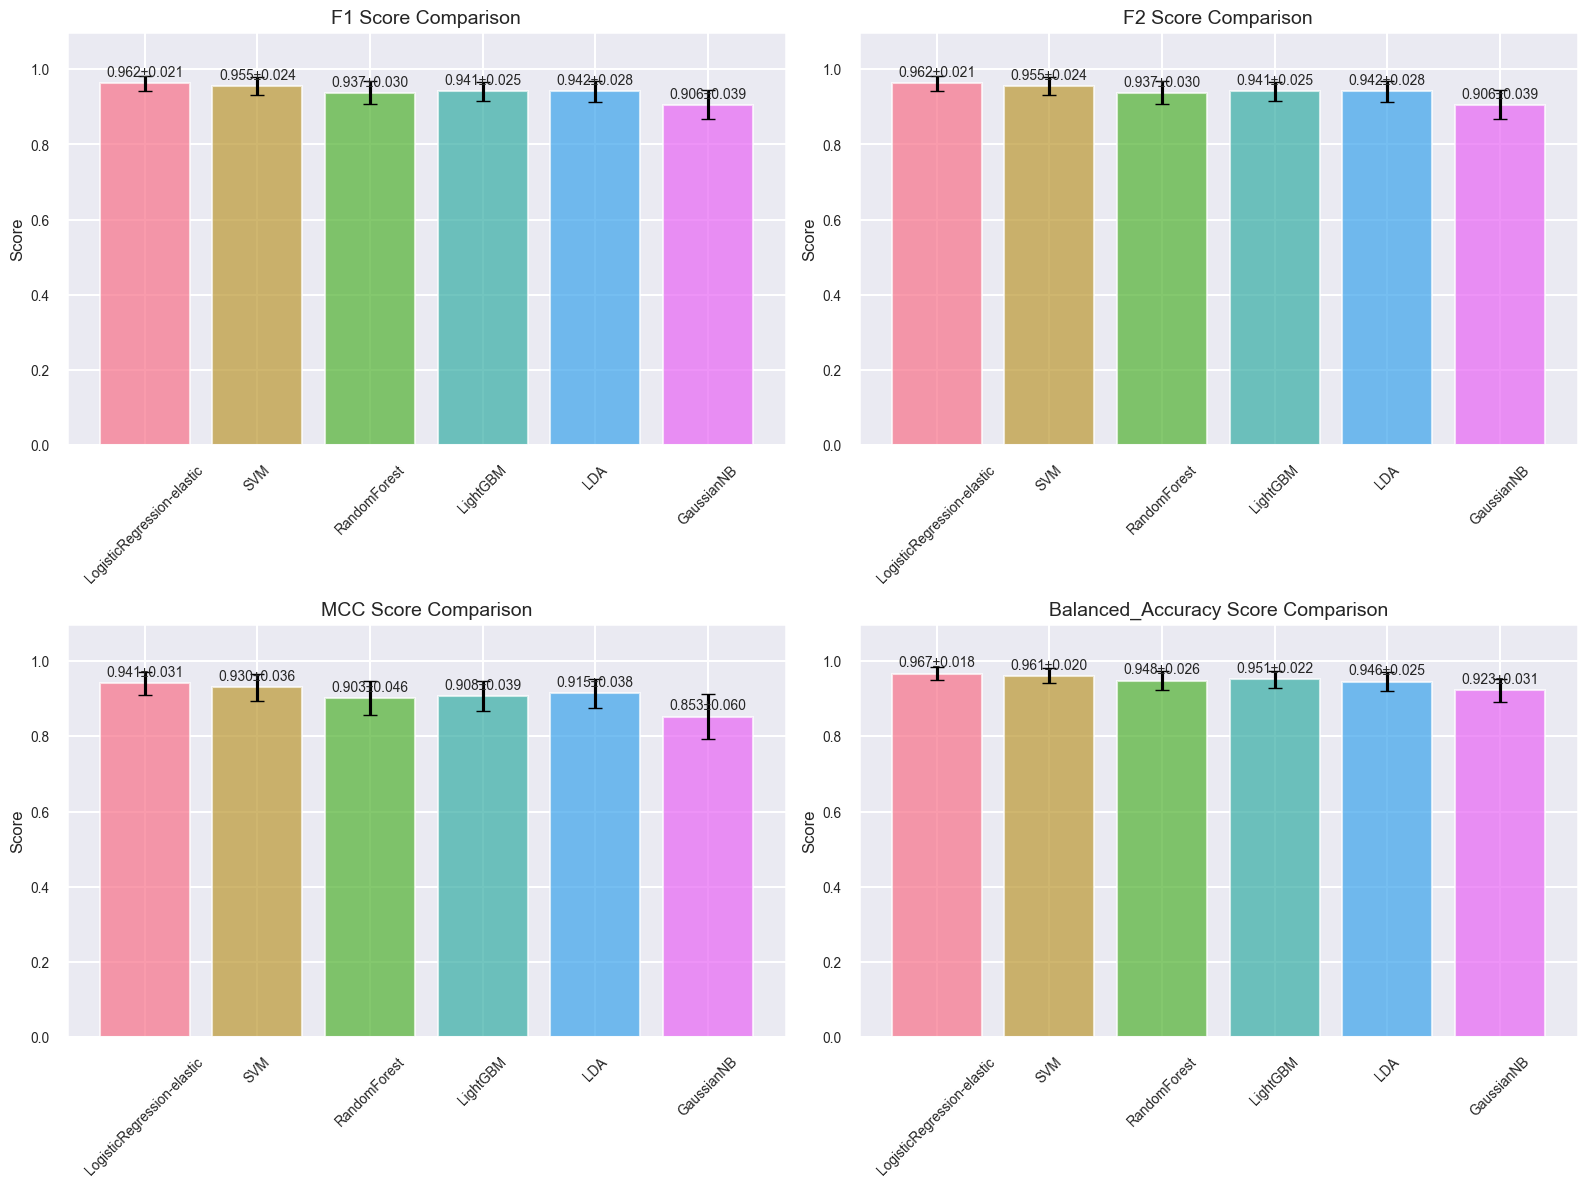

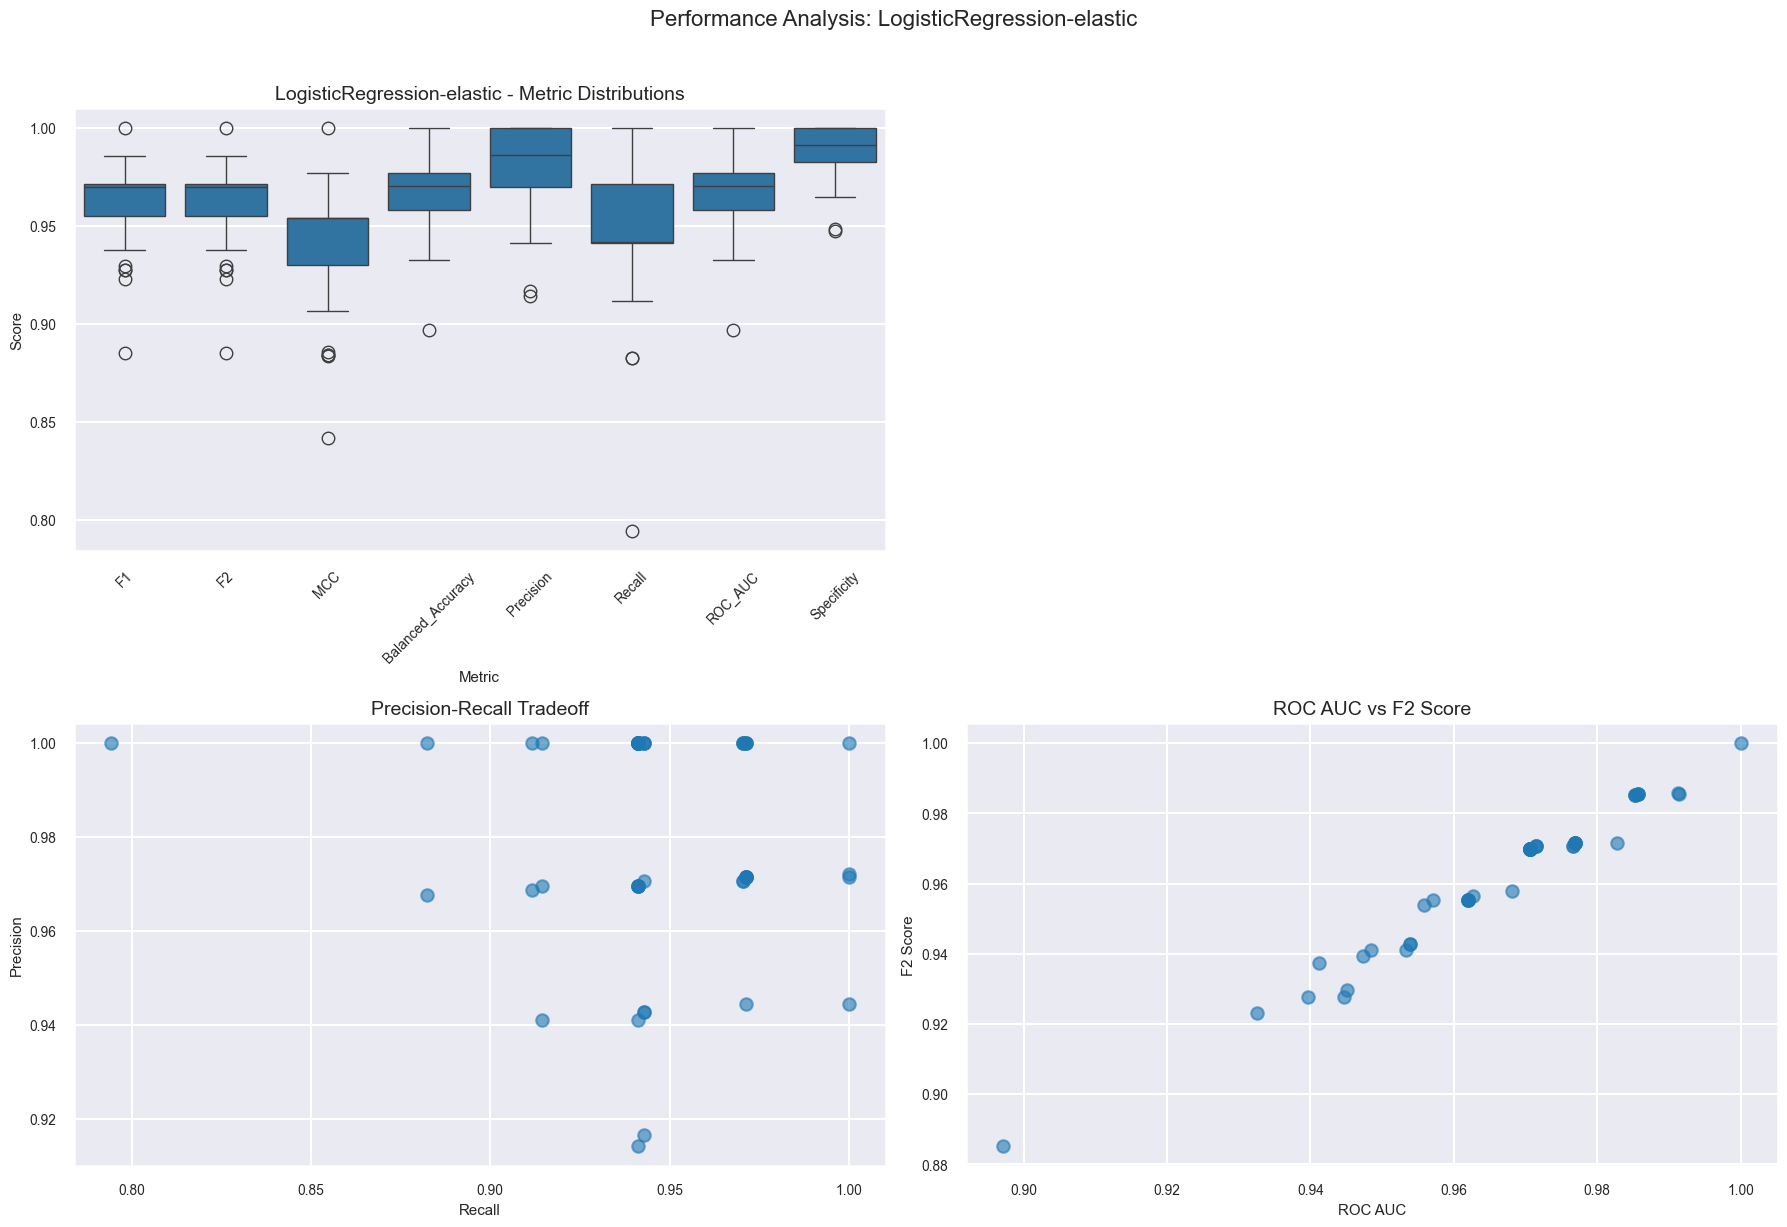

In [11]:
# Generate individual metric plots
plot_individual_metrics(comparison_df, processed_results)

# Generate comprehensive dashboard for best classifier
plot_best_classifier_dashboard(processed_results, best_classifier)

## Train Final Model Instance

### Step 1: Select best hyperparameters using 5-fold CV on entire dataset

In [12]:
print(f"\n{'='*50}")
print("TASK 4 - Training Final Model Instance")
print(f"{'='*50}")

print(f"\nStep 1: Tuning best classifier ({best_classifier}) on full dataset...")

# Initialize CV for hyperparameter tuning
final_tuner = ClassifierCV(
    classifier_name=best_classifier,
    tuning_beta=2,  # Consistent with evaluation
    seed=42,
    outer_folds=1,   # Not used for final tuning
    inner_folds=5,   # Using 5-fold CV for final parameter selection
    optimization_trials=100,  # More trials for final tuning
    trial_num=1,
    verbose=True
)

# Run tuning on full dataset
final_tuner.fit(X_raw_np, y_raw_np)

# Get best parameters
best_params = final_tuner.model.get_params()
print(f"\nBest parameters from 5-fold CV:")
for k, v in best_params.items():
    print(f"{k}: {v}")

[I 2025-05-09 23:24:28,953] A new study created in memory with name: no-name-5ed74084-46d4-43e1-a807-2e33d4bcb38a
[I 2025-05-09 23:24:29,030] Trial 0 finished with value: 0.8352943307180369 and parameters: {'C': 0.017670169402947963, 'l1_ratio': 0.9507143064099162}. Best is trial 0 with value: 0.8352943307180369.
[I 2025-05-09 23:24:29,117] Trial 1 finished with value: 0.9658051626958624 and parameters: {'C': 2.4658329458549115, 'l1_ratio': 0.5986584841970366}. Best is trial 1 with value: 0.9658051626958624.
[I 2025-05-09 23:24:29,130] Trial 2 finished with value: 0.0 and parameters: {'C': 0.0008632008168602552, 'l1_ratio': 0.15599452033620265}. Best is trial 1 with value: 0.9658051626958624.



TASK 4 - Training Final Model Instance

Step 1: Tuning best classifier (LogisticRegression-elastic) on full dataset...


[I 2025-05-09 23:24:29,140] Trial 3 finished with value: 0.0 and parameters: {'C': 0.00022310108018679258, 'l1_ratio': 0.8661761457749352}. Best is trial 1 with value: 0.9658051626958624.
[I 2025-05-09 23:24:29,213] Trial 4 finished with value: 0.9514056220162018 and parameters: {'C': 0.4042872735027334, 'l1_ratio': 0.7080725777960455}. Best is trial 1 with value: 0.9658051626958624.
[I 2025-05-09 23:24:29,222] Trial 5 finished with value: 0.0 and parameters: {'C': 0.00013289448722869195, 'l1_ratio': 0.9699098521619943}. Best is trial 1 with value: 0.9658051626958624.
[I 2025-05-09 23:24:29,295] Trial 6 finished with value: 0.9657719356889514 and parameters: {'C': 9.877700294007917, 'l1_ratio': 0.21233911067827616}. Best is trial 1 with value: 0.9658051626958624.
[I 2025-05-09 23:24:29,307] Trial 7 finished with value: 0.0 and parameters: {'C': 0.0012329623163659848, 'l1_ratio': 0.18340450985343382}. Best is trial 1 with value: 0.9658051626958624.
[I 2025-05-09 23:24:29,331] Trial 8 fi


Best parameters from 5-fold CV:
C: 8.651321062120136
class_weight: {1: 1, 0: 1}
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: 0.1144184297417854
max_iter: 100
multi_class: deprecated
n_jobs: None
penalty: elasticnet
random_state: 42
solver: saga
tol: 0.0001
verbose: 0
warm_start: False


### Step 2: Train final model on all data

In [13]:
from sklearn.linear_model import LogisticRegression

print("\nStep 2: Training final model on all data...")

# Re-initialize the model with the best parameters
final_model = LogisticRegression(**best_params)

# Apply the same preprocessing pipeline
X_preprocessed = final_tuner.class_specific_impute(X_raw_np, y_raw_np)
X_preprocessed = final_tuner.scaler.transform(X_preprocessed)

# Train on full dataset
final_model.fit(X_preprocessed, y_raw_np)
print("Final model trained on full dataset.")


Step 2: Training final model on all data...
Final model trained on full dataset.


### Step 3: Validate on kept-out set (with proper preprocessing)


Step 3: Kept-out set validation:
--------------------------------------------------

Performance Metrics:
Accuracy: 1.000
F1: 1.000
F2: 1.000
ROC AUC: 1.000
Precision: 1.000
Recall: 1.000

Confusion Matrix:
[[33  0]
 [ 0 19]]


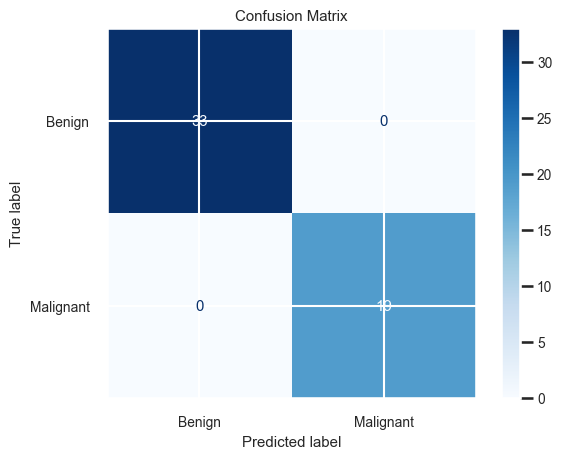

In [14]:
print("\nStep 3: Kept-out set validation:")
print("-"*50)

# Preprocess kept-out data using training transformers
X_keptout_preprocessed = final_tuner.class_specific_impute(X_keptout, np.zeros(len(X_keptout)))  # Mock y for imputation
X_keptout_preprocessed = final_tuner.scaler.transform(X_keptout_preprocessed)

# Generate predictions
y_pred = final_model.predict(X_keptout_preprocessed)
y_proba = final_model.predict_proba(X_keptout_preprocessed)[:, 1] if hasattr(final_model, "predict_proba") else None

# Calculate metrics
metrics = {
    'Accuracy': accuracy_score(y_keptout, y_pred),
    'F1': f1_score(y_keptout, y_pred),
    'F2': fbeta_score(y_keptout, y_pred, beta=2),
    'ROC AUC': roc_auc_score(y_keptout, y_proba) if y_proba is not None else np.nan,
    'Precision': precision_score(y_keptout, y_pred),
    'Recall': recall_score(y_keptout, y_pred)
}

# Print results
print("\nPerformance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")


print("\nConfusion Matrix:")
print(confusion_matrix(y_keptout, y_pred))
cm = confusion_matrix(y_keptout, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Save the model and the complete pipeline

In [15]:
# Save the model
os.makedirs('models', exist_ok=True)

model_path = os.path.join("..", "models", "winner.pkl")

joblib.dump(final_model, model_path)
print(f"Final model saved to {model_path}")

Final model saved to ../models/winner.pkl


In [16]:
# Save the pipeline
pipeline = Pipeline([
    ('imputer', final_tuner.class_specific_impute),
    ('scaler', final_tuner.scaler),
    ('model', final_model)
])

pipeline_path = os.path.join("..", "models", f'winner_pipeline.pkl')

joblib.dump(pipeline, pipeline_path)
print(f"\nSaved complete pipeline to: {pipeline_path}")


Saved complete pipeline to: ../models/winner_pipeline.pkl


---
---

# Bonus Parts

## 1. Feature Selection

### Method 1: Univariate Statistical (SelectKBest)

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.impute import SimpleImputer

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_raw_np_imputed = imputer.fit_transform(X_raw_np)

# Select top 10 features
selector_kbest = SelectKBest(score_func=f_classif, k=10)
X_kbest = selector_kbest.fit_transform(X_raw_np_imputed, y_raw_np)

# Get selected feature names
selected_features_kbest = X_raw.columns[selector_kbest.get_support()]
print("Selected Features (KBest):", selected_features_kbest)

Selected Features (KBest): Index(['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean',
       'concave_points_mean', 'area_se', 'radius_worst', 'perimeter_worst',
       'area_worst', 'concave_points_worst'],
      dtype='object')


### Method 2: Model-Based (Feature Importance)

In [18]:
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import SimpleImputer

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_raw_np_imputed = imputer.fit_transform(X_raw_np)

# Use the trained model's feature importance
selector_model = SelectFromModel(final_model, max_features=10, threshold=-np.inf)
X_model_selected = selector_model.fit_transform(X_raw_np_imputed, y_raw_np)

# Get selected features
selected_features_model = X_raw.columns[selector_model.get_support()]
print("Selected Features (Model):", selected_features_model)

Selected Features (Model): Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'texture_se', 'area_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst'],
      dtype='object')


### Evaluate Selected Features

In [19]:
def evaluate_features(X_selected, y_selected, method_name):
    # Refit the scaler on the selected features
    scaler = StandardScaler()
    X_selected_scaled = scaler.fit_transform(X_selected)
    
    # Retrain the model on the selected features
    model = LogisticRegression(**best_params)
    model.fit(X_selected_scaled, y_selected)  # Retrain using the selected features
    
    # Select the same features from the kept-out set
    X_keptout_selected = X_keptout_preprocessed[:, selector_kbest.get_support()] if method_name == "KBest (ANOVA)" else X_keptout_preprocessed[:, selector_model.get_support()]
    
    # Predict on the kept-out set
    y_pred_fs = model.predict(X_keptout_selected)
    y_proba_fs = model.predict_proba(X_keptout_selected)[:, 1]
    
    return {
        'Method': method_name,
        'Accuracy': accuracy_score(y_keptout, y_pred_fs),
        'F1': f1_score(y_keptout, y_pred_fs),
        'ROC AUC': roc_auc_score(y_keptout, y_proba_fs),
        'Features': X_selected.shape[1]
    }

# Evaluate both methods
results = [
    evaluate_features(X_kbest, y_raw_np, "KBest (ANOVA)"),
    evaluate_features(X_model_selected, y_raw_np, "Model-Based")
]
results_df = pd.DataFrame(results)

### Visual Comparison

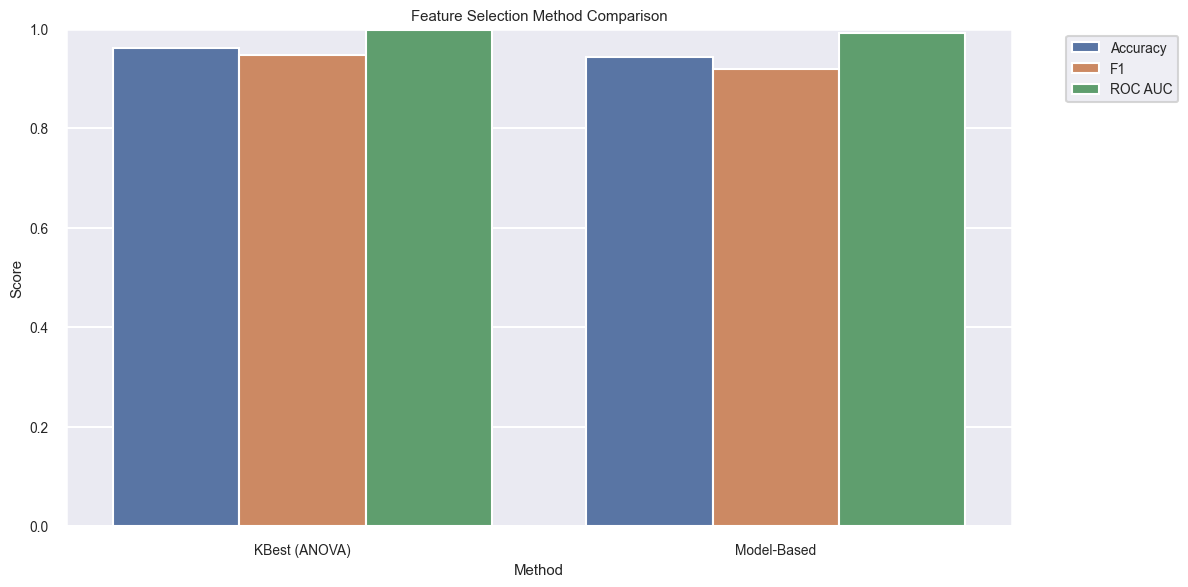

In [20]:
# Melt for plotting
melted_df = results_df.melt(id_vars=['Method', 'Features'], 
                           var_name='Metric', 
                           value_name='Score')

# Plot comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='Method', y='Score', hue='Metric', palette='deep')
plt.title("Feature Selection Method Comparison")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

---
---

## 2. Handle Class Imbalance

In [21]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from collections import Counter

In [22]:
# =================================================================
# Baseline Evaluation
# =================================================================
X_keptout_preprocessed = final_tuner.class_specific_impute(X_keptout, np.zeros(len(X_keptout)))
X_keptout_preprocessed = final_tuner.scaler.transform(X_keptout_preprocessed)

# Generate predictions using the kept-out set
y_pred_correct = final_model.predict(X_keptout_preprocessed)
y_proba_correct = final_model.predict_proba(X_keptout_preprocessed)[:, 1]

# =================================================================
# Baseline Metrics
# =================================================================
baseline_metrics = {
    'Method': 'Baseline (Imbalanced)',
    'Accuracy': accuracy_score(y_keptout, y_pred_correct),
    'F1': f1_score(y_keptout, y_pred_correct),
    'Recall': recall_score(y_keptout, y_pred_correct),
    'Precision': precision_score(y_keptout, y_pred_correct),
    'ROC AUC': roc_auc_score(y_keptout, y_proba_correct)
}

In [23]:
# =================================================================
# Define Balancing Methods
# =================================================================
class ClassSpecificPreprocessor:
    def __init__(self, tuner):
        self.tuner = tuner
    
    def fit(self, X, y=None):
        # No fitting required for this preprocessor
        return self
    
    def transform(self, X, y=None):
        # Mock y if needed (for kept-out set)
        y_fill = np.zeros(len(X)) if y is None else y
        X_imputed = self.tuner.class_specific_impute(X, y_fill)
        return self.tuner.scaler.transform(X_imputed)

# Initialize preprocessor with the tuner
preprocessor = ClassSpecificPreprocessor(final_tuner)

methods = {
    # SMOTE (Oversampling)
    "SMOTE": ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampler', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(**best_params))
    ]),
    
    # Random Oversampling
    "Random Oversampling": ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampler', RandomOverSampler(random_state=42)),
        ('classifier', LogisticRegression(**best_params))
    ]),
    
    # Random Undersampling
    "Random Undersampling": ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampler', RandomUnderSampler(random_state=42)),
        ('classifier', LogisticRegression(**best_params))
    ]),
    
    # NearMiss (Undersampling)
    "NearMiss": ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampler', NearMiss(version=1, n_neighbors=3)),
        ('classifier', LogisticRegression(**best_params))
    ]),
    
    # Class Weighting (No resampling)
    "Class Weighting": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            **{k: v for k, v in best_params.items() if k != 'class_weight'},
            class_weight='balanced'  # Explicitly set class_weight
        ))
    ])
}

# =================================================================
# Train + Evaluate on Kept-Out Test Set (X_keptout, y_keptout)
# =================================================================
results = [baseline_metrics]  # Start with the baseline

for method_name, pipeline in methods.items():
    print(f"\n=== Training: {method_name} ===")
    
    # Fit on full training data (X_raw_np, y_raw_np)
    pipeline.fit(X_raw_np, y_raw_np)
    
    # Predict on kept-out set (preprocessed automatically)
    # Ensure X_keptout and y_keptout have consistent lengths
    if len(X_keptout) != len(y_keptout):
        min_length = min(len(X_keptout), len(y_keptout))
        X_keptout = X_keptout[:min_length]
        y_keptout = y_keptout[:min_length]
    
    y_pred_test = pipeline.predict(X_keptout)
    y_proba_test = pipeline.predict_proba(X_keptout)[:, 1]
    
    # Store metrics
    results.append({
        'Method': method_name,
        'Accuracy': accuracy_score(y_keptout, y_pred_test),
        'F1': f1_score(y_keptout, y_pred_test),
        'Recall': recall_score(y_keptout, y_pred_test),
        'Precision': precision_score(y_keptout, y_pred_test),
        'ROC AUC': roc_auc_score(y_keptout, y_proba_test)
    })

# =================================================================
# 3. Results Comparison
# =================================================================
results_df = pd.DataFrame(results)
print("\n=== Final Comparison ===")
print(results_df.sort_values("F1", ascending=False))

# Save to CSV
results_df.to_csv("balancing_methods_comparison.csv", index=False)


=== Training: SMOTE ===

=== Training: Random Oversampling ===

=== Training: Random Undersampling ===

=== Training: NearMiss ===

=== Training: Class Weighting ===

=== Final Comparison ===
                  Method  Accuracy        F1  Recall  Precision  ROC AUC
0  Baseline (Imbalanced)  1.000000  1.000000     1.0       1.00      1.0
1                  SMOTE  1.000000  1.000000     1.0       1.00      1.0
3   Random Undersampling  1.000000  1.000000     1.0       1.00      1.0
4               NearMiss  1.000000  1.000000     1.0       1.00      1.0
2    Random Oversampling  0.980769  0.974359     1.0       0.95      1.0
5        Class Weighting  0.980769  0.974359     1.0       0.95      1.0


### Visual Comparison

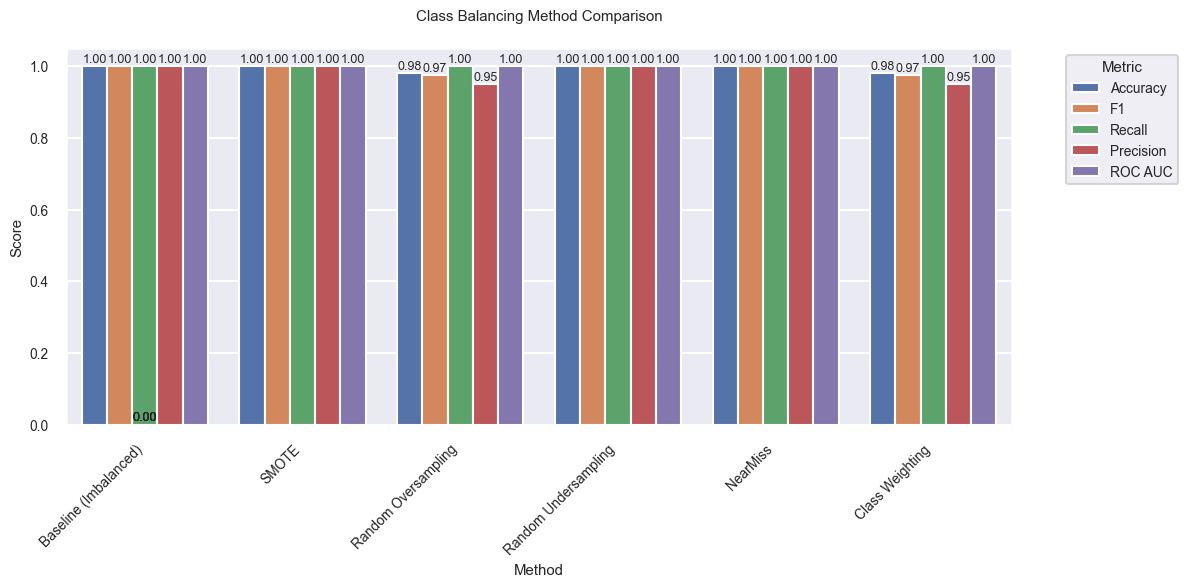

Exception ignored in: <function ResourceTracker.__del__ at 0x107746de0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10a4aade0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi

In [ ]:
# Prepare Data (melted format)
melted_df = results_df.melt(id_vars=['Method'], 
                           value_vars=['Accuracy', 'F1', 'Recall', 'Precision', 'ROC AUC'],
                           var_name='Metric', 
                           value_name='Score')

# Plot with 'deep' palette 
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=melted_df, 
                 x='Method', 
                 y='Score', 
                 hue='Metric',
                 palette='deep', 
                 saturation=0.85)

# Customize
plt.title("Class Balancing Method Comparison", pad=20)
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right')

# Move legend and adjust layout
plt.legend(bbox_to_anchor=(1.05, 1), title='Metric')
plt.tight_layout()

# Add value labels
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}", 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', 
        xytext=(0, 5), 
        textcoords='offset points',
        fontsize=9
    )

plt.show()